In [1]:
import sys
import numpy as np
import time
#!python -m pip install ujson
import ujson as json

#!python -m pip install matplotlib
%matplotlib inline
from matplotlib import pyplot as plt 
import random

#!conda install pandas=1.0.5 --yes
 
import pandas as pd 
from pandas.core.common import flatten
import itertools
import re
from simple_colors import *
import networkx as nx
from networkx.readwrite import json_graph

In [2]:
print(sys.executable)
#import importlib.util 
#print(sys.modules)
#import pandas as pd
pd.__version__ 
pd.set_option("display.max_columns", None)

/xdisk/msurdeanu/fanluo/miniconda3/envs/spacy/bin/python


In [3]:
import sys
sys.path.insert(0, '/xdisk/msurdeanu/fanluo/miniconda3/envs/hotpotqa/lib/python3.8/site-packages') 

import os
os.chdir('/xdisk/msurdeanu/fanluo/hotpotQA/') 
from util import get_buckets

In [4]:
import string 
def _normalize_text(s):
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

In [5]:
import re
import string
# def findWholeWord(w):
#     return re.compile(r'\b({0})\b'.format(re.escape(w.strip(string.punctuation))), flags=re.IGNORECASE).search
#     # strip(string.punctuation) to remove heading and ending punctuations in the answer, otherwise can not found correctly if heading or ending punctuations appears
    
def findWord(w, context):
    if(w == ''):
        return False
    if(len(list(re.finditer(str(w), str(context), re.IGNORECASE))) > 0):
        return True
    else:
        return False

In [6]:
def vis_graph(H, nodes, color_nodes):
    
    G = H.subgraph(nodes)  # Returns a subgraph containing nodes in nbunch
    print(black("nodes to draw", ['bold']), G.nodes())
    
    plt.figure(figsize=(20,10))
    color_map = dict.fromkeys(color_nodes, 1)   
    values = [color_map.get(node, 0.6) for node in G.nodes()]  # beside color_nodes, other nodes are 0.6 
    pos = nx.random_layout(G)
    edge_labels = nx.get_edge_attributes(G, 'src')
    nx.draw(G, pos, node_color=values, with_labels=True, node_size=800, font_size=20, font_color='blue')
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=15) 
    plt.show() 
     
    for n, nbrs in G.adj.items():  # each node and its neighbors   
        for nbr, eattr in nbrs.items(): # each neighbor and edge attr
            print(f"({n}, {nbr}, {eattr})")
            
    return

## HopotQA dataset

### Train Statistics

In [7]:
with open('/xdisk/msurdeanu/fanluo/hotpotQA/Data/hotpot_train_v1.1.json') as json_file:      
    data = json_file.readlines()
    data = list(map(json.loads, data)) 
train_question_df = pd.DataFrame(data[0])
del data
import gc
gc.collect()

0

In [8]:
pd.set_option('display.max_columns', None)   # show all columns
train_question_df.head(3)

,supporting_facts,level,question,context,answer,_id,type
0,"[[Arthur's Magazine, 0], [First for Women, 0]]",medium,Which magazine was started first Arthur's Maga...,"[[Radio City (Indian radio station), [Radio Ci...",Arthur's Magazine,5a7a06935542990198eaf050,comparison
1,"[[Oberoi family, 0], [The Oberoi Group, 0]]",medium,The Oberoi family is part of a hotel company t...,"[[Ritz-Carlton Jakarta, [The Ritz-Carlton Jaka...",Delhi,5a879ab05542996e4f30887e,bridge
2,"[[Allie Goertz, 0], [Allie Goertz, 1], [Allie ...",hard,Musician and satirist Allie Goertz wrote a son...,"[[Lisa Simpson, [Lisa Marie Simpson is a ficti...",President Richard Nixon,5a8d7341554299441c6b9fe5,bridge


In [9]:
train_question_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90447 entries, 0 to 90446
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   supporting_facts  90447 non-null  object
 1   level             90447 non-null  object
 2   question          90447 non-null  object
 3   context           90447 non-null  object
 4   answer            90447 non-null  object
 5   _id               90447 non-null  object
 6   type              90447 non-null  object
dtypes: object(7)
memory usage: 4.8+ MB


#### level

In [10]:
# Distribution of difficulty levels
train_question_df.level.value_counts()

medium    56814
easy      17972
hard      15661
Name: level, dtype: int64

#### type

In [11]:
train_question_df.type.describe()

count      90447
unique         2
top       bridge
freq       72991
Name: type, dtype: object

In [12]:
# Distribution of type
grouped = train_question_df.groupby(['type'])
type_counts = grouped.size()  # count of each 
type_counts

type
bridge        72991
comparison    17456
dtype: int64

#### context 

In [13]:
train_question_df['context_flattened'] = train_question_df['context'].map(lambda x: list(flatten(x)))

In [14]:
train_question_df['context_joint'] = train_question_df['context_flattened'].map(lambda x: " ".join(x) )

In [15]:
train_question_df.context_joint  = train_question_df.context_joint.map(_normalize_text)  
# train_question_df.context_joint  = train_question_df.context_joint.str.lower().map(lambda x:  " ".join(re.sub(r'"', r'', x).split()) ) 

In [16]:
train_question_df['num_context_words'] = train_question_df.context_joint.str.split(' ').str.len()
train_question_df['num_context_words'].describe()  # stat of numer of words in context

count    90447.000000
mean       824.775946
std        226.165582
min         27.000000
25%        677.000000
50%        808.000000
75%        952.000000
max       2558.000000
Name: num_context_words, dtype: float64

In [17]:
train_question_df.head(1)

,supporting_facts,level,question,context,answer,_id,type,context_flattened,context_joint,num_context_words
0,"[[Arthur's Magazine, 0], [First for Women, 0]]",medium,Which magazine was started first Arthur's Maga...,"[[Radio City (Indian radio station), [Radio Ci...",Arthur's Magazine,5a7a06935542990198eaf050,comparison,"[Radio City (Indian radio station), Radio City...",radio city indian radio station radio city is ...,737


In [18]:
train_question_df.context_flattened.str.len().describe()  # statistic of number of context sentences, including title

count    90447.000000
mean        50.891804
std         11.363687
min          4.000000
25%         44.000000
50%         50.000000
75%         57.000000
max        154.000000
Name: context_flattened, dtype: float64

In [19]:
grouped = train_question_df.groupby(train_question_df.context_flattened.str.len())
num_of_context_sentences = grouped.size()  # count of each 
num_of_context_sentences

context_flattened
4       8
5      35
6      49
7      44
8      49
       ..
143     2
144     1
146     4
152     1
154     2
Length: 142, dtype: int64

In [20]:
num_of_context_sentences.max()

3788

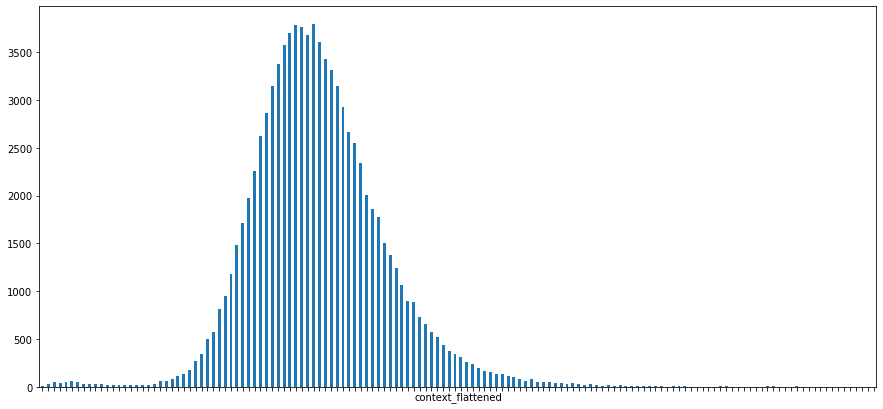

In [21]:
# distribution of number of context sentences
plot = num_of_context_sentences.plot(kind = 'bar', figsize=(15, 7))
plt.xticks(rotation=0)                                    # show label text horizontally
plt.setp(plot.axes.get_xticklabels(), visible=False)      # hide all labels
plt.setp(plot.axes.get_xticklabels()[::5], visible=True)  # set every 5 labels visible
plt.show() 

#### answer

In [22]:
train_question_df.answer = train_question_df.answer.map(_normalize_text)  # apply _normalize_text(answer)  

In [23]:
train_question_df.answer.str.split(' ').str.len().describe()  # statistic of number of words in the answer

count    90447.000000
mean         2.144328
std          1.641551
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         76.000000
Name: answer, dtype: float64

In [24]:
grouped = train_question_df.groupby(train_question_df.answer.str.split(' ').str.len())
num_of_answer_words = grouped.size()  
num_of_answer_words

answer
1     32984
2     32024
3     16665
4      4980
5      2003
6       663
7       328
8       159
9       112
10       85
11       70
12       42
13       45
14       42
15       30
16       34
17       23
18       27
19       18
20       17
21       11
22       14
23       12
24       11
25       12
26        5
27        4
28        3
29        3
30        5
31        2
32        3
33        3
34        1
35        2
38        1
40        1
57        1
72        1
76        1
dtype: int64

In [25]:
# number of questions with answer 'yes'
train_question_df.loc[train_question_df['answer'] == 'yes'].shape[0]

2748

In [26]:
# number of comparison questions with answer 'yes'
train_question_df.loc[(train_question_df['answer'] == 'yes') & (train_question_df['type'] == 'comparison')].shape[0]

2748

In [27]:
# number of questions with answer 'no'
train_question_df.loc[train_question_df['answer'] == 'no'].shape[0]

2735

In [28]:
# number of comparison questions with answer 'no'
train_question_df.loc[(train_question_df['answer'] == 'no') & (train_question_df['type'] == 'comparison')].shape[0]

2735

questions with answer yes/no are all comparison questions, and (17456-2735-2748) = 68.6% comparison questions have span answers 

In [29]:
# train_question_df["normalized_answer_in_context"] = train_question_df.apply(lambda row: row['answer'] in row['context_joint'], axis=1)

In [30]:
train_question_df['normalized_answer_in_context'] = train_question_df.apply(lambda row:  findWord(row['answer'], row['context_joint']) == True , axis = 1)

In [31]:
train_question_df.normalized_answer_in_context.describe()

count     90447
unique        2
top        True
freq      87837
Name: normalized_answer_in_context, dtype: object

87837 questions' answer in the context, 90447-87837 = 2610 questions' answer are not in the context

In [32]:
train_question_df.loc[(train_question_df['normalized_answer_in_context'] == False) & (train_question_df['answer'] != 'yes') & (train_question_df['answer'] != 'no')  & (train_question_df['answer'] != '')]

,supporting_facts,level,question,context,answer,_id,type,context_flattened,context_joint,num_context_words,normalized_answer_in_context


In [33]:
train_question_df.loc[(train_question_df['normalized_answer_in_context'] == False)].answer.describe()

count     2610
unique       3
top        yes
freq      2586
Name: answer, dtype: object

For those answers are not in the context, most normalized_answer are 'yes', some are 'no' and '', only one exception is train_question_df.iloc[38543]   

In [34]:
train_question_df.iloc[38543].answer

'3oh3'

In [35]:
train_question_df.iloc[38543].context_joint

'regina spektor regina ilyinichna spektor russian реги́нa ильи́нична спе́ктор born february 18 1980 is russianborn american singersongwriter and pianist she was born in moscow former soviet union now russia and began classical training on piano at age of six when she was nine years old her family emigrated from soviet union to united states where she continued her classical training into her teenage years she began to write original songs shortly thereafter 3oh3 3oh 3 pronounced three oh three is american electronic music duo from boulder colorado made up of sean foreman and nathaniel motte they are best known for their single dont trust me from their album want which reached number seven on billboard hot 100 their second single remix of starstrukk featuring katy perry from want was top ten hit in united kingdom ireland finland poland and australia they gained further recognition by featuring kesha on song my first kiss which was made lead single from their album streets of gold album 

#### supporting facts

In [36]:
train_question_df['invalid_supporting_facts_ids'] = train_question_df.apply(lambda row: True in [sp_idx >= len(dict(row['context'])[sp_t]) for (sp_t, sp_idx) in row['supporting_facts']], axis = 1)

In [37]:
train_question_df['invalid_supporting_facts_ids'].describe()

count     90447
unique        2
top       False
freq      90425
Name: invalid_supporting_facts_ids, dtype: object

22 questions have at least a supporting fact id out of range. That is, supporting fact id >= total num of sentence in the paragraph

In [38]:
train_question_df.loc[train_question_df['invalid_supporting_facts_ids']==True]

,supporting_facts,level,question,context,answer,_id,type,context_flattened,context_joint,num_context_words,normalized_answer_in_context,invalid_supporting_facts_ids
514,"[[Pro Wrestling Fujiwara Gumi, 0], [Pro Wrestl...",medium,What wrestling promotion was formed by the cur...,"[[NEVER Openweight Championship, [The NEVER Op...",pro wrestling fujiwara group,5a7b23ca554299042af8f703,bridge,"[NEVER Openweight Championship, The NEVER Open...",never openweight championship never openweight...,871,True,True
8332,"[[The Lion King, 0], [Jonathan Taylor Thomas, ...",easy,In the 1994 American animated musical film The...,"[[Timon &amp; Pumbaa (TV series), [The Lion Ki...",simba,5abed6d45542990832d3a0ef,bridge,"[Timon &amp; Pumbaa (TV series), The Lion King...",timon amp pumbaa tv series lion kings timon pu...,825,True,True
9548,"[[Suite française (Poulenc), 0], [Francis Poul...",medium,Suite francaise is by what French composer and...,"[[Trois morceaux dans le genre pathétique, [Tr...",francis jean marcel poulenc,5ab6b2fb5542995eadef0060,bridge,"[Trois morceaux dans le genre pathétique, Troi...",trois morceaux dans le genre pathétique trois ...,633,True,True
13415,"[[Guillermo del Toro, 1], [Pan's Labyrinth, 0]...",medium,Which two companies produced the 2006 film dir...,"[[The Shape of Water (film), [The Shape of Wat...",esperanto filmoj and warner bros,5ae0e2df5542990adbacf6b1,bridge,"[The Shape of Water (film), The Shape of Water...",shape of water film shape of water is 2017 ame...,794,True,True
20594,[[Harry Potter and the Chamber of Secrets (fil...,medium,Which character was played by Rupert Grint in ...,"[[Harry Potter and the Deathly Hallows, [Harry...",ron weasley,5a8d6138554299585d9e37c7,bridge,"[Harry Potter and the Deathly Hallows, Harry P...",harry potter and deathly hallows harry potter ...,1178,True,True
22896,"[[Division of Adelaide, 1], [Walkerville, Sout...",medium,Division of Adelaide includes which one of Ade...,"[[Parnell, New Zealand, [Parnell is an upmarke...",walkerville,5ab740165542992aa3b8c7fa,bridge,"[Parnell, New Zealand, Parnell is an upmarket ...",parnell new zealand parnell is upmarket suburb...,759,True,True
27436,"[[Ron Shelton, 0], [Khady Sylla, 0], [Khady Sy...",easy,"While Ron Shelton is a film director, what is ...","[[The Best of Times (film), [The Best of Times...",writer of two novels short work and film,5ab2f812554299545a2cfaee,comparison,"[The Best of Times (film), The Best of Times i...",best of times film best of times is 1986 ameri...,496,True,True
37004,"[[Teenage Mutant Ninja Turtles (1990 film), 2]...",medium,Teenage Mutant Ninja Turtles starred the voice...,[[Teenage Mutant Ninja Turtles III: Radical Re...,robert anthony robbie rist,5ae7e8ef5542994a481bbe05,bridge,[Teenage Mutant Ninja Turtles III: Radical Res...,teenage mutant ninja turtles iii radical rescu...,854,True,True
38579,"[[Gaz Coombes, 0], [Gaz Coombes, 2], [Harry St...",easy,Who has played in more bands Gaz Coombes or Ha...,"[[Here Come the Bombs, [Here Come the Bombs is...",harry edward styles,5ab273ee5542997061209606,comparison,"[Here Come the Bombs, Here Come the Bombs is t...",here come bombs here come bombs is debut solo ...,612,True,True
41267,"[[Samuel P. Cox, 0], [William T. Anderson, 1],...",hard,In what battle did businessman and farmer lead...,"[[The Outlaw Josey Wales, [The Outlaw Josey Wa...",battle of albany,5a84517355429933447460d5,bridge,"[The Outlaw Josey Wales, The Outlaw Josey Wale...",outlaw josey wales outlaw josey wales is 1976 ...,1024,True,True


In [39]:
print(train_question_df.iloc[514].context[7])
len(train_question_df.iloc[514].context[7])

['Minoru Suzuki', ['Minoru Suzuki (鈴木 実 , Suzuki Minoru , ring name: 鈴木 みのる) (born June 17, 1968) is a Japanese professional wrestler and mixed martial artist who is currently working for New Japan Pro Wrestling (NJPW) as a freelancer.', ' He is the current NEVER Openweight Champion in his first reign.']]


2

In [40]:
train_question_df['supporting_fact_text'] = train_question_df.apply(lambda row: [_normalize_text(dict(row['context'])[sp_t][sp_idx]) for (sp_t, sp_idx) in row['supporting_facts'] if(sp_idx < len(dict(row['context'])[sp_t])) ], axis = 1)

# train_question_df['supporting_fact_text'] = train_question_df.apply(lambda row: ['<t> ' + _normalize_text(sp_t) + ' </t> ' + _normalize_text(dict(row['context'])[sp_t][sp_idx]) + ' [/sent]' for (sp_t, sp_idx) in row['supporting_facts'] if(sp_idx < len(dict(row['context'])[sp_t])) ], axis = 1)

In [41]:
train_question_df.head(3)

,supporting_facts,level,question,context,answer,_id,type,context_flattened,context_joint,num_context_words,normalized_answer_in_context,invalid_supporting_facts_ids,supporting_fact_text
0,"[[Arthur's Magazine, 0], [First for Women, 0]]",medium,Which magazine was started first Arthur's Maga...,"[[Radio City (Indian radio station), [Radio Ci...",arthurs magazine,5a7a06935542990198eaf050,comparison,"[Radio City (Indian radio station), Radio City...",radio city indian radio station radio city is ...,737,True,False,[arthurs magazine 1844–1846 was american liter...
1,"[[Oberoi family, 0], [The Oberoi Group, 0]]",medium,The Oberoi family is part of a hotel company t...,"[[Ritz-Carlton Jakarta, [The Ritz-Carlton Jaka...",delhi,5a879ab05542996e4f30887e,bridge,"[Ritz-Carlton Jakarta, The Ritz-Carlton Jakart...",ritzcarlton jakarta ritzcarlton jakarta is hot...,675,True,False,[oberoi family is indian family that is famous...
2,"[[Allie Goertz, 0], [Allie Goertz, 1], [Allie ...",hard,Musician and satirist Allie Goertz wrote a son...,"[[Lisa Simpson, [Lisa Marie Simpson is a ficti...",president richard nixon,5a8d7341554299441c6b9fe5,bridge,"[Lisa Simpson, Lisa Marie Simpson is a fiction...",lisa simpson lisa marie simpson is fictional c...,1317,True,False,[allison beth allie goertz born march 2 1991 i...


In [42]:
# add a column to count the number of supporting facts
train_question_df['num_of_supporting_facts'] = train_question_df.supporting_fact_text.str.len()

In [43]:
# Distribution of number of supporting facts
train_question_df.num_of_supporting_facts.describe()

count    90447.000000
mean         2.384402
std          0.672601
min          2.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         12.000000
Name: num_of_supporting_facts, dtype: float64

In [44]:
# Distribution of number of supporting facts
grouped = train_question_df.groupby(['num_of_supporting_facts'])
num_of_supporting_facts_counts = grouped.size()  # count of each 
num_of_supporting_facts_counts

num_of_supporting_facts
2     63685
3     20019
4      5805
5       722
6       141
7        52
8        17
9         4
11        1
12        1
dtype: int64

In [45]:
# check thoese questions with more than 8 supportiing facts
train_question_df.loc[train_question_df.num_of_supporting_facts > 8]

,supporting_facts,level,question,context,answer,_id,type,context_flattened,context_joint,num_context_words,normalized_answer_in_context,invalid_supporting_facts_ids,supporting_fact_text,num_of_supporting_facts
1722,"[[Kazuo Ishiguro, 0], [Kazuo Ishiguro, 1], [Ka...",medium,Did Kazuo Ishiguro and Yukio Mishima both move...,"[[Five Modern Noh Plays, [Five Modern Nō Plays...",no,5a7f6b0a5542992097ad2f5e,comparison,"[Five Modern Noh Plays, Five Modern Nō Plays i...",five modern noh plays five modern nō plays is ...,743,True,False,[kazuo ishiguro obe frsa frsl japanese カズオ・イシグ...,12
2061,"[[Margaret MacDonald (visionary), 3], [Margare...",hard,Apart from the founder of the Exclusive Brethr...,"[[Behind the Exclusive Brethren, [Behind the E...",benjamin wills newton,5a8299e255429954d2e2eb76,bridge,"[Behind the Exclusive Brethren, Behind the Exc...",behind exclusive brethren behind exclusive bre...,943,True,False,[in response isabella and mary campbell of par...,9
11275,"[[Rowland Brown, 0], [Rowland Brown, 1], [Rowl...",medium,"Who won more Grammy Awards, Mike Nichols or Ro...","[[Mike Nichols: American Masters, [Mike Nichol...",mike nichols,5a82f46255429966c78a6ab2,comparison,"[Mike Nichols: American Masters, Mike Nichols:...",mike nichols american masters mike nichols ame...,946,True,False,[rowland brown november 6 1900 – may 6 1963 bo...,9
55922,"[[Mental Floss, 0], [Mental Floss, 1], [Mental...",easy,Is the Mental Floss paragraph related to the D...,"[[Mental Floss, [Mental Floss (stylized mental...",no,5ab2b513554299340b525549,comparison,"[Mental Floss, Mental Floss (stylized mental_f...",mental floss mental floss stylized mentalfloss...,887,True,False,[mental floss stylized mentalfloss is american...,11
61537,"[[The Final Solution (novel), 0], [The Final S...",hard,The Final Solution pays homage to a series whe...,"[[Sherlock Holmes (1951 TV series), [Sherlock ...",crime,5a8f2b2f55429918e830d1b7,bridge,"[Sherlock Holmes (1951 TV series), Sherlock Ho...",sherlock holmes 1951 tv series sherlock holmes...,927,True,False,[final solution story of detection is 2004 nov...,9
72623,"[[Too Weird to Live, Too Rare to Die!, 0], [To...",hard,What was the name of the drummer on the Panic ...,"[[Jake Sinclair (musician), [Jake Sinclair (bo...",spencer smith,5ab523a055429942dd415ff9,bridge,"[Jake Sinclair (musician), Jake Sinclair (born...",jake sinclair musician jake sinclair born marc...,1036,True,False,"[too weird to live too rare to die, is fourth ...",9


In [46]:
# add a column: whether each supporting fact contains the answer string or not
train_question_df['normalized_answer_in_supporting_fact'] = train_question_df.apply(lambda row: [ findWord(row['answer'], f) == True for f in row['supporting_fact_text']], axis = 1)
train_question_df['normalized_answer_in_supporting_fact']

0                      [True, False]
1                      [False, True]
2        [False, False, False, True]
3               [True, False, False]
4                       [True, True]
                    ...             
90442                  [False, True]
90443            [False, True, True]
90444                  [False, True]
90445                   [True, True]
90446            [False, True, True]
Name: normalized_answer_in_supporting_fact, Length: 90447, dtype: object

In [47]:
train_question_df.head(3)

,supporting_facts,level,question,context,answer,_id,type,context_flattened,context_joint,num_context_words,normalized_answer_in_context,invalid_supporting_facts_ids,supporting_fact_text,num_of_supporting_facts,normalized_answer_in_supporting_fact
0,"[[Arthur's Magazine, 0], [First for Women, 0]]",medium,Which magazine was started first Arthur's Maga...,"[[Radio City (Indian radio station), [Radio Ci...",arthurs magazine,5a7a06935542990198eaf050,comparison,"[Radio City (Indian radio station), Radio City...",radio city indian radio station radio city is ...,737,True,False,[arthurs magazine 1844–1846 was american liter...,2,"[True, False]"
1,"[[Oberoi family, 0], [The Oberoi Group, 0]]",medium,The Oberoi family is part of a hotel company t...,"[[Ritz-Carlton Jakarta, [The Ritz-Carlton Jaka...",delhi,5a879ab05542996e4f30887e,bridge,"[Ritz-Carlton Jakarta, The Ritz-Carlton Jakart...",ritzcarlton jakarta ritzcarlton jakarta is hot...,675,True,False,[oberoi family is indian family that is famous...,2,"[False, True]"
2,"[[Allie Goertz, 0], [Allie Goertz, 1], [Allie ...",hard,Musician and satirist Allie Goertz wrote a son...,"[[Lisa Simpson, [Lisa Marie Simpson is a ficti...",president richard nixon,5a8d7341554299441c6b9fe5,bridge,"[Lisa Simpson, Lisa Marie Simpson is a fiction...",lisa simpson lisa marie simpson is fictional c...,1317,True,False,[allison beth allie goertz born march 2 1991 i...,4,"[False, False, False, True]"


In [48]:
# questions that none of its supporting facts contains the answer string
# that is, rows that train_question_df['supporting_fact_contain_answer'] is a list of false
train_question_df[train_question_df['normalized_answer_in_supporting_fact'].map(lambda x: not(any(x)))] 

,supporting_facts,level,question,context,answer,_id,type,context_flattened,context_joint,num_context_words,normalized_answer_in_context,invalid_supporting_facts_ids,supporting_fact_text,num_of_supporting_facts,normalized_answer_in_supporting_fact
32,"[[Jane (magazine), 0], [First for Women, 0]]",medium,Are Jane and First for Women both women's maga...,"[[List of magazines in Malaysia, [The first wo...",yes,5ac061ab554299294b218fac,comparison,"[List of magazines in Malaysia, The first wome...",list of magazines in malaysia first womens mag...,1100,False,False,[jane was american magazine created to appeal ...,2,"[False, False]"
49,"[[Gin and tonic, 0], [Paloma (cocktail), 0]]",medium,Are Gin and tonic and Paloma both cocktails ba...,"[[Parallel key, [In music, a major scale and a...",no,5ac3ad225542995ef918c1da,comparison,"[Parallel key, In music, a major scale and a m...",parallel key in music major scale and minor sc...,572,True,False,[gin and tonic is highball cocktail made with ...,2,"[False, False]"
67,"[[Tim McIlrath, 0], [Spike Slawson, 0]]",medium,Are both Tim McIlrath and Spike Slawson Americ...,"[[Give It All, [""Give It All"" is a song by Ame...",yes,5ae3345f55429928c4239682,comparison,"[Give It All, ""Give It All"" is a song by Ameri...",give it all give it all is song by american ro...,703,False,False,[timothy james tim mcilrath born november 3 19...,2,"[False, False]"
87,"[[Pam Veasey, 0], [Jon Jost, 0]]",medium,Are Pam Veasey and Jon Jost both American?,"[[Pam Veasey, [Pamela Renea Veasey (born May 2...",yes,5abb1f745542996cc5e49fb5,comparison,"[Pam Veasey, Pamela Renea Veasey (born May 25,...",pam veasey pamela renea veasey born may 25 196...,421,False,False,[pamela renea veasey born may 25 1962 is ameri...,2,"[False, False]"
89,"[[Augusta Canal, 1], [New Orleans Outfall Cana...",hard,Are the New Orleans Outfall Canals the same le...,"[[Augusta Canal, [The Augusta Canal is a histo...",yes,5ac3e8c65542997ea680c993,comparison,"[Augusta Canal, The Augusta Canal is a histori...",augusta canal augusta canal is historic canal ...,945,False,False,[canal is fed by savannah river and passes thr...,2,"[False, False]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90368,"[[Daniel Vacek, 0], [Patty Fendick, 0]]",medium,Are Daniel Vacek and Patty Fendick both former...,"[[Patty Fendick, [Patty Fendick (born March 31...",yes,5a8f73b0554299458435d62b,comparison,"[Patty Fendick, Patty Fendick (born March 31, ...",patty fendick patty fendick born march 31 1965...,414,False,False,[daniel vacek born 1 april 1971 is former tenn...,2,"[False, False]"
90377,"[[Garo Yepremian, 0], [Edward Manukyan, 0]]",easy,"Garo Yepremian and Edward Manukyan, live in th...","[[2013 International Champions Cup, [The 2013 ...",yes,5ae36d6d5542992e3233c3f9,comparison,"[2013 International Champions Cup, The 2013 In...",2013 international champions cup 2013 internat...,868,False,False,[garabed sarkis garo yepremian june 2 1944 – m...,2,"[False, False]"
90388,"[[Philippe Perrin, 0], [Umberto Guidoni, 0], [...",medium,Are both Philippe Perrin and Umberto Guidoni c...,"[[Philippe Perrin (artist), [Philippe Perrin, ...",yes,5a8db41c554299068b959dc8,comparison,"[Philippe Perrin (artist), Philippe Perrin, (L...",philippe perrin artist philippe perrin la tron...,499,False,False,[philippe perrin colonel french air force born...,3,"[False, False, False]"
90434,"[[Aglaia, 0], [Valeriana, 0]]",easy,Does Aglaia belongs to Mahogany family and Val...,"[[Valeriana celtica, [Valeriana celtica is a s...",yes,5a858b9c5542994c784ddb23,comparison,"[Valeriana celtica, Valeriana celtica is a spe...",valeriana celtica valeriana celtica is species...,358,False,False,[aglaia is genus of more than 390 species belo...,2,"[False, False]"


According to the results, there are 3964 such questions that the answer string is not in any of the supporting facts.

In [49]:
# questions that none of its supporting facts contains the answer string, and its answer is neither 'yes' nor 'no'
train_question_df.loc[train_question_df['normalized_answer_in_supporting_fact'].map(lambda x: not(any(x))) & (train_question_df['answer'] != 'yes') & (train_question_df['answer'] != 'no') & (train_question_df['answer'] != '') ].shape[0]

30

In [50]:
train_question_df.loc[train_question_df['normalized_answer_in_supporting_fact'].map(lambda x: not(any(x))) & (train_question_df['answer'] != 'yes') & (train_question_df['answer'] != 'no') & (train_question_df['answer'] != '') ]

,supporting_facts,level,question,context,answer,_id,type,context_flattened,context_joint,num_context_words,normalized_answer_in_context,invalid_supporting_facts_ids,supporting_fact_text,num_of_supporting_facts,normalized_answer_in_supporting_fact
2347,"[[Skillet (band), 1], [Portugal. The Man, 2]]",easy,"Which rock band has more members, Skillet or P...","[[Alien Youth, [Alien Youth is the fifth album...",portugal man,5a7a870d55429941d65f2688,comparison,"[Alien Youth, Alien Youth is the fifth album r...",alien youth alien youth is fifth album release...,755,True,False,[band currently consists of husband john lead ...,2,"[False, False]"
6081,[[Tax Reduction and Simplification Act of 1977...,easy,Was the president who signed the The Tax Reduc...,[[Tax Reduction and Simplification Act of 1977...,james earl carter jr born october 1 1924 is am...,5ac2a89c55429921a00ab022,bridge,"[Tax Reduction and Simplification Act of 1977,...",tax reduction and simplification act of 1977 t...,601,True,False,[tax reduction and simplification act of 1977 ...,3,"[False, False, False]"
7750,"[[Kirsty MacColl, 0], [Portugal. The Man, 0]]",medium,"Who is more likely to visit alaska, Portugal....","[[Hallelujah (EP), [Hallelujah is a 7-track EP...",portugal man,5abbf2475542993f40c73c25,comparison,"[Hallelujah (EP), Hallelujah is a 7-track EP b...",hallelujah ep hallelujah is 7track ep by madch...,705,True,False,[kirsty anna maccoll 10 october 1959 – 18 dece...,2,"[False, False]"
12703,[[Ivan Allen Jr. Prize for Progress and Servic...,easy,What award is issued by the Georgia Institute ...,"[[Gary Pomerantz, [Gary M. Pomerantz (born Nov...",ivan allen jr prize for social courage,5a7e43155542991319bc9457,bridge,"[Gary Pomerantz, Gary M. Pomerantz (born Novem...",gary pomerantz gary m pomerantz born november ...,812,True,False,"[prior to ivan allen jr, prize for progress se...",4,"[False, False, False, False]"
15236,"[[Lego DC Super Hero Girls: Brain Drain, 0], [...",medium,What is the name of this animation division of...,"[[Lego Batman 2: DC Super Heroes, [Lego Batman...",warner bros animation,5ab856dd55429934fafe6d6e,bridge,"[Lego Batman 2: DC Super Heroes, Lego Batman 2...",lego batman 2 dc super heroes lego batman 2 dc...,751,True,False,[lego dc super hero girls brain drain is upcom...,4,"[False, False, False, False]"
17033,"[[Patrick Stump, 0], [Jun. K, 0]]",hard,"Who is younger, Patrick Stump or Jun. K?","[[Soul Punk, [Soul Punk is the first full-leng...",jun k,5a7939fd55429970f5fffe7e,comparison,"[Soul Punk, Soul Punk is the first full-length...",soul punk soul punk is first fulllength solo s...,942,True,False,[patrick martin stumph born april 27 1984 know...,2,"[False, False]"
24309,"[[Paul Norris (visual effects), 1], [Harry Pot...",easy,Paul Norris is a British visual effects superv...,[[Harry Potter and the Chamber of Secrets (fil...,warner bros pictures,5a8f3aac55429918e830d1db,bridge,[Harry Potter and the Chamber of Secrets (film...,harry potter and chamber of secrets film harry...,908,True,False,[best known for his works in harry potter and ...,2,"[False, False]"
28027,"[[Alshard, 4], [Standard RPG System, 1], [Stan...",hard,What is the newest game that uses the game sys...,"[[3d20 system, [The 3d20 system is the role-pl...",full metal panic rpg,5abc573d55429959677d6a8a,bridge,"[3d20 system, The 3d20 system is the role-play...",3d20 system 3d20 system is roleplaying game sy...,1019,True,False,[alshards game system is named standard rpg sy...,3,"[False, False, False]"
31461,"[[American Chopper, 3], [Paul Jr. Designs, 1]]",easy,What lifestyle brand motorcycle customizer and...,"[[Paul Jr. Designs, [Paul Jr., Designs (PJD) ...",paul jr designs,5a87255c5542996432c5722f,bridge,"[Paul Jr. Designs, Paul Jr., Designs (PJD) is...",paul jr designs paul jr designs pjd is lifesty...,787,True,False,[contrasting work and creative styles of fathe...,2,"[False, False]"
32827,"[[Scooby-Doo! and the Samurai Sword, 1], [Supe...",hard,Which of these is from the 

According to the results, there are only 30 questions that the answer string is not in any of the supporting facts and the answer is not 'yes', 'no', or ''. <br> 
Other cases:

- answer in the title
    - [2347]
        - answer: portugal man
        - sp title: Portugal. The Man
        
- answer cross sp sentences
    - [6081]
        - answer: james earl carter jr born october 1 1924 is american politician who served as 39th president of united states from 1977 to 1981 member of democratic party
        - sp contains: 
            - james earl carter jr born october 1 1924 is american politician who served as 39th president of united states from 1977 to 1981
            - member of democratic party he also served as governor of georgia prior to his election as president
    - [12703]
        - answer: ivan allen jr prize for social courage
        - sp contains:
            - prior to ivan allen jr  
            - prize for social courage is international award established in 2010
    - [28027]
        - answer: full metal panic rpg
        - sp contains: 
            - newest 14th game that use srs are full metal panic 
            - rpg based upon anime and light novels of same title
    - [15236]
        - answer: warner bros animation
        - sp contains:
            - film based on dc super hero girls franchise produced by warner bros
            - animation

In [51]:
# how many supporting facts contains the answer string, that is, the count of 'True'
train_question_df['normalized_answer_in_supporting_fact'].map(lambda x: sum(x)).describe()

count    90447.000000
mean         1.185954
std          0.504775
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          6.000000
Name: normalized_answer_in_supporting_fact, dtype: float64

In [52]:
grouped = train_question_df.groupby(train_question_df['normalized_answer_in_supporting_fact'].map(lambda x: sum(x)))
num_of_supporting_fact_contain_answer = grouped.size()  # count of each 
num_of_supporting_fact_contain_answer

normalized_answer_in_supporting_fact
0     3964
1    66304
2    19654
3      469
4       40
5        9
6        7
dtype: int64

In [53]:
# check thoese questions with more than 5 supporting facts contain the answer
train_question_df.loc[train_question_df['normalized_answer_in_supporting_fact'].map(lambda x: sum(x)) > 5]

,supporting_facts,level,question,context,answer,_id,type,context_flattened,context_joint,num_context_words,normalized_answer_in_context,invalid_supporting_facts_ids,supporting_fact_text,num_of_supporting_facts,normalized_answer_in_supporting_fact
1072,"[[Nemesis (rap crew), 0], [Run-DMC, 0], [Run-D...",easy,"What hip hop group from Hollis, Queens, New Yo...","[[Nemesis (rap crew), [Nemesis is the first ra...",rundmc,5a777aaf5542997042120a85,bridge,"[Nemesis (rap crew), Nemesis is the first rap ...",nemesis rap crew nemesis is first rap crew fro...,1174,True,False,[nemesis is first rap crew from dallas texas t...,7,"[True, True, False, True, True, True, True]"
1722,"[[Kazuo Ishiguro, 0], [Kazuo Ishiguro, 1], [Ka...",medium,Did Kazuo Ishiguro and Yukio Mishima both move...,"[[Five Modern Noh Plays, [Five Modern Nō Plays...",no,5a7f6b0a5542992097ad2f5e,comparison,"[Five Modern Noh Plays, Five Modern Nō Plays i...",five modern noh plays five modern nō plays is ...,743,True,False,[kazuo ishiguro obe frsa frsl japanese カズオ・イシグ...,12,"[True, False, False, True, False, True, True, ..."
18114,"[[Hot Stuff (Let's Dance), 0], [Hot Stuff (Let...",easy,"""Hot Stuff (Let's Dance)"" is a song by British...","[[Don't Love You No More (I'm Sorry), [""Don't ...",kano,5a7a78055542990783324f57,bridge,"[Don't Love You No More (I'm Sorry), ""Don't Lo...",dont love you no more im sorry dont love you n...,760,True,False,[hot stuff lets dance is song by british singe...,8,"[False, True, True, False, True, True, True, T..."
26083,"[[Manzanita Sol, 1], [Manzanita Sol, 2], [H-E-...",medium,What is the name of Grocery Company based in ...,"[[San Antonio Opera, [The San Antonio Opera wa...",heb,5a78b2b3554299148911f942,bridge,"[San Antonio Opera, The San Antonio Opera was ...",san antonio opera san antonio opera was americ...,1152,True,False,[in united states it is sold in 12pack cans 2l...,7,"[False, True, True, True, True, True, True]"
42377,"[[Niki Juusela, 3], [Niki Juusela, 4], [Footba...",medium,Niki Juusela has commentary for what family of...,"[[Football (disambiguation), [Football is a fa...",football,5ade1ac75542997c77aded49,bridge,"[Football (disambiguation), Football is a fami...",football disambiguation football is family of ...,1174,True,False,[in yle he has commentary on television ice ho...,6,"[True, True, True, True, True, True]"
42899,"[[Adavi Ramudu (2004 film), 1], [Adavi Ramudu ...",medium,Who is the actor who appeared in the Hindi act...,"[[Action Jackson (soundtrack), [Action Jackson...",prabhas,5ae7a7565542993210983ed6,bridge,"[Action Jackson (soundtrack), Action Jackson: ...",action jackson soundtrack action jackson origi...,642,True,False,"[prabhas and aarti agarwal played lead roles, ...",8,"[True, True, True, False, True, True, True, Fa..."
87878,"[[Gos Rater Valencià, 1], [Briard, 0], [Briard...",medium,Which breed of dog has a longer history compet...,"[[Briard, [The Briard is an ancient breed of l...",briard,5abaf3b65542992ccd8e7e72,comparison,"[Briard, The Briard is an ancient breed of lar...",briard briard is ancient breed of large herdin...,1024,True,False,[recognised by real sociedad canina de españa ...,8,"[False, True, True, True, True, False, True, T..."


### Dev Statistics

In [54]:
with open('/xdisk/msurdeanu/fanluo/hotpotQA/Data/hotpot_dev_distractor_v1.json') as json_file:      
    data = json_file.readlines()
    data = list(map(json.loads, data)) 
dev_question_df = pd.DataFrame(data[0])
del data
import gc
gc.collect()

0

In [55]:
dev_question_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7405 entries, 0 to 7404
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   _id               7405 non-null   object
 1   answer            7405 non-null   object
 2   question          7405 non-null   object
 3   supporting_facts  7405 non-null   object
 4   context           7405 non-null   object
 5   type              7405 non-null   object
 6   level             7405 non-null   object
dtypes: object(7)
memory usage: 405.1+ KB


#### level

In [56]:
# Distribution of difficulty levels
dev_question_df.level.value_counts()

hard    7405
Name: level, dtype: int64

dev are all *hard* questions

#### type

In [57]:
dev_question_df.type.describe()

count       7405
unique         2
top       bridge
freq        5918
Name: type, dtype: object

In [58]:
# Distribution of type
grouped = dev_question_df.groupby(['type'])
type_counts = grouped.size()  # count of each 
type_counts

type
bridge        5918
comparison    1487
dtype: int64

#### context 

In [59]:
dev_question_df['context_flattened'] = dev_question_df['context'].map(lambda x: list(flatten(x)))

In [60]:
dev_question_df['context_joint'] = dev_question_df['context_flattened'].map(lambda x: " ".join(x) )

In [61]:
dev_question_df.context_joint  = dev_question_df.context_joint.map(_normalize_text)  
# dev_question_df.context_joint  = dev_question_df.context_joint.str.lower().map(lambda x:  " ".join(re.sub(r'"', r'', x).split()) ) 

In [62]:
dev_question_df['num_context_words'] = dev_question_df.context_joint.str.split(' ').str.len()
dev_question_df['num_context_words'].describe()  # stat of numer of words in context

count    7405.000000
mean      834.009858
std       225.051416
min        42.000000
25%       688.000000
50%       817.000000
75%       962.000000
max      2384.000000
Name: num_context_words, dtype: float64

In [63]:
dev_question_df.head(1)

,_id,answer,question,supporting_facts,context,type,level,context_flattened,context_joint,num_context_words
0,5a8b57f25542995d1e6f1371,yes,Were Scott Derrickson and Ed Wood of the same ...,"[[Scott Derrickson, 0], [Ed Wood, 0]]","[[Ed Wood (film), [Ed Wood is a 1994 American ...",comparison,hard,"[Ed Wood (film), Ed Wood is a 1994 American bi...",ed wood film ed wood is 1994 american biograph...,700


In [64]:
dev_question_df.context_flattened.str.len().describe()  # statistic of number of context sentences

count    7405.000000
mean       51.341931
std        11.433978
min         4.000000
25%        44.000000
50%        50.000000
75%        57.000000
max       157.000000
Name: context_flattened, dtype: float64

In [65]:
grouped = dev_question_df.groupby(dev_question_df.context_flattened.str.len())
num_of_context_sentences = grouped.size()  # count of each 
num_of_context_sentences

context_flattened
4      1
5      1
6      4
7      3
8      6
      ..
133    1
136    1
137    1
144    1
157    1
Length: 107, dtype: int64

In [66]:
num_of_context_sentences.max()

328

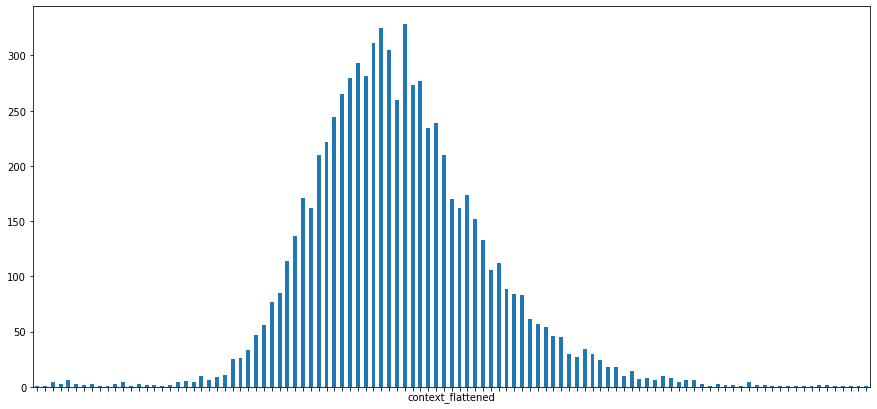

In [67]:
# distribution of number of context sentences
plot = num_of_context_sentences.plot(kind = 'bar', figsize=(15, 7))
plt.xticks(rotation=0)                                    # show label text horizontally
plt.setp(plot.axes.get_xticklabels(), visible=False)      # hide all labels
plt.setp(plot.axes.get_xticklabels()[::5], visible=True)  # set every 5 labels visible
plt.show() 

#### answer

In [68]:
dev_question_df.answer = dev_question_df.answer.map(_normalize_text)  # apply _normalize_text(answer)  

In [69]:
dev_question_df.answer.str.split(' ').str.len().describe()  # statistic of number of words in the answer

count    7405.000000
mean        2.360837
std         1.659080
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        28.000000
Name: answer, dtype: float64

In [70]:
grouped = dev_question_df.groupby(dev_question_df.answer.str.split(' ').str.len())
num_of_answer_words = grouped.size()  # count of each 
num_of_answer_words

answer
1     2441
2     2403
3     1442
4      577
5      247
6      103
7       71
8       44
9       20
10      12
11      11
12      13
13       6
14       5
15       5
16       2
17       1
22       1
28       1
dtype: int64

In [71]:
# number of questions with answer 'yes'
dev_question_df.loc[dev_question_df['answer'] == 'yes'].shape[0]

225

In [72]:
# number of comparison questions with answer 'yes'
dev_question_df.loc[(dev_question_df['answer'] == 'yes') & (dev_question_df['type'] == 'comparison')].shape[0]

225

In [73]:
# number of questions with answer 'no'
dev_question_df.loc[dev_question_df['answer'] == 'no'].shape[0]

233

In [74]:
# number of comparison questions with answer 'no'
dev_question_df.loc[(dev_question_df['answer'] == 'no') & (dev_question_df['type'] == 'comparison')].shape[0]

233

questions with answer yes/no are all comparison questions, and (1487-225-233) = 69.2% comparison questions have span answers 

In [75]:
# dev_question_df["normalized_answer_in_context"] = dev_question_df.apply(lambda row: row['answer'] in row['context_joint'], axis=1)

In [76]:
dev_question_df['normalized_answer_in_context'] = dev_question_df.apply(lambda row:  findWord(row['answer'], row['context_joint']) == True , axis = 1)

In [77]:
dev_question_df.normalized_answer_in_context.value_counts()

True     7191
False     214
Name: normalized_answer_in_context, dtype: int64

In [78]:
dev_question_df.loc[(dev_question_df['normalized_answer_in_context'] == False) & (dev_question_df['answer'] != 'yes') & (dev_question_df['answer'] != 'no') & (dev_question_df['answer'] != '')]

,_id,answer,question,supporting_facts,context,type,level,context_flattened,context_joint,num_context_words,normalized_answer_in_context


In [79]:
dev_question_df.loc[(dev_question_df['normalized_answer_in_context'] == False)].answer.describe()

count     214
unique      2
top       yes
freq      212
Name: answer, dtype: object

In [80]:
dev_question_df.loc[(dev_question_df['normalized_answer_in_context'] == False) & (dev_question_df['answer'] != 'yes') & (dev_question_df['answer'] != 'no')].answer.describe()

count     2
unique    1
top        
freq      2
Name: answer, dtype: object

#### supporting facts

In [81]:
dev_question_df['invalid_supporting_facts_ids'] = dev_question_df.apply(lambda row: True in [sp_idx >= len(dict(row['context'])[sp_t]) for (sp_t, sp_idx) in row['supporting_facts']], axis = 1)

In [82]:
dev_question_df['invalid_supporting_facts_ids'].describe()

count      7405
unique        2
top       False
freq       7404
Name: invalid_supporting_facts_ids, dtype: object

1 questions have at least a supporting fact id out of range. That is, supporting fact id >= total num of sentence in the paragraph

In [83]:
dev_question_df.loc[dev_question_df['invalid_supporting_facts_ids']==True]

,_id,answer,question,supporting_facts,context,type,level,context_flattened,context_joint,num_context_words,normalized_answer_in_context,invalid_supporting_facts_ids
5059,5ae61bfd5542992663a4f261,swingman,Which teams did Jimmy Butler play and what rol...,"[[Shooting guard, 4], [Shooting guard, 5], [Ji...","[[Jimmy Butler (actor), [Jimmy Butler (Februar...",bridge,hard,"[Jimmy Butler (actor), Jimmy Butler (February ...",jimmy butler actor jimmy butler february 20 19...,1272,True,True


In [84]:
# print(dev_question_df.iloc[514].context[7])
# len(dev_question_df.iloc[514].context[7])

In [85]:
dev_question_df['supporting_fact_text'] = dev_question_df.apply(lambda row: [_normalize_text(dict(row['context'])[sp_t][sp_idx]) for (sp_t, sp_idx) in row['supporting_facts'] if(sp_idx < len(dict(row['context'])[sp_t])) ], axis = 1)

In [86]:
dev_question_df.head(3)

,_id,answer,question,supporting_facts,context,type,level,context_flattened,context_joint,num_context_words,normalized_answer_in_context,invalid_supporting_facts_ids,supporting_fact_text
0,5a8b57f25542995d1e6f1371,yes,Were Scott Derrickson and Ed Wood of the same ...,"[[Scott Derrickson, 0], [Ed Wood, 0]]","[[Ed Wood (film), [Ed Wood is a 1994 American ...",comparison,hard,"[Ed Wood (film), Ed Wood is a 1994 American bi...",ed wood film ed wood is 1994 american biograph...,700,False,False,[scott derrickson born july 16 1966 is america...
1,5a8c7595554299585d9e36b6,chief of protocol,What government position was held by the woman...,"[[Kiss and Tell (1945 film), 0], [Shirley Temp...","[[Meet Corliss Archer, [Meet Corliss Archer, a...",bridge,hard,"[Meet Corliss Archer, Meet Corliss Archer, a p...",meet corliss archer meet corliss archer progra...,745,True,False,[kiss and tell is 1945 american comedy film st...
2,5a85ea095542994775f606a8,animorphs,"What science fantasy young adult series, told ...","[[The Hork-Bajir Chronicles, 0], [The Hork-Baj...","[[Andre Norton Award, [The Andre Norton Award ...",bridge,hard,"[Andre Norton Award, The Andre Norton Award fo...",andre norton award andre norton award for youn...,941,True,False,[horkbajir chronicles is second companion book...


In [87]:
# add a column to count the number of supporting facts
dev_question_df['num_of_supporting_facts'] = dev_question_df.supporting_fact_text.str.len()

In [88]:
# Distribution of number of supporting facts
dev_question_df.num_of_supporting_facts.describe()

count    7405.000000
mean        2.431330
std         0.711328
min         2.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         8.000000
Name: num_of_supporting_facts, dtype: float64

In [89]:
# Distribution of number of supporting facts
grouped = dev_question_df.groupby(['num_of_supporting_facts'])
num_of_supporting_facts_counts = grouped.size()  # count of each 
num_of_supporting_facts_counts

num_of_supporting_facts
2    4990
3    1775
4     536
5      80
6      14
7       9
8       1
dtype: int64

In [90]:
# check thoese questions with more than 8 supportiing facts
dev_question_df.loc[dev_question_df.num_of_supporting_facts == 8]

,_id,answer,question,supporting_facts,context,type,level,context_flattened,context_joint,num_context_words,normalized_answer_in_context,invalid_supporting_facts_ids,supporting_fact_text,num_of_supporting_facts
5262,5abab18d55429901930fa89e,lola dee,"The man Tony Bennet called ""The Father of Rock...","[[Lola Dee, 0], [Lola Dee, 1], [Lola Dee, 2], ...","[[Peter Clack, [Peter Clack is an Australian d...",bridge,hard,"[Peter Clack, Peter Clack is an Australian dru...",peter clack peter clack is australian drummer ...,1162,True,False,[lola dee is american singer and recording art...,8


In [91]:
# add a column: whether each supporting fact contains the answer string or not
dev_question_df['normalized_answer_in_supporting_fact'] = dev_question_df.apply(lambda row: [ findWord(row['answer'], f) == True for f in row['supporting_fact_text']], axis = 1)
dev_question_df['normalized_answer_in_supporting_fact']

0                          [False, False]
1                    [False, False, True]
2       [True, False, False, True, False]
3                          [False, False]
4                           [False, True]
                      ...                
7400                  [False, True, True]
7401                         [True, True]
7402                       [False, False]
7403                       [False, False]
7404                        [False, True]
Name: normalized_answer_in_supporting_fact, Length: 7405, dtype: object

In [92]:
dev_question_df.head(3)

,_id,answer,question,supporting_facts,context,type,level,context_flattened,context_joint,num_context_words,normalized_answer_in_context,invalid_supporting_facts_ids,supporting_fact_text,num_of_supporting_facts,normalized_answer_in_supporting_fact
0,5a8b57f25542995d1e6f1371,yes,Were Scott Derrickson and Ed Wood of the same ...,"[[Scott Derrickson, 0], [Ed Wood, 0]]","[[Ed Wood (film), [Ed Wood is a 1994 American ...",comparison,hard,"[Ed Wood (film), Ed Wood is a 1994 American bi...",ed wood film ed wood is 1994 american biograph...,700,False,False,[scott derrickson born july 16 1966 is america...,2,"[False, False]"
1,5a8c7595554299585d9e36b6,chief of protocol,What government position was held by the woman...,"[[Kiss and Tell (1945 film), 0], [Shirley Temp...","[[Meet Corliss Archer, [Meet Corliss Archer, a...",bridge,hard,"[Meet Corliss Archer, Meet Corliss Archer, a p...",meet corliss archer meet corliss archer progra...,745,True,False,[kiss and tell is 1945 american comedy film st...,3,"[False, False, True]"
2,5a85ea095542994775f606a8,animorphs,"What science fantasy young adult series, told ...","[[The Hork-Bajir Chronicles, 0], [The Hork-Baj...","[[Andre Norton Award, [The Andre Norton Award ...",bridge,hard,"[Andre Norton Award, The Andre Norton Award fo...",andre norton award andre norton award for youn...,941,True,False,[horkbajir chronicles is second companion book...,5,"[True, False, False, True, False]"


In [93]:
# questions that none of its supporting facts contains the answer string
# that is, rows that dev_question_df['supporting_fact_contain_answer'] is a list of false
dev_question_df[dev_question_df['normalized_answer_in_supporting_fact'].map(lambda x: not(any(x)))] 

,_id,answer,question,supporting_facts,context,type,level,context_flattened,context_joint,num_context_words,normalized_answer_in_context,invalid_supporting_facts_ids,supporting_fact_text,num_of_supporting_facts,normalized_answer_in_supporting_fact
0,5a8b57f25542995d1e6f1371,yes,Were Scott Derrickson and Ed Wood of the same ...,"[[Scott Derrickson, 0], [Ed Wood, 0]]","[[Ed Wood (film), [Ed Wood is a 1994 American ...",comparison,hard,"[Ed Wood (film), Ed Wood is a 1994 American bi...",ed wood film ed wood is 1994 american biograph...,700,False,False,[scott derrickson born july 16 1966 is america...,2,"[False, False]"
3,5adbf0a255429947ff17385a,no,Are the Laleli Mosque and Esma Sultan Mansion ...,"[[Laleli Mosque, 0], [Esma Sultan Mansion, 0]]","[[Esma Sultan (daughter of Abdülaziz), [Esma S...",comparison,hard,"[Esma Sultan (daughter of Abdülaziz), Esma Sul...",esma sultan daughter of abdülaziz esma sultan ...,540,True,False,[laleli mosque turkish laleli camii or tulip m...,2,"[False, False]"
9,5a8db19d5542994ba4e3dd00,yes,Are Local H and For Against both from the Unit...,"[[Local H, 0], [For Against, 0]]","[[Mendocino County GMO Ban, [Mendocino County,...",comparison,hard,"[Mendocino County GMO Ban, Mendocino County, C...",mendocino county gmo ban mendocino county cali...,847,False,False,[local h is american rock band originally form...,2,"[False, False]"
17,5ab29c24554299449642c932,yes,Are Giuseppe Verdi and Ambroise Thomas both Op...,"[[Giuseppe Verdi, 0], [Ambroise Thomas, 0]]","[[Bernhard Bötel, [Bernhard Bötel (1883–1953) ...",comparison,hard,"[Bernhard Bötel, Bernhard Bötel (1883–1953) wa...",bernhard bötel bernhard bötel 1883–1953 was ge...,744,False,False,[giuseppe fortunino francesco verdi 9 or 10 oc...,2,"[False, False]"
27,5abd259d55429924427fcf1a,yes,"Are both Dictyosperma, and Huernia described a...","[[Dictyosperma, 0], [Huernia, 0]]","[[Dictyosperma, [Dictyosperma is a monotypic g...",comparison,hard,"[Dictyosperma, Dictyosperma is a monotypic gen...",dictyosperma dictyosperma is monotypic genus o...,208,False,False,[dictyosperma is monotypic genus of flowering ...,2,"[False, False]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7339,5ae3d0bb5542990afbd1e1e5,yes,"are Dee Dee Ramone and Alex Band both singers,...","[[Dee Dee Ramone, 0], [Alex Band, 0]]","[[The Ramainz, [The Ramainz were a U.S. tribut...",comparison,hard,"[The Ramainz, The Ramainz were a U.S. tribute ...",ramainz ramainz were us tribute band to ramone...,818,False,False,[douglas glenn colvin september 18 1951 – june...,2,"[False, False]"
7349,5a7fe0b55542994857a76818,no,"Are The Maine and Black both from Tempe, Arizona?","[[The Maine (band), 0], [Black (Bangladeshi ba...","[[Arizona State University Tempe campus, [Ariz...",comparison,hard,"[Arizona State University Tempe campus, Arizon...",arizona state university tempe campus arizona ...,929,True,False,[maine is american rock band from tempe arizon...,2,"[False, False]"
7373,5ab8736455429916710eb058,yes,Are Yut and Tsuro both board games?,"[[Yut, 0], [Tsuro, 0]]","[[Days of Wonder, [Days of Wonder is a board g...",comparison,hard,"[Days of Wonder, Days of Wonder is a board gam...",days of wonder days of wonder is board game pu...,658,False,False,[yut nori also known as yunnori nyout and yoot...,2,"[False, False]"
7402,5a8173fa554299260e20a28e,yes,Are Billy and Barak both breeds of scenthound?...,"[[Bosnian Coarse-haired Hound, 0], [Billy (dog...","[[Styrian Coarse-haired Hound, [The Styrian Co...",comparison,hard,"[Styrian Coarse-haired Hound, The Styrian Coar...",styrian coarsehaired hound styrian coarsehaire...,957,False,False,[bosnian coarsehaired hound or bosanski oštrod...,2,"[False, False]"


According to the results, there are 341 such questions that the answer string is not in any of the supporting facts.

In [94]:
# questions that none of its supporting facts contains the answer string, and its answer is neither 'yes' nor 'no'
dev_question_df.loc[dev_question_df['normalized_answer_in_supporting_fact'].map(lambda x: not(any(x))) & (dev_question_df['answer'] != 'yes') & (dev_question_df['answer'] != 'no') & (dev_question_df['answer'] != '') ].shape[0]

4

In [95]:
dev_question_df.loc[dev_question_df['normalized_answer_in_supporting_fact'].map(lambda x: not(any(x))) & (dev_question_df['answer'] != 'yes') & (dev_question_df['answer'] != 'no') & (dev_question_df['answer'] != '') ]

,_id,answer,question,supporting_facts,context,type,level,context_flattened,context_joint,num_context_words,normalized_answer_in_context,invalid_supporting_facts_ids,supporting_fact_text,num_of_supporting_facts,normalized_answer_in_supporting_fact
289,5a7555215542996c70cfaee1,hey pa theres goat on roof,"Which came to market first, ""Hey Pa! There's a...","[[Hey Pa! There's a Goat on the Roof, 1], [Pol...","[[Pashmina, [Pashmina is a fine type of cashme...",comparison,hard,"[Pashmina, Pashmina is a fine type of cashmere...",pashmina pashmina is fine type of cashmere woo...,960,True,False,[theres goat on roof was childrens board game ...,2,"[False, False]"
520,5abdd08d5542991f6610604c,guardians of galaxy vol 2,Which movie directed by James Gunn portrayed t...,"[[Ego the Living Planet, 2], [Guardians of the...","[[Paul Williams (The Young and the Restless), ...",bridge,hard,"[Paul Williams (The Young and the Restless), P...",paul williams young and restless paul williams...,849,True,False,[ego is portrayed by kurt russell in guardians...,2,"[False, False]"
1785,5adde6535542990dbb2f7ef9,hail hail rock n roll,"Which documentary was filmed first, Almost Sun...","[[Almost Sunrise, 0], [Hail! Hail! Rock 'n' Ro...","[[Almost Sunrise, [Almost Sunrise is a 2016 Am...",comparison,hard,"[Almost Sunrise, Almost Sunrise is a 2016 Amer...",almost sunrise almost sunrise is 2016 american...,996,True,False,[almost sunrise is 2016 american documentary f...,2,"[False, False]"
2211,5ab4b9f75542990594ba9ca4,people and carnabeats,Who covered the song I Love You by Chris Write?,"[[I Love You (The Zombies song), 0], [I Love Y...","[[Spontaneous Combustion (album), [Spontaneous...",bridge,hard,"[Spontaneous Combustion (album), Spontaneous C...",spontaneous combustion album spontaneous combu...,1227,True,False,[i love you is 1965 song by zombies written by...,3,"[False, False, False]"


According to the results, there are only 4 questions that the answer string is not in any of the supporting facts and the answer is not 'yes', 'no', or ''.
This caused by 
    - answer in sp title
    - answer cross sp sentences.

[289]
- answer: hey pa theres goat on roof
- sp contains:
    - theres goat on roof
- sp tilte:
    - Hey Pa! There's a Goat on the Roof
    
[2211]
- answr: people and carnabeats
- sp contains:
    - which was covered by people
    - and carnabeats and by several other artists including foreign translations



In [96]:
# how many supporting facts contains the answer string, that is, the count of 'True'
dev_question_df['normalized_answer_in_supporting_fact'].map(lambda x: sum(x)).describe()

count    7405.00000
mean        1.12181
std         0.46372
min         0.00000
25%         1.00000
50%         1.00000
75%         1.00000
max         4.00000
Name: normalized_answer_in_supporting_fact, dtype: float64

In [97]:
grouped = dev_question_df.groupby(dev_question_df['normalized_answer_in_supporting_fact'].map(lambda x: sum(x)))
num_of_supporting_fact_contain_answer = grouped.size()  # count of each 
num_of_supporting_fact_contain_answer

normalized_answer_in_supporting_fact
0     341
1    5875
2    1140
3      44
4       5
dtype: int64

In [98]:
# check thoese questions with 5 supporting facts contain the answer
dev_question_df.loc[dev_question_df['normalized_answer_in_supporting_fact'].map(lambda x: sum(x)) == 5]

,_id,answer,question,supporting_facts,context,type,level,context_flattened,context_joint,num_context_words,normalized_answer_in_context,invalid_supporting_facts_ids,supporting_fact_text,num_of_supporting_facts,normalized_answer_in_supporting_fact


In [99]:
dev_question_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7405 entries, 0 to 7404
Data columns (total 15 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   _id                                   7405 non-null   object
 1   answer                                7405 non-null   object
 2   question                              7405 non-null   object
 3   supporting_facts                      7405 non-null   object
 4   context                               7405 non-null   object
 5   type                                  7405 non-null   object
 6   level                                 7405 non-null   object
 7   context_flattened                     7405 non-null   object
 8   context_joint                         7405 non-null   object
 9   num_context_words                     7405 non-null   int64 
 10  normalized_answer_in_context          7405 non-null   bool  
 11  invalid_supporting_facts_ids  

## Reduced context   (20210305)

### Train_reduced_context 

In [ ]:
with open('/xdisk/msurdeanu/fanluo/hotpotQA/Data/reduced_questions/hotpot_reduced_context_20210305/hotpot_train_reduced_context.json') as json_file:      
    data = json_file.readlines()
    data = list(map(json.loads, data))    
train_reduced_context_df = pd.json_normalize(data[0])
 
del data
import gc
gc.collect()

In [ ]:
train_reduced_context_df.head(3)

In [ ]:
train_reduced_context_df.info()

#### reduced Context 

In [ ]:
train_joint_df = train_question_df.join(train_reduced_context_df, rsuffix='_reduced_context')
train_joint_df = train_joint_df.loc[:, ['_id', 'question', 'answer', 'level', 'type', 'context', 'supporting_facts', 'reduced_context', 'supporting_facts_reduced_context', 'question_phrases', 'paras_phrases', 'common_phrases', 'path_phrases', 'extended_phrases', 'kept_para_sent']]

In [ ]:
train_joint_df.iloc[1]

In [ ]:
train_joint_df['reduced_context_joint'] = train_joint_df['reduced_context'].map(lambda x: " ".join(list(flatten(x)) ))
train_joint_df['reduced_context_joint'] = train_joint_df['reduced_context_joint'].map(_normalize_text)  

In [ ]:
train_joint_df['reduced_context'].map(lambda x: list(flatten(x)) ).str.len().describe()  # statistic of number of context sentences, including tilte

In [ ]:
grouped = train_joint_df.groupby(train_joint_df['reduced_context'].map(lambda x: list(flatten(x)) ).str.len())
num_of_context_sentences = grouped.size()  # count of each  

# distribution of number of context sentences
plot = num_of_context_sentences.plot(kind = 'bar', figsize=(15, 7))
plt.xticks(rotation=0)                                    # show label text horizontally 
plt.show() 

#### answer

In [ ]:
train_joint_df['normalized_answer_in_reduced_context'] = train_joint_df.apply(lambda row:  findWord(row['answer'], row['reduced_context_joint']) == True , axis = 1)

In [ ]:
train_joint_df.normalized_answer_in_reduced_context.describe()

63793 questions' answer in the context, 90447-63793 = 26654 questions' answer are not in the reduced context

In [ ]:
train_joint_df.loc[(train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no')].shape[0]

In [ ]:
train_joint_df.loc[(train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no') | (train_joint_df['answer'] == '')].shape[0]

In [ ]:
train_joint_df.loc[(train_joint_df['normalized_answer_in_reduced_context'] == False) & (train_joint_df['answer'] != 'yes') & (train_joint_df['answer'] != 'no') & (train_joint_df['answer'] != '')].shape[0]

In [ ]:
train_joint_df.loc[train_joint_df['answer'] == ''].shape[0]

#### supporting facts

In [ ]:
# Distribution of number of supporting facts in reduced_context
train_joint_df['num_of_sp_in_reduced_context'] = train_joint_df['supporting_facts_reduced_context'].map(lambda x: len(x))
grouped = train_joint_df.groupby(['num_of_sp_in_reduced_context'])
num_of_sp_in_reduced_context_counts = grouped.size()  # count of each 
num_of_sp_in_reduced_context_counts

In [ ]:
# ratio of supporting facts remained in the reduced context 
train_joint_df['sp_in_reduced_context_ratio'] = train_joint_df.apply(lambda row: len(row['supporting_facts_reduced_context']) / len(row['supporting_facts'])  , axis=1)

#train_joint_df['sp_in_reduced_context'].map(lambda x: sum(x) / len(x)) 
train_joint_df['sp_in_reduced_context_ratio']

In [ ]:
train_joint_df['sp_in_reduced_context_ratio'].describe()

In [ ]:
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))].apply(lambda row: len(row['supporting_facts_reduced_context']) / len(row['supporting_facts'])  , axis=1).describe()

In [ ]:
# for questions whose answer in reduced_context, the ratio of supporting facts remained in the reduced context
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))].apply(lambda row: len(row['supporting_facts_reduced_context']) / len(row['supporting_facts'])  , axis=1).head(10)

In [ ]:
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))].iloc[5]

In [ ]:
# reduced_context contains the answer, even though does not contain any supporting fact
train_joint_df.loc[(train_joint_df.num_of_sp_in_reduced_context == 0) & (train_joint_df.normalized_answer_in_reduced_context == True)].shape[0]

In [ ]:
train_joint_df.loc[(train_joint_df.num_of_sp_in_reduced_context == 0) & (train_joint_df.normalized_answer_in_reduced_context == True)].head(3)

In [ ]:
train_joint_df.loc[train_joint_df._id=='5ab9672655429970cfb8eabd'].supporting_facts.values.tolist()

In [ ]:
train_joint_df.loc[train_joint_df._id=='5ab9672655429970cfb8eabd'].reduced_context.values.tolist()

In [ ]:
train_joint_df['sp_text_reduced_context'] = train_joint_df.apply(lambda row: [_normalize_text(dict(row['reduced_context'])[sp_t][sp_idx]) for (sp_t, sp_idx) in row['supporting_facts_reduced_context'] if(sp_idx < len(dict(row['reduced_context'])[sp_t])) ], axis = 1)

train_joint_df['sp_text_reduced_context']  

In [ ]:
train_joint_df['normalized_answer_in_reduced_sp_text'] = train_joint_df.apply(lambda row: any([ findWord(row['answer'], f) == True for f in row['sp_text_reduced_context']]), axis = 1)
train_joint_df['normalized_answer_in_reduced_sp_text']

In [ ]:
train_joint_df.normalized_answer_in_reduced_sp_text.describe()

In [ ]:
train_joint_df.loc[(train_joint_df['normalized_answer_in_reduced_sp_text'] == False) & (train_joint_df['answer'] != 'yes') & (train_joint_df['answer'] != 'no') & (train_joint_df['answer'] != '')].shape[0]

In [ ]:
# reduced_context contain the answer, but the sp in reduced context does not contain the answer
train_joint_df.loc[(train_joint_df.normalized_answer_in_reduced_context == True) & (train_joint_df.normalized_answer_in_reduced_sp_text == False) ].shape[0]

#### Save 
To train longformer on context vs reduced_context, compare run time and performance  
just over the questions has answer in the reduced_context
Thus save file contains only the questions has answer in the reduced_context

In [ ]:
train_joint_df.info()

In [ ]:
hotpot_reduced_train_df = train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no')) , ['supporting_facts', 'context', 'answer', '_id', 'question']]
hotpot_reduced_train_df.shape[0]

In [ ]:
hotpot_reduced_train_df.head(3)

In [ ]:
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))]['reduced_context'].map(lambda x: list(flatten(x)) ).str.len().describe()  # statistic of number of reduced_context sentences, including tilte

In [ ]:
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))]['reduced_context_joint'].str.len().describe()  # statistic of number of words in reduced_context

In [ ]:
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))]['context'].map(lambda x: list(flatten(x)) ).str.len().describe()  # statistic of number of context sentences, including tilte

In [ ]:
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))]['context'].map(lambda x: " ".join(list(flatten(x))) ).str.len().describe() # statistic of number of words in the context

In [ ]:
#hotpot_reduced_train_df.to_json("/xdisk/msurdeanu/fanluo/hotpotQA/Data/reduced_questions/context/hotpot_reduced_train.json", orient="records") 

In [ ]:
# save file contains only the questions with reduced_context has answer in the reduced_context
hotpot_train_reduced_context_df = train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no')) , ['supporting_facts_reduced_context', 'reduced_context', 'answer', '_id', 'question']] 

hotpot_train_reduced_context_df.rename(columns={'supporting_facts_reduced_context': 'supporting_facts', "reduced_context": "context"}, inplace=True)
hotpot_train_reduced_context_df.shape[0]

In [ ]:
#hotpot_train_reduced_context_df.to_json("/xdisk/msurdeanu/fanluo/hotpotQA/Data/reduced_questions/reduced_context/hotpot_reduced_train_reduced_context.json", orient="records") 

### Dev_reduced_context 

In [ ]:
with open('/xdisk/msurdeanu/fanluo/hotpotQA/Data/reduced_questions/hotpot_reduced_context_20210305/hotpot_dev_distractor_reduced_context.json') as json_file:      
    data = json_file.readlines()
    data = list(map(json.loads, data))    
dev_reduced_context_df = pd.json_normalize(data[0])
 
del data
import gc
gc.collect()

In [ ]:
dev_reduced_context_df.head(3)

In [ ]:
dev_reduced_context_df.info()

#### Example

In [ ]:
dev_joint_df = dev_question_df.join(dev_reduced_context_df, rsuffix='_reduced_context')
dev_joint_df = dev_joint_df.loc[:, ['_id', 'question', 'answer', 'level', 'type', 'context', 'supporting_facts', 'reduced_context', 'supporting_facts_reduced_context', 'question_phrases', 'paras_phrases', 'common_phrases', 'path_phrases', 'extended_phrases', 'kept_para_sent']]

In [ ]:
dev_joint_df.iloc[1]

In [ ]:
dev_joint_df.iloc[1].question

In [ ]:
dev_joint_df.iloc[1].question_phrases

The pharse extraction is not perfect, *'film'* and *'Kiss and Tell'* will be better.

In [ ]:
dev_joint_df.iloc[1].paras_phrases

In [ ]:
dev_joint_df.iloc[1].common_phrases

In [ ]:
dev_joint_df.iloc[1].extended_phrases

In [ ]:
dev_joint_df.iloc[1].supporting_facts

In [ ]:
dev_joint_df.iloc[1].supporting_facts_reduced_context

In [ ]:
list(enumerate(dev_joint_df.iloc[1].context))

In [ ]:
list(enumerate(dev_joint_df.iloc[1].paras_phrases[6]))

Even though 'Kiss and Tell (1945 film)' is found based on *'corliss archer'*, and even find the sentence that contains *'shirley temple'*, but it failed to identify *'shirley temple'* as an extended phrase to further explore other sentences that contains *'shirley temple'*. This is mainly because *'Kiss and Tell'* is not recognized in question, and thus *'shirley temple'* is not included in the path when there is only one common phrase.

#### reduced Context 

In [ ]:
dev_joint_df['reduced_context_joint'] = dev_joint_df['reduced_context'].map(lambda x: " ".join(list(flatten(x)) ))
dev_joint_df['reduced_context_joint'] = dev_joint_df['reduced_context_joint'].map(_normalize_text)  

In [ ]:
dev_joint_df['reduced_context'].map(lambda x: list(flatten(x)) ).str.len().describe()  # statistic of number of context sentences, including tilte

In [ ]:
grouped = dev_joint_df.groupby(dev_joint_df['reduced_context'].map(lambda x: list(flatten(x)) ).str.len())
num_of_context_sentences = grouped.size()  # count of each  

# distribution of number of context sentences
plot = num_of_context_sentences.plot(kind = 'bar', figsize=(15, 7))
plt.xticks(rotation=0)                                    # show label text horizontally 
plt.show() 

#### answer

In [ ]:
dev_joint_df['normalized_answer_in_reduced_context'] = dev_joint_df.apply(lambda row:  findWord(row['answer'], row['reduced_context_joint']) == True , axis = 1)

In [ ]:
dev_joint_df.normalized_answer_in_reduced_context.describe()

4824 questions' answer in the context, 7405-4824 = 2581 questions' answer are not in the reduced context

In [ ]:
dev_joint_df.loc[(dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no')].shape[0]

In [ ]:
dev_joint_df.loc[(dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no') | (dev_joint_df['answer'] == '')].shape[0]

In [ ]:
dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no')) ].shape[0]

In [ ]:
dev_joint_df.loc[(dev_joint_df['normalized_answer_in_reduced_context'] == False) & (dev_joint_df['answer'] != 'yes') & (dev_joint_df['answer'] != 'no') & (dev_joint_df['answer'] != '')].shape[0]

#### supporting facts

In [ ]:
# Distribution of number of supporting facts in reduced_context
dev_joint_df['num_of_sp_in_reduced_context'] = dev_joint_df['supporting_facts_reduced_context'].map(lambda x: len(x))
grouped = dev_joint_df.groupby(['num_of_sp_in_reduced_context'])
num_of_sp_in_reduced_context_counts = grouped.size()  # count of each 
num_of_sp_in_reduced_context_counts

In [ ]:
# ratio of supporting facts remained in the reduced context 
dev_joint_df['sp_in_reduced_context_ratio'] = dev_joint_df.apply(lambda row: len(row['supporting_facts_reduced_context']) / len(row['supporting_facts'])  , axis=1)

#dev_joint_df['sp_in_reduced_context'].map(lambda x: sum(x) / len(x)) 
dev_joint_df['sp_in_reduced_context_ratio']

In [ ]:
dev_joint_df['sp_in_reduced_context_ratio'].describe()

In [ ]:
# for questions whose answer in reduced_context, the ratio of supporting facts remained in the reduced context
dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no'))].apply(lambda row: len(row['supporting_facts_reduced_context']) / len(row['supporting_facts'])  , axis=1).head(10)

In [ ]:
dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no'))].iloc[5]

In [ ]:
# reduced_context contains the answer, even though does not contain any supporting fact
dev_joint_df.loc[(dev_joint_df.num_of_sp_in_reduced_context == 0) & (dev_joint_df.normalized_answer_in_reduced_context == True)].shape[0]

In [ ]:
dev_joint_df['sp_text_reduced_context'] = dev_joint_df.apply(lambda row: [_normalize_text(dict(row['reduced_context'])[sp_t][sp_idx]) for (sp_t, sp_idx) in row['supporting_facts_reduced_context'] if(sp_idx < len(dict(row['reduced_context'])[sp_t])) ], axis = 1)

dev_joint_df['sp_text_reduced_context']  

In [ ]:
dev_joint_df['normalized_answer_in_reduced_sp_text'] = dev_joint_df.apply(lambda row: any([ findWord(row['answer'], f) == True for f in row['sp_text_reduced_context']]), axis = 1)
dev_joint_df['normalized_answer_in_reduced_sp_text']

In [ ]:
dev_joint_df.normalized_answer_in_reduced_sp_text.describe()

In [ ]:
dev_joint_df.loc[(dev_joint_df['normalized_answer_in_reduced_sp_text'] == False) & (dev_joint_df['answer'] != 'yes') & (dev_joint_df['answer'] != 'no') & (dev_joint_df['answer'] != '')].shape[0]

In [ ]:
dev_joint_df.loc[ (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no') | (dev_joint_df['answer'] == '')].shape[0]

In [ ]:
dev_joint_df.loc[(dev_joint_df['normalized_answer_in_reduced_sp_text'] == True) & ( (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no') |(dev_joint_df['answer'] == ''))].shape[0]

In [ ]:
# reduced_context contain the answer, but the sp in reduced context does not contain the answer
dev_joint_df.loc[(dev_joint_df.normalized_answer_in_reduced_context == True) & (dev_joint_df.normalized_answer_in_reduced_sp_text == False) ].shape[0]

#### Save 
To train longformer on context vs reduced_context, compare run time and performance  
just over the questions has answer in the reduced_context
Thus save file contains only the questions has answer in the reduced_context

In [ ]:
dev_joint_df.info()

In [ ]:
hotpot_reduced_dev_df = dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no')) , ['supporting_facts', 'context', 'answer', '_id', 'question']]
hotpot_reduced_dev_df.shape[0]

In [ ]:
dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no'))]['reduced_context'].map(lambda x: list(flatten(x)) ).str.len().describe()  # statistic of number of context sentences, including tilte

In [ ]:
dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no'))]['reduced_context_joint'].str.len().describe()  # statistic of number of words in reduced_context

In [ ]:
dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no'))]['context'].map(lambda x: list(flatten(x)) ).str.len().describe()  # statistic of number of context sentences, including tilte

In [ ]:
dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no'))]['context'].map(lambda x: " ".join(list(flatten(x))) ).str.len().describe() # statistic of number of words in the context

In [ ]:
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))]['context'].map(lambda x: list(flatten(x)) ).str.len().describe()  # statistic of number of context sentences, including tilte

train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))]['context'].map(lambda x: " ".join(list(flatten(x))) ).str.len().describe() # statistic of number of words in the context#hotpot_reduced_dev_df.to_json("/xdisk/msurdeanu/fanluo/hotpotQA/Data/reduced_questions/context/hotpot_reduced_dev_distractor.json", orient="records") 

In [ ]:
# save file contains only the questions with reduced_context has answer in the reduced_context
hotpot_dev_reduced_context_df = dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no')) , ['supporting_facts_reduced_context', 'reduced_context', 'answer', '_id', 'question']] 

hotpot_dev_reduced_context_df.rename(columns={'supporting_facts_reduced_context': 'supporting_facts', "reduced_context": "context"}, inplace=True)
hotpot_dev_reduced_context_df.shape[0]

In [ ]:
hotpot_dev_reduced_context_detail_df = dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no')) , ['supporting_facts_reduced_context', 'reduced_context', 'answer', '_id', 'question', 'level', 'type', 'question_phrases', 'paras_phrases', 'common_phrases', 'path_phrases', 'extended_phrases', 'kept_para_sent', 'num_of_sp_in_reduced_context', 'sp_in_reduced_context_ratio']] 

hotpot_dev_reduced_context_detail_df.rename(columns={'supporting_facts_reduced_context': 'supporting_facts', "reduced_context": "context"}, inplace=True)
hotpot_dev_reduced_context_detail_df.shape[0]

In [ ]:
hotpot_dev_reduced_context_detail_df.iloc[1]

In [ ]:
#hotpot_dev_reduced_context_df.to_json("/xdisk/msurdeanu/fanluo/hotpotQA/Data/reduced_questions/reduced_context/hotpot_reduced_dev_distractor_reduced_context.json", orient="records") 

#hotpot_dev_reduced_context_detail_df.to_json("/xdisk/msurdeanu/fanluo/hotpotQA/Data/reduced_questions/reduced_context/hotpot_reduced_dev_distractor_reduced_context_detail.json", orient="records") 

## Reduced context with Coref and Root of Noun_chunks  (20210403)

## Reduced context with Coref and Root of Noun_chunks, RG, Fuzzy match  (20210405)

## Reduced context with Coref, Root of Noun_chunks, RG, Fuzzy match, mapping when reconstruct  (20210406_1)

### Dev_reduced_context 

In [100]:
dev_reduced_context_coref_fuzzy_df = pd.read_json('/xdisk/msurdeanu/fanluo/hotpotQA/Data/reduced_questions/hotpot_reduced_context_20210406_1/hotpot_dev_reduced_context_coref_fuzzy.json') 

In [101]:
dev_reduced_context_coref_fuzzy_df.head(3)

,_id,answer,question,supporting_facts,context,type,level,path,question_phrases,question_phrases_text,paras_phrases,common_phrases,question_only_phrase,path_phrases,extended_phrases,kept_para_sent
0,5a8b57f25542995d1e6f1371,yes,Were Scott Derrickson and Ed Wood of the same ...,"[[Scott Derrickson, 0]]","[[Ed Wood (film), [Ed Wood is a 1994 American ...",comparison,hard,"{'directed': False, 'multigraph': False, 'grap...","[[ed wood, 0.28417589243191105], [scott derric...","[ed wood, scott derrickson, same nationality, ...","[[[['ed wood film', 0.4], ['ed wood', 0.353553...","[scott derrickson, ed wood, derrickson, wood]","[nationality, same nationality]","[scott derrickson, derrickson, wood, ed wood, ...","[scott derrickson, derrickson, wood, ed wood, ...","[[0, 1], [0, 1, 2], [0, 3, 4], [0, 1, 2, 3], [..."
1,5a8c7595554299585d9e36b6,Chief of Protocol,What government position was held by the woman...,"[[Shirley Temple, 0], [Shirley Temple, 1], [Ki...","[[Meet Corliss Archer, [Meet Corliss Archer, a...",bridge,hard,"{'directed': False, 'multigraph': False, 'grap...","[[corliss archer, 0.21343307099261202], [film ...","[corliss archer, film kiss, archer, woman, kis...","[[[['meet corliss archer', 0.4], ['corliss arc...","[corliss archer, kiss, film kiss, position, ar...",[],"[corliss archer, kiss, shirley temple, film ki...","[corliss archer, kiss, shirley temple, film ki...","[[0, 1, 2], [0, 1], [1], [0], [0], [0, 1, 2, 3..."
2,5a85ea095542994775f606a8,Animorphs,"What science fantasy young adult series, told ...","[[The Hork-Bajir Chronicles, 0], [The Hork-Baj...","[[Andre Norton Award, [The Andre Norton Award ...",bridge,hard,"{'directed': False, 'multigraph': False, 'grap...","[[science fantasy young adult series, 0.192038...","[science fantasy young adult series, enslave w...","[[[['andre norton award', 0.4], ['andre norton...","[person, companion book, first, world, first p...","[enslave world, specie, alien specie]","[person, companion book, publication, first, w...","[person, companion book, publication, first, w...","[[0], [1, 2, 3], [0, 1, 2, 3], [2], [0, 1, 3, ..."


In [102]:
dev_reduced_context_coref_fuzzy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7405 entries, 0 to 7404
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   _id                    7405 non-null   object
 1   answer                 7405 non-null   object
 2   question               7405 non-null   object
 3   supporting_facts       7405 non-null   object
 4   context                7405 non-null   object
 5   type                   7405 non-null   object
 6   level                  7405 non-null   object
 7   path                   7405 non-null   object
 8   question_phrases       7405 non-null   object
 9   question_phrases_text  7405 non-null   object
 10  paras_phrases          7405 non-null   object
 11  common_phrases         7405 non-null   object
 12  question_only_phrase   7405 non-null   object
 13  path_phrases           7405 non-null   object
 14  extended_phrases       7405 non-null   object
 15  kept_para_sent       

In [103]:
dev_coref_fuzzy_joint_df = dev_question_df.join(dev_reduced_context_coref_fuzzy_df, rsuffix='_reduced_context')
dev_coref_fuzzy_joint_df = dev_coref_fuzzy_joint_df.loc[:, ['_id', 'question', 'answer', 'level', 'type', 'context', 'supporting_facts', 'context_reduced_context', 'supporting_facts_reduced_context', 'question_phrases_text', 'paras_phrases', 'common_phrases', 'path_phrases', 'path', 'question_only_phrase', 'extended_phrases', 'kept_para_sent', 'normalized_answer_in_context', 'num_context_words']]
dev_coref_fuzzy_joint_df.rename(columns={'context_reduced_context': "reduced_context", "question_phrases_text": "question_phrases", "path_phrases":"Steiner_tree_phrase", 'path':"Steiner_tree"}, inplace=True)

#### introduced_phrase

In [104]:
dev_coref_fuzzy_joint_df['introduced_phrases'] = dev_coref_fuzzy_joint_df.apply(lambda row: set(row['extended_phrases']) - set(row['question_phrases']) , axis = 1)
dev_coref_fuzzy_joint_df.introduced_phrases.str.len().describe()

count    7405.000000
mean        0.554760
std         0.846789
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         8.000000
Name: introduced_phrases, dtype: float64

In [105]:
dev_coref_fuzzy_joint_df['has_introduced_phrases'] = dev_coref_fuzzy_joint_df['introduced_phrases'].map(lambda x: len(x)>0)
dev_coref_fuzzy_joint_df.has_introduced_phrases.value_counts()

False    4512
True     2893
Name: has_introduced_phrases, dtype: int64

#### reduced Context 

In [106]:
dev_coref_fuzzy_joint_df['reduced_context'].map(lambda x: list(flatten(x)) ).str.len().describe()  # statistic of number of context sentences, including tilte

count    7405.000000
mean       34.523295
std         9.632799
min         0.000000
25%        29.000000
50%        34.000000
75%        40.000000
max        83.000000
Name: reduced_context, dtype: float64

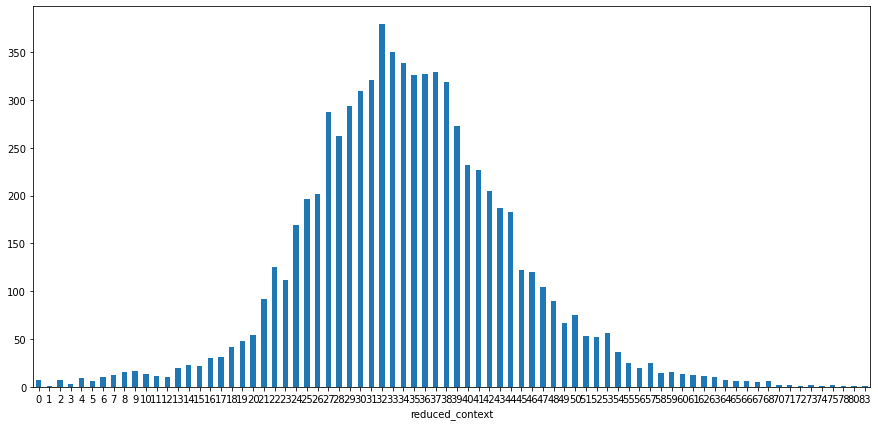

In [107]:
grouped = dev_coref_fuzzy_joint_df.groupby(dev_coref_fuzzy_joint_df['reduced_context'].map(lambda x: list(flatten(x)) ).str.len())
num_of_context_sentences = grouped.size()  # count of each  

# distribution of number of context sentences
plot = num_of_context_sentences.plot(kind = 'bar', figsize=(15, 7))
plt.xticks(rotation=0)                                    # show label text horizontally 
plt.show() 

In [108]:
dev_coref_fuzzy_joint_df['reduced_context_joint'] = dev_coref_fuzzy_joint_df['reduced_context'].map(lambda x: " ".join(list(flatten(x)) ))
dev_coref_fuzzy_joint_df['reduced_context_joint'] = dev_coref_fuzzy_joint_df['reduced_context_joint'].map(_normalize_text)  

dev_coref_fuzzy_joint_df['num_reduced_context_words'] = dev_coref_fuzzy_joint_df.reduced_context_joint.str.split(' ').str.len()

dev_coref_fuzzy_joint_df['reduced_context_word_ratio'] = dev_coref_fuzzy_joint_df.apply(lambda row: row['num_reduced_context_words'] / row['num_context_words'] , axis = 1)
dev_coref_fuzzy_joint_df['reduced_context_word_ratio'].describe()

count    7405.000000
mean        0.666748
std         0.163727
min         0.000934
25%         0.566826
50%         0.685286
75%         0.786421
max         1.000000
Name: reduced_context_word_ratio, dtype: float64

In [109]:
dev_coref_fuzzy_joint_df['reduced_context_sent_ratio'] = dev_coref_fuzzy_joint_df.apply(lambda row:  len(list(flatten(row['reduced_context']))) / len(list(flatten(row['context']))), axis = 1)

dev_coref_fuzzy_joint_df['reduced_context_sent_ratio'].describe()

count    7405.000000
mean        0.680459
std         0.149893
min         0.000000
25%         0.595238
50%         0.696970
75%         0.787879
max         1.000000
Name: reduced_context_sent_ratio, dtype: float64

#### Examples

##### Example 1

In [110]:
dev_coref_fuzzy_joint_df.loc[dev_coref_fuzzy_joint_df['introduced_phrases'].str.len() == 8]

,_id,question,answer,level,type,context,supporting_facts,reduced_context,supporting_facts_reduced_context,question_phrases,paras_phrases,common_phrases,Steiner_tree_phrase,Steiner_tree,question_only_phrase,extended_phrases,kept_para_sent,normalized_answer_in_context,num_context_words,introduced_phrases,has_introduced_phrases,reduced_context_joint,num_reduced_context_words,reduced_context_word_ratio,reduced_context_sent_ratio
607,5ae533535542993aec5ec173,Watercliffe Meadow Primary Schools name change...,political correctness,hard,bridge,"[[G-LOC, [G-force induced loss of consciousnes...","[[Watercliffe Meadow Community Primary School,...","[[G-LOC, [G-force induced loss of consciousnes...","[[Watercliffe Meadow Community Primary School,...",[watercliffe meadow primary school name change...,"[[[['gloc', 0.471404520791031]], [['loss', 0.1...","[watercliffe meadow, change, language, example...","[yoruba, population, watercliffe meadow, force...","{'directed': False, 'multigraph': False, 'grap...",[watercliffe meadow primary school name change...,"[yoruba, population, watercliffe meadow, force...","[[0], [0, 1, 2], [3], [0, 1], [0, 2, 3, 4, 5],...",True,779,"{yoruba, okun, force, workforce, political cor...",True,gloc gforce induced loss of consciousness abbr...,593,0.761232,0.733333


In [111]:
example = dev_coref_fuzzy_joint_df.loc[dev_coref_fuzzy_joint_df._id == '5ae533535542993aec5ec173'].iloc[0]

In [112]:
example.question

'Watercliffe Meadow Primary Schools name change is an example of what term generally used to describe the avoidance of certain language?'

In [113]:
question_phrases = example.question_phrases
question_phrases

['watercliffe meadow primary school name change',
 'watercliffe meadow',
 'certain language',
 'avoidance',
 'change',
 'term',
 'example',
 'language']

In [114]:
example.answer

'political correctness'

In [115]:
example.paras_phrases

[[[['gloc', 0.471404520791031]],
  [['loss', 0.125206197850984],
   ['consciousness', 0.12407886041355701],
   ['aerospace physiology', 0.11943288909316101],
   ['cerebral hypoxia', 0.10870990958053801],
   ['brain', 0.10308876416010301],
   ['blood', 0.10041670168753901],
   ['gforce', 0.10017772241368901],
   ['term', 0.092864032717237],
   ['jeelock', 0.09263267496798301],
   ['physiology', 0.09156319859676901],
   ['gloc', 0.091360232749863],
   ['excessive sustained gforce', 0.088159972266156],
   ['hypoxia', 0.083684927413205]],
  [['high performance fighter', 0.18112813669320402],
   ['aerobatic aircraft', 0.153940722935482],
   ['extreme amusement park ride', 0.128310880573537],
   ['fighter', 0.12388734818022501],
   ['pilot', 0.12334981950482601],
   ['ride', 0.11567483905036001],
   ['astronaut', 0.11380058232767701],
   ['aircraft', 0.111160297342173],
   ['condition', 0.09529381198943501]],
  [['high performance aircraft', 0.21863832436719402],
   ['high g', 0.209249041894

In [116]:
example.common_phrases

['watercliffe meadow', 'change', 'language', 'example', 'term', 'avoidance']

In [117]:
example.question_only_phrase

['watercliffe meadow primary school name change', 'certain language']

In [118]:
example.Steiner_tree

{'directed': False,
 'multigraph': False,
 'graph': {},
 'nodes': [{'score': 0.126127563506006, 'id': 'yoruba'},
  {'score': 0.086794232934206, 'id': 'population'},
  {'score': 0.234797226405346, 'id': 'watercliffe meadow'},
  {'score': 0.146230357988744, 'id': 'force'},
  {'score': 0.07369745292753101, 'id': 'okun'},
  {'score': 0.163540069556111, 'id': 'change'},
  {'score': 0.07951643375275001, 'id': 'place'},
  {'score': 0.156814217709376, 'id': 'language'},
  {'score': 0.102298257470619, 'id': 'example'},
  {'score': 0.433012701892219, 'id': 'political correctness'},
  {'score': 0.09609187734265401, 'id': 'correctness'},
  {'score': 0.19915287788985903, 'id': 'term'},
  {'score': 0.09012706060538901, 'id': 'avoidance'},
  {'score': 0.19209085923539101, 'id': 'workforce'}],
 'links': [{'src': [[9, 1]], 'source': 'yoruba', 'target': 'term'},
  {'src': [[9, 3]], 'source': 'yoruba', 'target': 'language'},
  {'src': [[9, 1], [9, 3]], 'source': 'yoruba', 'target': 'okun'},
  {'src': [[4

nodes to draw ['yoruba', 'population', 'watercliffe meadow', 'force', 'okun', 'change', 'place', 'language', 'example', 'political correctness', 'correctness', 'term', 'avoidance', 'workforce']


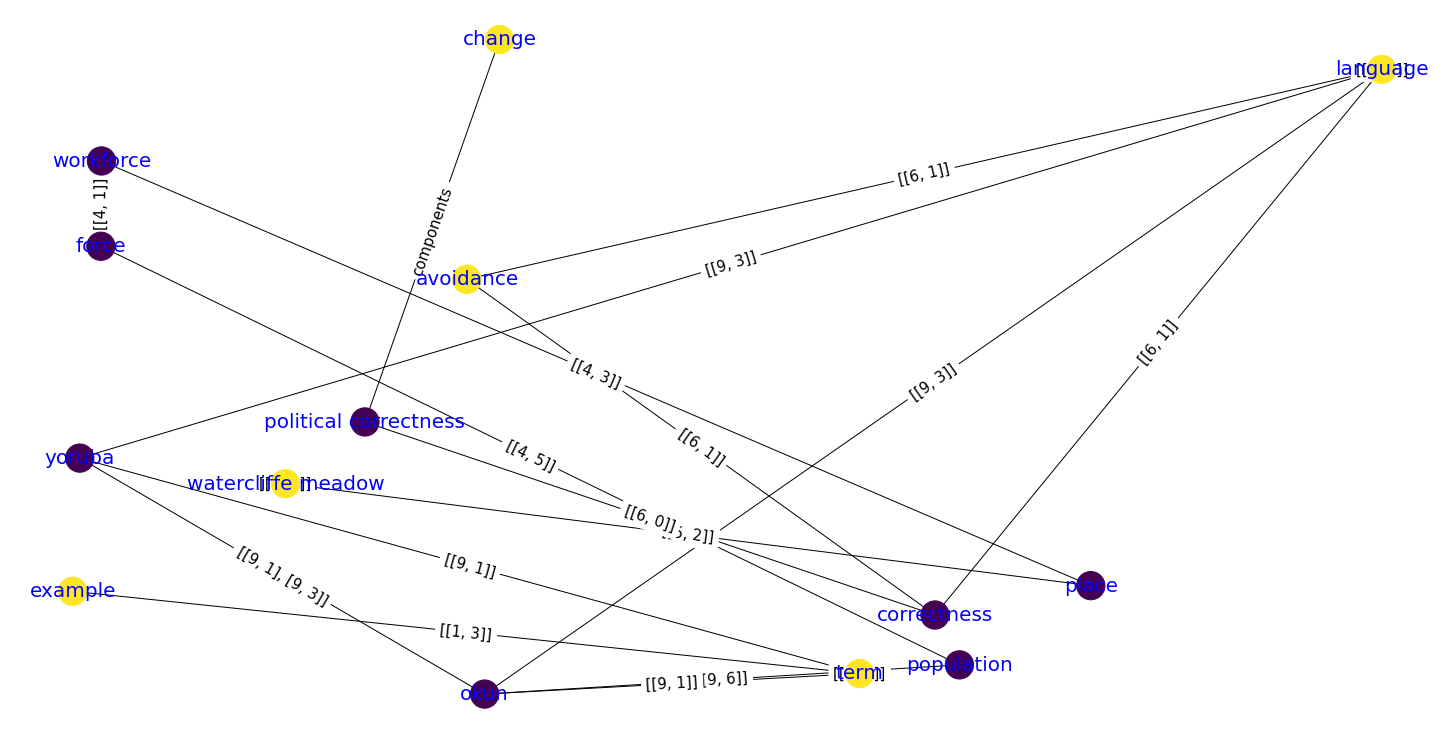

In [119]:
Steiner_tree = json_graph.node_link_graph(example.Steiner_tree)
vis_graph(Steiner_tree, Steiner_tree.nodes(), question_phrases)

In [120]:
example.introduced_phrases

{'correctness',
 'force',
 'okun',
 'place',
 'political correctness',
 'population',
 'workforce',
 'yoruba'}

In [121]:
example.extended_phrases

(yoruba, term, {'src': [[9, 1]]})
(yoruba, language, {'src': [[9, 3]]})
(yoruba, okun, {'src': [[9, 1], [9, 3]]})
(population, force, {'src': [[4, 5]]})
(population, okun, {'src': [[9, 6]]})
(watercliffe meadow, watercliffe meadow, {'src': [[5, 2]]})
(watercliffe meadow, place, {'src': [[5, 2]]})
(force, population, {'src': [[4, 5]]})
(force, workforce, {'src': [[4, 1]]})
(okun, yoruba, {'src': [[9, 1], [9, 3]]})
(okun, population, {'src': [[9, 6]]})
(okun, term, {'src': [[9, 1]]})
(okun, language, {'src': [[9, 3]]})
(change, political correctness, {'src': 'components'})
(place, watercliffe meadow, {'src': [[5, 2]]})
(place, workforce, {'src': [[4, 3]]})
(language, yoruba, {'src': [[9, 3]]})
(language, okun, {'src': [[9, 3]]})
(language, correctness, {'src': [[6, 1]]})
(language, avoidance, {'src': [[6, 1]]})
(language, language, {'src': [[9, 3]]})
(example, term, {'src': [[1, 3]]})
(political correctness, change, {'src': 'components'})
(political correctness, correctness, {'src': [[6,

['yoruba',
 'population',
 'watercliffe meadow',
 'force',
 'okun',
 'change',
 'place',
 'language',
 'example',
 'political correctness',
 'correctness',
 'term',
 'avoidance',
 'workforce',
 'watercliffe meadow primary school name change',
 'certain language']

In [122]:
example.reduced_context_word_ratio

0.7612323491655969

In [123]:
example.reduced_context_sent_ratio

0.7333333333333333

In [124]:
example.supporting_facts

[['Watercliffe Meadow Community Primary School', 2],
 ['Political correctness', 0]]

In [125]:
example.supporting_facts_reduced_context

[['Watercliffe Meadow Community Primary School', 2],
 ['Political correctness', 0]]

In [126]:
list(enumerate(example.context))

[(0,
  ['G-LOC',
   ["G-force induced loss of consciousness (abbreviated as G-LOC, pronounced 'JEE-lock') is a term generally used in aerospace physiology to describe a loss of consciousness occurring from excessive and sustained g-forces draining blood away from the brain causing cerebral hypoxia.",
    ' The condition is most likely to affect pilots of high performance fighter and aerobatic aircraft or astronauts but is possible on some extreme amusement park rides.',
    ' G-LOC incidents have caused fatal accidents in high performance aircraft capable of sustaining high "g" for extended periods.',
    ' High-G training for pilots of high performance aircraft or spacecraft often includes ground training for G-LOC in special centrifuges, with some profiles exposing pilots to 9 "g"s for a sustained period.']]),
 (1,
  ['Big government',
   ['Big government is a term generally used by conservatives and libertarians to describe a government or public sector that they consider to be exce

In [128]:
list(enumerate(example.paras_phrases[5]))

[(0,
  [['watercliffe meadow community primary school', 0.34992710611188205],
   ['school', 0.194465435759403]]),
 (1,
  [['watercliffe meadow community primary school', 0.27336296038213903],
   ['primary school', 0.254445300820062],
   ['sheffield south yorkshire england', 0.23265585689353302],
   ['school', 0.19598021019637601],
   ['sheffield', 0.16462573614297302],
   ['england', 0.13548232212267802]]),
 (2,
  [['watercliffe meadow community primary school name', 0.234797226405346],
   ['watercliffe meadow community primary school', 0.22850645685326001],
   ['watercliffe meadow', 0.185049130461366],
   ['school', 0.16226870043764302],
   ['meadow', 0.14728852894497502],
   ['january 2009', 0.12457135606785501],
   ['negative connotation', 0.11851522329566401],
   ['staff', 0.10206770003527901],
   ['pupil', 0.09715997831820801],
   ['january', 0.095895074612124],
   ['connotation', 0.087734519947367],
   ['name', 0.086484945974571],
   ['place', 0.07951643375275001],
   ['parent', 

In [129]:
example.context

[['G-LOC',
  ["G-force induced loss of consciousness (abbreviated as G-LOC, pronounced 'JEE-lock') is a term generally used in aerospace physiology to describe a loss of consciousness occurring from excessive and sustained g-forces draining blood away from the brain causing cerebral hypoxia.",
   ' The condition is most likely to affect pilots of high performance fighter and aerobatic aircraft or astronauts but is possible on some extreme amusement park rides.',
   ' G-LOC incidents have caused fatal accidents in high performance aircraft capable of sustaining high "g" for extended periods.',
   ' High-G training for pilots of high performance aircraft or spacecraft often includes ground training for G-LOC in special centrifuges, with some profiles exposing pilots to 9 "g"s for a sustained period.']],
 ['Big government',
  ['Big government is a term generally used by conservatives and libertarians to describe a government or public sector that they consider to be excessively large and 

In [130]:
example.reduced_context

[['G-LOC',
  ["G-force induced loss of consciousness (abbreviated as G-LOC, pronounced 'JEE-lock') is a term generally used in aerospace physiology to describe a loss of consciousness occurring from excessive and sustained g-forces draining blood away from the brain causing cerebral hypoxia."]],
 ['Big government',
  ['Big government is a term generally used by conservatives and libertarians to describe a government or public sector that they consider to be excessively large and involved in certain areas of public policy or the private sector.',
   ' The term may also be used specifically in relation to government policies that attempt to regulate matters considered to be private or personal, such as private sexual behavior or individual food choices.',
   ' The term has also been used to define a dominant federal government that seeks to control the authority of local institutions - an example being the overriding of state authority in favor of federal legislation.']],
 ['Parkwood Aca

##### Example 2

In [131]:
example = dev_coref_fuzzy_joint_df.loc[dev_coref_fuzzy_joint_df._id == '5a85ea095542994775f606a8'].iloc[0]

In [132]:
example.question

'What science fantasy young adult series, told in first person, has a set of companion books narrating the stories of enslaved worlds and alien species?'

In [133]:
question_phrases = example.question_phrases
question_phrases

['science fantasy young adult series',
 'enslave world',
 'companion book',
 'first person',
 'alien specie',
 'story',
 'series',
 'world',
 'book',
 'first',
 'person',
 'specie']

In [134]:
example.answer

'animorphs'

In [135]:
example.paras_phrases

[[[['andre norton award', 0.4],
   ['andre norton', 0.353553390593273],
   ['award', 0.272165526975908]],
  [['young adult science fiction', 0.20207993800850202],
   ['science fiction', 0.17738058729535702],
   ['fantasy book', 0.14936855918612701],
   ['fantasy writer', 0.148624098013129],
   ['good young adult middle grade science fiction', 0.147582100234236],
   ['fiction', 0.13956503596177602],
   ['fantasy', 0.136953666362844],
   ['united states', 0.125756161049962],
   ['andre norton award', 0.119898440826582],
   ['america sfwa', 0.108895006226722],
   ['precede year', 0.10642617282274],
   ['annual award', 0.104028911133167],
   ['andre norton', 0.09951162851561],
   ['states', 0.098429621404333],
   ['author', 0.088921727818668],
   ['book', 0.087671661334437],
   ['writer', 0.08615912036820801],
   ['award', 0.08426484847233601],
   ['sfwa', 0.079342871143543],
   ['annual', 0.075667208189912],
   ['year', 0.07516935901638]],
  [['america sfwa young adult fiction committee',

In [136]:
example.common_phrases

['person',
 'companion book',
 'first',
 'world',
 'first person',
 'book',
 'science fantasy young adult series',
 'series',
 'story']

In [137]:
example.question_only_phrase

['enslave world', 'specie', 'alien specie']

In [138]:
example.Steiner_tree

{'directed': False,
 'multigraph': False,
 'graph': {},
 'nodes': [{'score': 0.130336317429259, 'id': 'person'},
  {'score': 0.19053992950967902, 'id': 'companion book'},
  {'score': 0.128976214200933, 'id': 'publication'},
  {'score': 0.16556207501316703, 'id': 'first'},
  {'score': 0.17443690000646903, 'id': 'world'},
  {'score': 0.15960092259385, 'id': 'first person'},
  {'score': 0.102415577800848, 'id': 'book'},
  {'score': 0.10738302510908201, 'id': 'science fantasy young adult series'},
  {'score': 0.082394220470237, 'id': 'series'},
  {'score': 0.12305939181872601, 'id': 'story'}],
 'links': [{'src': [[8, 2]], 'source': 'person', 'target': 'book'},
  {'src': [[8, 2]], 'source': 'person', 'target': 'first person'},
  {'src': [[8, 2]], 'source': 'person', 'target': 'first'},
  {'src': [[5, 3]], 'source': 'companion book', 'target': 'book'},
  {'src': [[5, 6]], 'source': 'companion book', 'target': 'publication'},
  {'src': [[5, 2]], 'source': 'companion book', 'target': 'series'}

nodes to draw ['person', 'companion book', 'publication', 'first', 'world', 'first person', 'book', 'science fantasy young adult series', 'series', 'story']


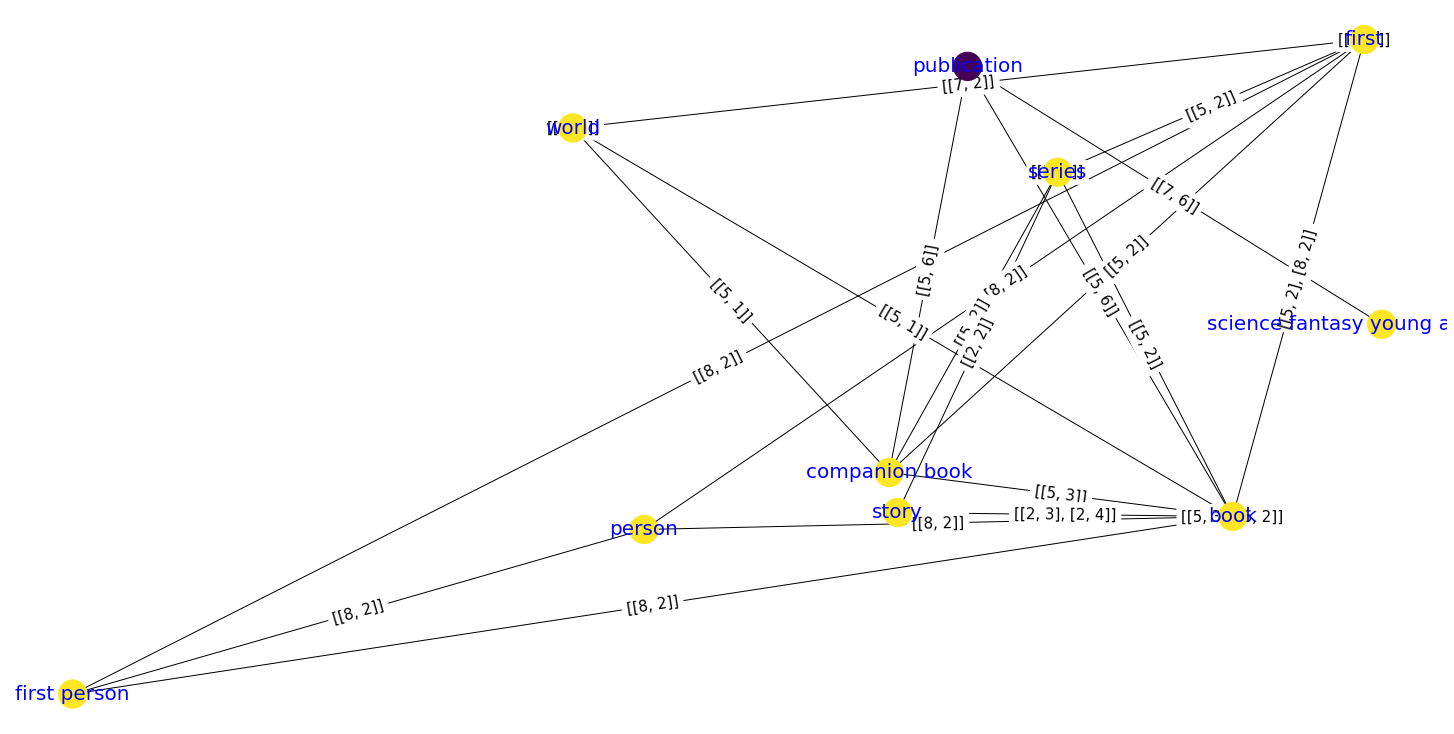

(person, book, {'src': [[8, 2]]})
(person, first person, {'src': [[8, 2]]})
(person, first, {'src': [[8, 2]]})
(companion book, book, {'src': [[5, 3]]})
(companion book, publication, {'src': [[5, 6]]})
(companion book, series, {'src': [[5, 2]]})
(companion book, world, {'src': [[5, 1]]})
(companion book, first, {'src': [[5, 2]]})
(publication, companion book, {'src': [[5, 6]]})
(publication, book, {'src': [[5, 6]]})
(publication, science fantasy young adult series, {'src': [[7, 6]]})
(first, person, {'src': [[8, 2]]})
(first, companion book, {'src': [[5, 2]]})
(first, book, {'src': [[5, 2], [8, 2]]})
(first, series, {'src': [[5, 2]]})
(first, world, {'src': [[7, 2]]})
(first, first, {'src': [[6, 3]]})
(first, first person, {'src': [[8, 2]]})
(world, companion book, {'src': [[5, 1]]})
(world, first, {'src': [[7, 2]]})
(world, book, {'src': [[5, 1]]})
(world, world, {'src': [[7, 2]]})
(first person, person, {'src': [[8, 2]]})
(first person, first, {'src': [[8, 2]]})
(first person, book, 

In [139]:
Steiner_tree = json_graph.node_link_graph(example.Steiner_tree)
vis_graph(Steiner_tree, Steiner_tree.nodes(), question_phrases)

In [140]:
example.introduced_phrases

{'publication'}

In [141]:
example.extended_phrases

['person',
 'companion book',
 'publication',
 'first',
 'world',
 'first person',
 'book',
 'science fantasy young adult series',
 'series',
 'story',
 'enslave world',
 'specie',
 'alien specie']

In [142]:
example.reduced_context_word_ratio

0.7077577045696068

In [143]:
example.reduced_context_sent_ratio

0.7222222222222222

In [144]:
example.supporting_facts

[['The Hork-Bajir Chronicles', 0],
 ['The Hork-Bajir Chronicles', 1],
 ['The Hork-Bajir Chronicles', 2],
 ['Animorphs', 0],
 ['Animorphs', 1]]

In [145]:
example.supporting_facts_reduced_context

[['The Hork-Bajir Chronicles', 0],
 ['The Hork-Bajir Chronicles', 1],
 ['The Hork-Bajir Chronicles', 2],
 ['Animorphs', 0],
 ['Animorphs', 1]]

In [146]:
list(enumerate(example.context))

[(0,
  ['Andre Norton Award',
   ['The Andre Norton Award for Young Adult Science Fiction and Fantasy is an annual award presented by the Science Fiction and Fantasy Writers of America (SFWA) to the author of the best young adult or middle grade science fiction or fantasy book published in the United States in the preceding year.',
    ' It is named to honor prolific science fiction and fantasy author Andre Norton (1912–2005), and it was established by then SFWA president Catherine Asaro and the SFWA Young Adult Fiction committee and announced on February 20, 2005.',
    ' Any published young adult or middle grade science fiction or fantasy novel is eligible for the prize, including graphic novels.',
    ' There is no limit on word count.',
    ' The award is presented along with the Nebula Awards and follows the same rules for nominations and voting; as the awards are separate, works may be simultaneously nominated for both the Andre Norton award and a Nebula Award.']]),
 (1,
  ['Vict

In [147]:
list(enumerate(example.paras_phrases[5]))

[(0,
  [['square enix companion books', 0.34674869767750305],
   ['square enix', 0.30337792881618203],
   ['books', 0.204074964320197],
   ['list', 0.17276216969160202]]),
 (1,
  [['video game developer square game', 0.22531435586383203],
   ['video game developer square', 0.20046196408845401],
   ['artwork developer interview', 0.159478070222344],
   ['square enix companion book', 0.158904430320326],
   ['game', 0.144640738420397],
   ['background information', 0.11708528217735001],
   ['fictional world', 0.111892985490479],
   ['book', 0.108539438158054],
   ['gameplay detail', 0.096503760200445],
   ['information', 0.091358284038366],
   ['square', 0.089592302117036],
   ['interview', 0.08844251036328901],
   ['character', 0.087019609366993],
   ['1998', 0.081865438155813],
   ['world', 0.080845419583569],
   ['dozen', 0.06675228293568],
   ['detail', 0.065322421132861]]),
 (2,
  [['square enix companion book', 0.21227765805002202],
   ['perfect work series', 0.192783513255274],
   

In [148]:
example.context

[['Andre Norton Award',
  ['The Andre Norton Award for Young Adult Science Fiction and Fantasy is an annual award presented by the Science Fiction and Fantasy Writers of America (SFWA) to the author of the best young adult or middle grade science fiction or fantasy book published in the United States in the preceding year.',
   ' It is named to honor prolific science fiction and fantasy author Andre Norton (1912–2005), and it was established by then SFWA president Catherine Asaro and the SFWA Young Adult Fiction committee and announced on February 20, 2005.',
   ' Any published young adult or middle grade science fiction or fantasy novel is eligible for the prize, including graphic novels.',
   ' There is no limit on word count.',
   ' The award is presented along with the Nebula Awards and follows the same rules for nominations and voting; as the awards are separate, works may be simultaneously nominated for both the Andre Norton award and a Nebula Award.']],
 ['Victoria Hanley',
  ['

In [149]:
example.reduced_context

[['Andre Norton Award',
  ['The Andre Norton Award for Young Adult Science Fiction and Fantasy is an annual award presented by the Science Fiction and Fantasy Writers of America (SFWA) to the author of the best young adult or middle grade science fiction or fantasy book published in the United States in the preceding year.']],
 ['Victoria Hanley',
  [' Her first three books, "The Seer And The Sword", "The Healer\'s Keep" and "The Light Of The Oracle" are companion books to one another.',
   ' Her newest book (released March 2012) is the sequel of a series, called "Indigo Magic", published by Egmont USA.',
   ' She\'s also published two non-fiction books through Cotton Wood Press; called "Seize the Story: A Handbook For Teens Who Like To Write", and "Wild Ink: A Grownups Guide To Writing Fiction For Teens".']],
 ['The Hork-Bajir Chronicles',
  ['The Hork-Bajir Chronicles is the second companion book to the "Animorphs" series, written by K. A. Applegate.',
   ' With respect to continuity

##### Example 3

In [150]:
example = dev_coref_fuzzy_joint_df.loc[dev_coref_fuzzy_joint_df.has_introduced_phrases == True].iloc[3] 

In [151]:
example.question

'What screenwriter with credits for "Evolution" co-wrote a film starring Nicolas Cage and Téa Leoni?'

In [152]:
question_phrases = example.question_phrases
question_phrases

['nicolas cage',
 'cage',
 'téa leoni',
 'evolution',
 'credit',
 'leoni',
 'screenwriter']

In [153]:
example.answer

'david weissman'

In [154]:
example.paras_phrases

[[[['ungod', 0.471404520791031]],
  [['american industrial rock band stabbing', 0.23013389238033402],
   ['debut album', 0.17570744008475903],
   ['columbia record', 0.16155617145165002],
   ['album', 0.14289123680856902],
   ['american', 0.142243006020809],
   ['1994', 0.137233733342066],
   ['record', 0.13137823077604402],
   ['stabbing', 0.127715197334571],
   ['columbia', 0.116934014631536],
   ['ungod', 0.107169273673302]],
  [['february 15 1994', 0.200692922425026],
   ['six week', 0.18885230344351703],
   ['chiswick england', 0.18205208517003502],
   ['week', 0.14537857097359402],
   ['february', 0.14357819815064002],
   ['six week 1993', 0.141565717101258],
   ['england', 0.14014376050593602],
   ['album', 0.09794202873247401]],
  [['depeche mode second album', 0.22835947711037302],
   ['adequate album sale', 0.20224217729770902],
   ['album', 0.180294499115902],
   ['wither blister', 0.176421824849799],
   ['second', 0.12925089362275602],
   ['blister', 0.12909521908138802],
 

In [155]:
example.common_phrases

['téa leoni',
 'screenwriter',
 'nicolas cage',
 'leoni',
 'evolution',
 'cage',
 'credit']

In [156]:
example.question_only_phrase

[]

In [157]:
example.Steiner_tree

{'directed': False,
 'multigraph': False,
 'graph': {},
 'nodes': [{'score': 0.14462896281243, 'id': 'credit'},
  {'score': 0.12210128927866701, 'id': 'téa leoni'},
  {'score': 0.285476326729352, 'id': 'screenwriter'},
  {'score': 0.211884556124134, 'id': 'nicolas cage'},
  {'score': 0.15743119954162602, 'id': 'david weissman'},
  {'score': 0.13752038323356902, 'id': 'evolution'},
  {'score': 0.14457906793567302, 'id': 'soundtrack'},
  {'score': 0.184742380814882, 'id': 'cage'},
  {'score': 0.08606325897966201, 'id': 'leoni'}],
 'links': [{'src': [[0, 7]], 'source': 'credit', 'target': 'soundtrack'},
  {'src': [[3, 2]], 'source': 'credit', 'target': 'evolution'},
  {'src': [[3, 2]], 'source': 'credit', 'target': 'david weissman'},
  {'src': [[0, 6]], 'source': 'téa leoni', 'target': 'soundtrack'},
  {'src': [[0, 6], [9, 1]], 'source': 'téa leoni', 'target': 'leoni'},
  {'src': [[9, 1]], 'source': 'téa leoni', 'target': 'david weissman'},
  {'src': [[9, 1]], 'source': 'téa leoni', 'targ

nodes to draw ['credit', 'téa leoni', 'screenwriter', 'nicolas cage', 'david weissman', 'evolution', 'soundtrack', 'cage', 'leoni']


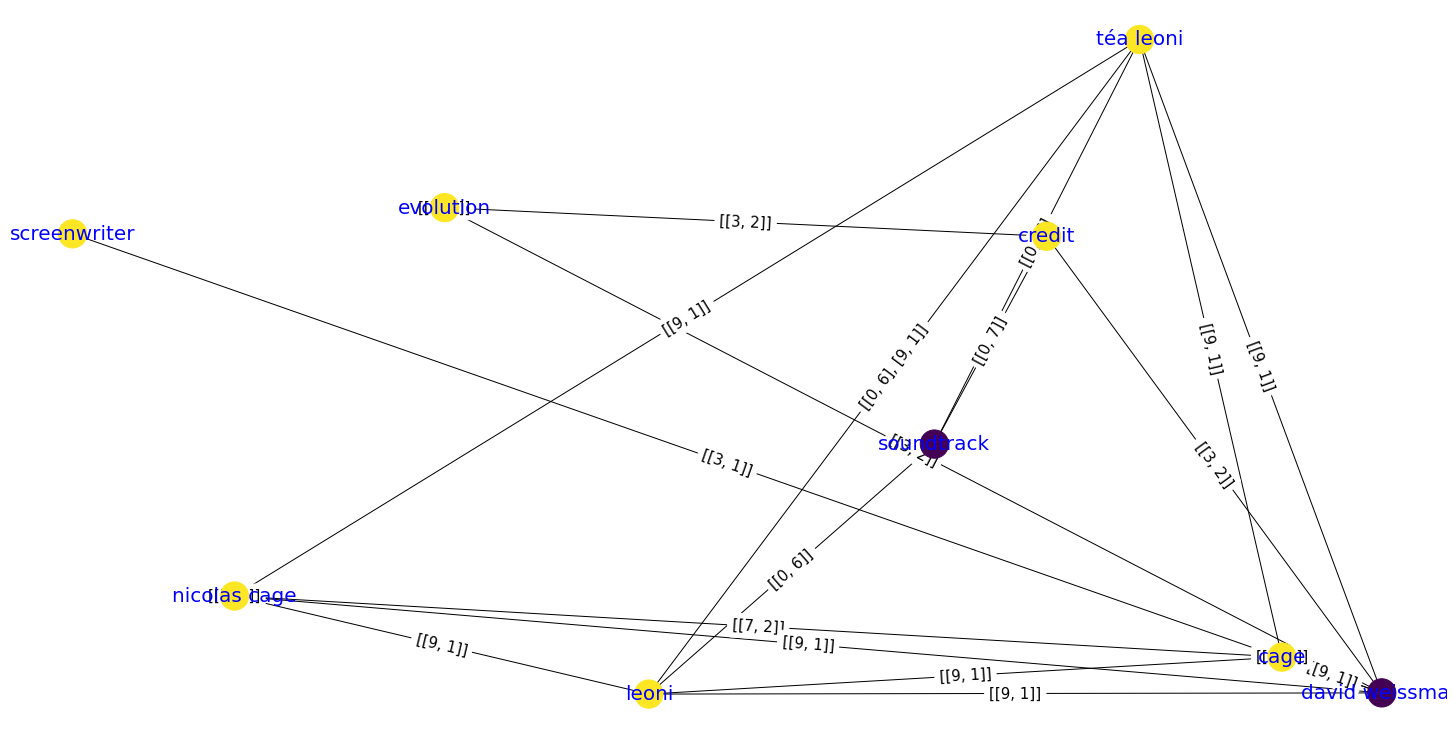

(credit, soundtrack, {'src': [[0, 7]]})
(credit, evolution, {'src': [[3, 2]]})
(credit, david weissman, {'src': [[3, 2]]})
(téa leoni, soundtrack, {'src': [[0, 6]]})
(téa leoni, leoni, {'src': [[0, 6], [9, 1]]})
(téa leoni, david weissman, {'src': [[9, 1]]})
(téa leoni, nicolas cage, {'src': [[9, 1]]})
(téa leoni, cage, {'src': [[9, 1]]})
(screenwriter, david weissman, {'src': [[3, 1]]})
(nicolas cage, téa leoni, {'src': [[9, 1]]})
(nicolas cage, leoni, {'src': [[9, 1]]})
(nicolas cage, cage, {'src': [[7, 2]]})
(nicolas cage, nicolas cage, {'src': [[7, 2]]})
(nicolas cage, david weissman, {'src': [[9, 1]]})
(david weissman, credit, {'src': [[3, 2]]})
(david weissman, téa leoni, {'src': [[9, 1]]})
(david weissman, screenwriter, {'src': [[3, 1]]})
(david weissman, nicolas cage, {'src': [[9, 1]]})
(david weissman, leoni, {'src': [[9, 1]]})
(david weissman, cage, {'src': [[9, 1]]})
(david weissman, evolution, {'src': [[3, 2]]})
(evolution, credit, {'src': [[3, 2]]})
(evolution, david weiss

In [158]:
Steiner_tree = json_graph.node_link_graph(example.Steiner_tree)
vis_graph(Steiner_tree, Steiner_tree.nodes(), question_phrases)

In [159]:
example.introduced_phrases

{'david weissman', 'soundtrack'}

In [160]:
example.extended_phrases

['téa leoni',
 'screenwriter',
 'nicolas cage',
 'cage',
 'leoni',
 'evolution',
 'soundtrack',
 'david weissman',
 'credit']

In [161]:
example.reduced_context_word_ratio

0.6078167115902965

In [162]:
example.reduced_context_sent_ratio

0.62

In [163]:
example.supporting_facts

[['David Weissman', 0], ['David Weissman', 1], ['The Family Man', 0]]

In [164]:
example.supporting_facts_reduced_context

[['David Weissman', 0], ['David Weissman', 1], ['The Family Man', 0]]

In [165]:
list(enumerate(example.context))

[(0,
  ['Ungod',
   ['Ungod is the debut album released in 1994 on Columbia Records by the American industrial rock band Stabbing Westward.',
    ' The album was recorded in six weeks of 1993 in Chiswick, England, and released on February 15, 1994.',
    ' With adequate album sales and touring with the likes of Depeche Mode a second album was warranted, "Wither Blister Burn & Peel".',
    ' The guitar line in the chorus of the song "Ungod" was later used in Filter\'s song "Hey Man, Nice Shot."',
    ' Stuart Zechman, who was also playing guitar for Filter at the time, took the riff and showed it to Stabbing Westward who ended up using it as well.',
    ' The song "Nothing" appeared in the "Bad Boys" movie starring Will Smith, Martin Lawrence and Téa Leoni, but was not featured on the official soundtrack album.',
    ' The song also accompanied the credits of the film "Johnny Mnemonic" and was included on the film\'s soundtrack, along with the song "Lost".',
    ' "Lost", "Lies" and "Ca

In [166]:
list(enumerate(example.paras_phrases[5]))

[(0,
  [['60 second 2000 film', 0.34674869767750305],
   ['60 second', 0.30337792881618203],
   ['film', 0.204074964320197],
   ['2000', 0.204074964320197]]),
 (1,
  [['christopher eccleston robert duvall vinnie jones', 0.18033684961874302],
   ['2000 american action heist film', 0.177970199576572],
   ['duvall vinnie jones', 0.16235871335184401],
   ['american action heist', 0.156011621061715],
   ['nicolas cage angelina', 0.137617232771439],
   ['jolie giovanni', 0.13011542019823502],
   ['60 second', 0.12400724307202901],
   ['jones', 0.11182327443202901],
   ['film', 0.11102955943532601],
   ['will patton', 0.10940363018867101],
   ['2000', 0.106530473921376],
   ['second', 0.10055969028271801],
   ['giovanni', 0.100162897169563],
   ['angelina', 0.083256112212493],
   ['patton', 0.077207358775277],
   ['ribisi', 0.038792923264560006]]),
 (2,
  [['1974 hb halicki film', 0.16064455063108501],
   ['jerry bruckheimer producer', 0.13750275355171301],
   ['dominic sena', 0.1257329671102

In [167]:
example.context

[['Ungod',
  ['Ungod is the debut album released in 1994 on Columbia Records by the American industrial rock band Stabbing Westward.',
   ' The album was recorded in six weeks of 1993 in Chiswick, England, and released on February 15, 1994.',
   ' With adequate album sales and touring with the likes of Depeche Mode a second album was warranted, "Wither Blister Burn & Peel".',
   ' The guitar line in the chorus of the song "Ungod" was later used in Filter\'s song "Hey Man, Nice Shot."',
   ' Stuart Zechman, who was also playing guitar for Filter at the time, took the riff and showed it to Stabbing Westward who ended up using it as well.',
   ' The song "Nothing" appeared in the "Bad Boys" movie starring Will Smith, Martin Lawrence and Téa Leoni, but was not featured on the official soundtrack album.',
   ' The song also accompanied the credits of the film "Johnny Mnemonic" and was included on the film\'s soundtrack, along with the song "Lost".',
   ' "Lost", "Lies" and "Can\'t Happen He

In [168]:
example.reduced_context

[['Ungod',
  [' The song "Nothing" appeared in the "Bad Boys" movie starring Will Smith, Martin Lawrence and Téa Leoni, but was not featured on the official soundtrack album.',
   ' The song also accompanied the credits of the film "Johnny Mnemonic" and was included on the film\'s soundtrack, along with the song "Lost".',
   ' "Lost", "Lies" and "Can\'t Happen Here" were used in the film "Mortal Kombat", but Stabbing Westward refused to include it in the official soundtrack.',
   ' The "Thread Mix" of "Violent Mood Swings" was included in the Clerks soundtrack.']],
 ['Season of the Witch (2011 film)',
  ['Season of the Witch is a 2011 American historical fantasy adventure film starring Nicolas Cage and Ron Perlman and directed by Dominic Sena with extensive uncredited reshoots by Brett Ratner.',
   ' Cage and Perlman star as Teutonic Knights, who return from the Crusades to find their fatherland ruined by the Black Death.',
   ' It reunited Sena and Cage who had previously worked toget

#### answer

In [169]:
dev_coref_fuzzy_joint_df['normalized_answer_in_reduced_context'] = dev_coref_fuzzy_joint_df.apply(lambda row:  findWord(row['answer'], row['reduced_context_joint']) == True , axis = 1)

In [170]:
dev_coref_fuzzy_joint_df.normalized_answer_in_reduced_context.value_counts()

True     6477
False     928
Name: normalized_answer_in_reduced_context, dtype: int64

In [171]:
# dev_coref_fuzzy_joint_df.loc[(dev_coref_fuzzy_joint_df.reduced_context.str.len() > 0) & ((dev_coref_fuzzy_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_coref_fuzzy_joint_df['answer'] == 'yes') | (dev_coref_fuzzy_joint_df['answer'] == 'no')) ].shape[0]

##### Outliers

In [172]:
dev_coref_fuzzy_outliers = dev_coref_fuzzy_joint_df.loc[( dev_coref_fuzzy_joint_df.normalized_answer_in_context == True) &(dev_coref_fuzzy_joint_df.normalized_answer_in_reduced_context == False) & (dev_coref_fuzzy_joint_df['answer'] != 'yes') & (dev_coref_fuzzy_joint_df['answer'] != 'no') & (dev_coref_fuzzy_joint_df['answer'] != '')]

dev_coref_fuzzy_outliers.shape[0]

710

###### Outlier 1

In [173]:
print(dev_coref_fuzzy_outliers.iloc[1]._id)
dev_coref_fuzzy_outliers.iloc[1].question

5a74106b55429979e288289e


'Where is the company that Sachin Warrier worked for as a software engineer headquartered? '

In [174]:
question_phrases = dev_coref_fuzzy_outliers.iloc[1].question_phrases
question_phrases

['sachin warrier', 'software engineer', 'company', 'warrier', 'engineer']

The pharse extraction is not perfect, *'hedgehog'* should be extract

In [175]:
dev_coref_fuzzy_outliers.iloc[1].paras_phrases

[[[['lead programmer', 0.433012701892219],
   ['programmer', 0.33333333333333304]],
  [['software engineer', 0.26306308406412504],
   ['lead programmer', 0.193787887292161],
   ['one more software project', 0.19013194545987203],
   ['programmer', 0.161557701137396],
   ['engineer', 0.160139720910587],
   ['one', 0.160139720910587],
   ['charge', 0.159824281890803],
   ['project', 0.135673327278962]],
  [['development lead technical lead lead software engineer software design engineer lead sde lead software development manager software manager',
    0.274418958212418],
   ['lead application developer', 0.152496028653641],
   ['manager', 0.125557369976789],
   ['title', 0.09687830475181],
   ['developer', 0.076484550072348],
   ['alternative title', 0.07045237697788201]],
  [['design role', 0.184232697324399], ['role', 0.14182096097736702]]],
 [[['sachin bansal', 0.433012701892219], ['bansal', 0.33333333333333304]],
  [['indias ecommerce platform flipkart', 0.180582393597735],
   ['5 aug

In [176]:
dev_coref_fuzzy_outliers.iloc[1].common_phrases

['engineer', 'software engineer', 'sachin warrier', 'warrier']

In [177]:
dev_coref_fuzzy_outliers.iloc[1].Steiner_tree_phrase

['engineer', 'software engineer', 'sachin warrier', 'warrier']

In [178]:
dev_coref_fuzzy_outliers.iloc[1].Steiner_tree

{'directed': False,
 'multigraph': False,
 'graph': {},
 'nodes': [{'score': 0.1223700384461, 'id': 'engineer'},
  {'score': 0.218479252384982, 'id': 'software engineer'},
  {'score': 0.121525449453799, 'id': 'sachin warrier'},
  {'score': 0.093958221164955, 'id': 'warrier'}],
 'links': [{'src': [[1, 1]],
   'source': 'engineer',
   'target': 'software engineer'},
  {'src': [[4, 4]], 'source': 'engineer', 'target': 'sachin warrier'},
  {'src': [[4, 4]], 'source': 'engineer', 'target': 'warrier'},
  {'src': [[4, 4]], 'source': 'software engineer', 'target': 'sachin warrier'},
  {'src': [[4, 4]], 'source': 'software engineer', 'target': 'warrier'},
  {'src': [[4, 0],
    [4, 1],
    [4, 2],
    [4, 3],
    [4, 4],
    [4, 5],
    [4, 6],
    [5, 3],
    [7, 1],
    [9, 9]],
   'source': 'sachin warrier',
   'target': 'warrier'}]}

nodes to draw ['engineer', 'software engineer', 'sachin warrier', 'warrier']


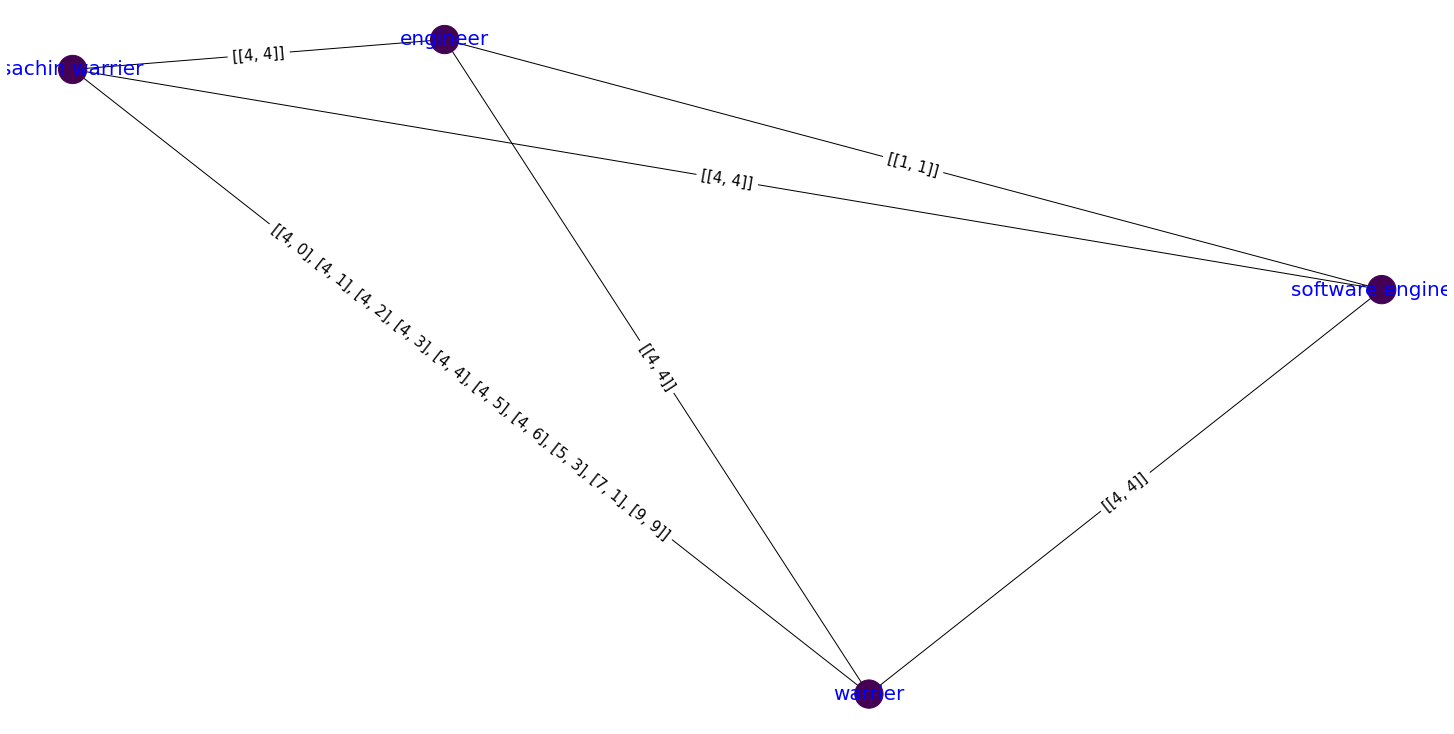

(engineer, software engineer, {'src': [[1, 1]]})
(engineer, sachin warrier, {'src': [[4, 4]]})
(engineer, warrier, {'src': [[4, 4]]})
(software engineer, engineer, {'src': [[1, 1]]})
(software engineer, sachin warrier, {'src': [[4, 4]]})
(software engineer, warrier, {'src': [[4, 4]]})
(sachin warrier, engineer, {'src': [[4, 4]]})
(sachin warrier, software engineer, {'src': [[4, 4]]})
(sachin warrier, warrier, {'src': [[4, 0], [4, 1], [4, 2], [4, 3], [4, 4], [4, 5], [4, 6], [5, 3], [7, 1], [9, 9]]})
(warrier, engineer, {'src': [[4, 4]]})
(warrier, software engineer, {'src': [[4, 4]]})
(warrier, sachin warrier, {'src': [[4, 0], [4, 1], [4, 2], [4, 3], [4, 4], [4, 5], [4, 6], [5, 3], [7, 1], [9, 9]]})


In [179]:
Steiner_tree = json_graph.node_link_graph(dev_coref_fuzzy_outliers.iloc[1].Steiner_tree)
vis_graph(Steiner_tree, Steiner_tree.nodes(), question_phrases)

###### Outlier 2

In [180]:
print(dev_coref_fuzzy_outliers.iloc[2]._id)
dev_coref_fuzzy_outliers.iloc[2].question

5ab96ab755429970cfb8eacd


'Ellie Goulding worked with what other writers on her third studio album, Delirium?'

In [181]:
question_phrases = dev_coref_fuzzy_outliers.iloc[2].question_phrases
question_phrases

['ellie goulding',
 'third',
 'third studio album delirium',
 'delirium',
 'goulding',
 'writer',
 'other writer']

In [182]:
dev_coref_fuzzy_outliers.iloc[2].Steiner_tree_phrase

['third studio album delirium',
 'ellie goulding',
 'delirium',
 'writer',
 'goulding',
 'third']

In [183]:
dev_coref_fuzzy_outliers.iloc[2].common_phrases

['third studio album delirium',
 'writer',
 'goulding',
 'ellie goulding',
 'delirium',
 'third']

In [184]:
dev_coref_fuzzy_outliers.iloc[2].question_only_phrase

['other writer']

In [185]:
dev_coref_fuzzy_outliers.iloc[2].Steiner_tree

{'directed': False,
 'multigraph': False,
 'graph': {},
 'nodes': [{'score': 0.181868009984021, 'id': 'third studio album delirium'},
  {'score': 0.12085741002198001, 'id': 'writer'},
  {'score': 0.11630486650756301, 'id': 'goulding'},
  {'score': 0.18017712773717, 'id': 'ellie goulding'},
  {'score': 0.18305173420168602, 'id': 'delirium'},
  {'score': 0.10863104336772501, 'id': 'third'}],
 'links': [{'src': [[3, 1]],
   'source': 'third studio album delirium',
   'target': 'ellie goulding'},
  {'src': [[2, 4]],
   'source': 'third studio album delirium',
   'target': 'goulding'},
  {'src': [[4, 1], [8, 1]],
   'source': 'third studio album delirium',
   'target': 'writer'},
  {'src': [[7, 1]],
   'source': 'third studio album delirium',
   'target': 'third'},
  {'src': [[5, 1]],
   'source': 'third studio album delirium',
   'target': 'delirium'},
  {'src': [[0, 2], [4, 1], [8, 1]],
   'source': 'writer',
   'target': 'ellie goulding'},
  {'src': [[9, 5]], 'source': 'writer', 'target'

nodes to draw ['third studio album delirium', 'writer', 'goulding', 'ellie goulding', 'delirium', 'third']


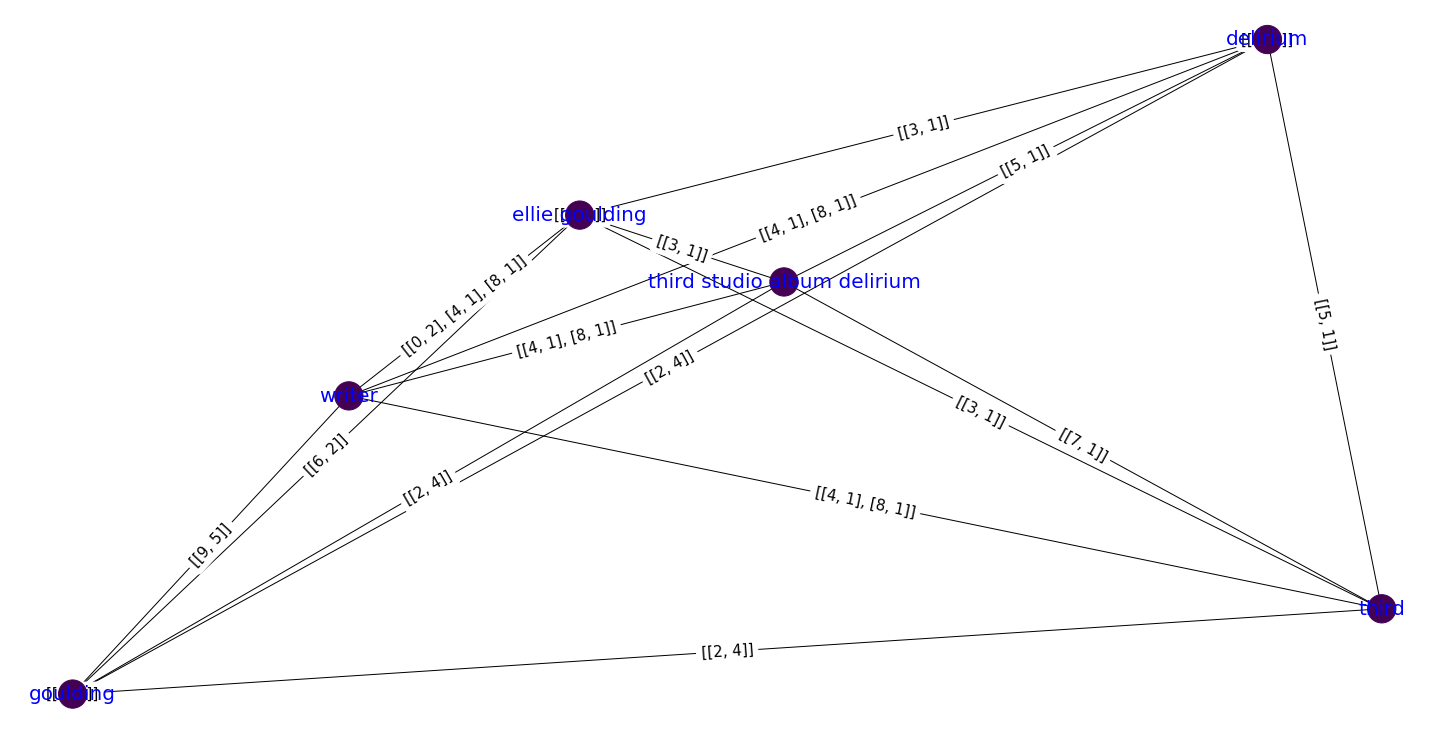

(third studio album delirium, ellie goulding, {'src': [[3, 1]]})
(third studio album delirium, goulding, {'src': [[2, 4]]})
(third studio album delirium, writer, {'src': [[4, 1], [8, 1]]})
(third studio album delirium, third, {'src': [[7, 1]]})
(third studio album delirium, delirium, {'src': [[5, 1]]})
(writer, third studio album delirium, {'src': [[4, 1], [8, 1]]})
(writer, ellie goulding, {'src': [[0, 2], [4, 1], [8, 1]]})
(writer, goulding, {'src': [[9, 5]]})
(writer, third, {'src': [[4, 1], [8, 1]]})
(writer, delirium, {'src': [[4, 1], [8, 1]]})
(goulding, third studio album delirium, {'src': [[2, 4]]})
(goulding, writer, {'src': [[9, 5]]})
(goulding, ellie goulding, {'src': [[6, 2]]})
(goulding, third, {'src': [[2, 4]]})
(goulding, delirium, {'src': [[2, 4]]})
(goulding, goulding, {'src': [[6, 2]]})
(ellie goulding, third studio album delirium, {'src': [[3, 1]]})
(ellie goulding, writer, {'src': [[0, 2], [4, 1], [8, 1]]})
(ellie goulding, goulding, {'src': [[6, 2]]})
(ellie gouldi

In [186]:
Steiner_tree = json_graph.node_link_graph(dev_coref_fuzzy_outliers.iloc[2].Steiner_tree)
vis_graph(Steiner_tree, Steiner_tree.nodes(), question_phrases)

In [187]:
dev_coref_fuzzy_outliers.iloc[2].supporting_facts_reduced_context

[['On My Mind (Ellie Goulding song)', 0],
 ['Delirium (Ellie Goulding album)', 0]]

In [188]:
dev_coref_fuzzy_outliers.iloc[2].supporting_facts

[['Delirium (Ellie Goulding album)', 0],
 ['Delirium (Ellie Goulding album)', 3],
 ['On My Mind (Ellie Goulding song)', 0],
 ['On My Mind (Ellie Goulding song)', 2]]

###### Outlier 3

In [189]:
print(dev_coref_fuzzy_outliers.iloc[3]._id)
dev_coref_fuzzy_outliers.iloc[3].question

5ab659e355429954757d324e


'hree Men on a Horse is a play by a playwright born in which year ?'

In [190]:
question_phrases = dev_coref_fuzzy_outliers.iloc[3].question_phrases
question_phrases

['hree man', 'horse', 'playwright', 'man', 'hree', 'year']

The pharse extraction is not perfect, *'These Boots Are Made for Walkin'* should be extract

In [191]:
dev_coref_fuzzy_outliers.iloc[3].paras_phrases

[[[['sumie tanaka', 0.433012701892219], ['tanaka', 0.33333333333333304]],
  [['1908—march 1 2000', 0.20035594891934802],
   ['april 11', 0.190509037702627],
   ['sumie tanaka 田中澄江', 0.18098319296151202],
   ['japanese screenwriter', 0.169463455336781],
   ['playwright', 0.13605182867003002],
   ['田中澄江', 0.135497651733854],
   ['screenwriter', 0.1320696166228],
   ['japanese', 0.128816154969107],
   ['tokyo', 0.103316049183428]],
  [['japans first major female director kinuyo tanaka', 0.17841446439455702],
   ['1908—march 1 2000 long collaboration', 0.16822314122036303],
   ['1908—march 1 2000', 0.163191507123837],
   ['sumie tanaka 田中澄江', 0.15919213859002102],
   ['film director mikio naruse', 0.14965134727569201],
   ['april 11', 0.148537357683061],
   ['kinuyo tanaka', 0.13306608712071402],
   ['tanaka', 0.12004322132675802],
   ['mikio naruse', 0.10611249944529401],
   ['田中澄江', 0.105266065221949],
   ['japans', 0.096601047849678],
   ['first', 0.09447467661910301],
   ['naruse', 0.0

In [192]:
dev_coref_fuzzy_outliers.iloc[3].Steiner_tree_phrase

['james roland maclaren',
 'lenelle moïse',
 'hree man',
 'man',
 'year',
 'hree',
 'playwright',
 'horse']

In [193]:
dev_coref_fuzzy_outliers.iloc[3].common_phrases

['hree man', 'man', 'year', 'hree', 'playwright', 'horse']

In [194]:
dev_coref_fuzzy_outliers.iloc[3].question_only_phrase

[]

In [195]:
dev_coref_fuzzy_outliers.iloc[3].Steiner_tree

{'directed': False,
 'multigraph': False,
 'graph': {},
 'nodes': [{'score': 0.18994508807787502, 'id': 'james roland maclaren'},
  {'score': 0.10533161607454701, 'id': 'lenelle moïse'},
  {'score': 0.18491418934327303, 'id': 'hree man'},
  {'score': 0.11958865371238901, 'id': 'man'},
  {'score': 0.08394877763614, 'id': 'year'},
  {'score': 0.14234700932576, 'id': 'hree'},
  {'score': 0.127715034614861, 'id': 'playwright'},
  {'score': 0.11334897083235601, 'id': 'horse'}],
 'links': [{'src': [[2, 1]],
   'source': 'james roland maclaren',
   'target': 'playwright'},
  {'src': [[2, 5]], 'source': 'james roland maclaren', 'target': 'year'},
  {'src': [[7, 1]], 'source': 'lenelle moïse', 'target': 'playwright'},
  {'src': [[7, 10]], 'source': 'lenelle moïse', 'target': 'man'},
  {'src': [[3, 0], [3, 1]], 'source': 'hree man', 'target': 'man'},
  {'src': [[3, 0], [3, 1]], 'source': 'hree man', 'target': 'horse'},
  {'src': [[3, 0], [3, 1]], 'source': 'hree man', 'target': 'hree'},
  {'src'

nodes to draw ['james roland maclaren', 'lenelle moïse', 'hree man', 'man', 'year', 'hree', 'playwright', 'horse']


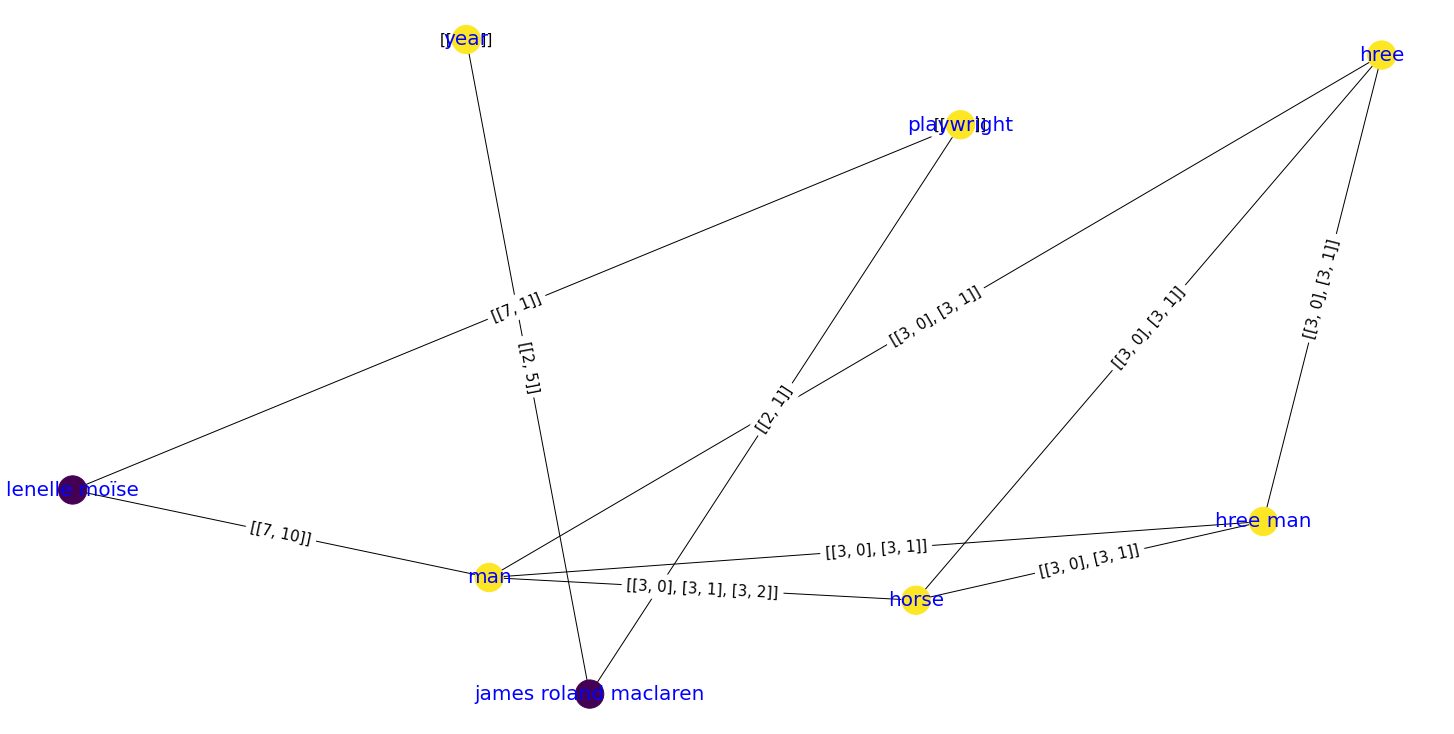

(james roland maclaren, playwright, {'src': [[2, 1]]})
(james roland maclaren, year, {'src': [[2, 5]]})
(lenelle moïse, playwright, {'src': [[7, 1]]})
(lenelle moïse, man, {'src': [[7, 10]]})
(hree man, man, {'src': [[3, 0], [3, 1]]})
(hree man, horse, {'src': [[3, 0], [3, 1]]})
(hree man, hree, {'src': [[3, 0], [3, 1]]})
(man, lenelle moïse, {'src': [[7, 10]]})
(man, hree man, {'src': [[3, 0], [3, 1]]})
(man, horse, {'src': [[3, 0], [3, 1], [3, 2]]})
(man, hree, {'src': [[3, 0], [3, 1]]})
(year, james roland maclaren, {'src': [[2, 5]]})
(year, year, {'src': [[2, 5]]})
(hree, hree man, {'src': [[3, 0], [3, 1]]})
(hree, man, {'src': [[3, 0], [3, 1]]})
(hree, horse, {'src': [[3, 0], [3, 1]]})
(playwright, james roland maclaren, {'src': [[2, 1]]})
(playwright, lenelle moïse, {'src': [[7, 1]]})
(playwright, playwright, {'src': [[5, 1]]})
(horse, hree man, {'src': [[3, 0], [3, 1]]})
(horse, man, {'src': [[3, 0], [3, 1], [3, 2]]})
(horse, hree, {'src': [[3, 0], [3, 1]]})


In [196]:
Steiner_tree = json_graph.node_link_graph(dev_coref_fuzzy_outliers.iloc[3].Steiner_tree)
vis_graph(Steiner_tree, Steiner_tree.nodes(), question_phrases)

In [197]:
dev_coref_fuzzy_outliers.iloc[3].supporting_facts_reduced_context

[['Three Men on a Horse', 0]]

In [198]:
dev_coref_fuzzy_outliers.iloc[3].supporting_facts

[['Three Men on a Horse', 0], ['George Abbott', 0]]

#### supporting facts

In [199]:
# Distribution of number of supporting facts in reduced_context
dev_coref_fuzzy_joint_df['num_of_sp_in_reduced_context'] = dev_coref_fuzzy_joint_df['supporting_facts_reduced_context'].map(lambda x: len(x))
grouped = dev_coref_fuzzy_joint_df.groupby(['num_of_sp_in_reduced_context'])
num_of_sp_in_reduced_context_counts = grouped.size()  # count of each 
num_of_sp_in_reduced_context_counts

num_of_sp_in_reduced_context
0      69
1     870
2    4635
3    1432
4     351
5      37
6       8
7       2
8       1
dtype: int64

In [200]:
# for questions whose answer in reduced_context, the ratio of supporting facts remained in the reduced context
dev_coref_fuzzy_joint_df.loc[(dev_coref_fuzzy_joint_df.reduced_context.str.len() > 0) & ((dev_coref_fuzzy_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_coref_fuzzy_joint_df['answer'] == 'yes') | (dev_coref_fuzzy_joint_df['answer'] == 'no'))].apply(lambda row: len(row['supporting_facts_reduced_context']) / len(row['supporting_facts'])  , axis=1).head(10)

0    0.5
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    0.5
dtype: float64

In [201]:
# ratio of supporting facts remained in the reduced context 
dev_coref_fuzzy_joint_df['sp_in_reduced_context_ratio'] = dev_coref_fuzzy_joint_df.apply(lambda row: len(row['supporting_facts_reduced_context']) / len(row['supporting_facts'])  , axis=1)

#dev_joint_df['sp_in_reduced_context'].map(lambda x: sum(x) / len(x)) 
dev_coref_fuzzy_joint_df['sp_in_reduced_context_ratio'].describe()

count    7405.000000
mean        0.899228
std         0.203988
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: sp_in_reduced_context_ratio, dtype: float64

In [202]:
# reduced_context contains the answer, even though does not contain any supporting fact
dev_coref_fuzzy_joint_df.loc[(dev_coref_fuzzy_joint_df.num_of_sp_in_reduced_context == 0) & (dev_coref_fuzzy_joint_df.normalized_answer_in_reduced_context == True)].shape[0]

7

In [203]:
# map sp from id to text
dev_coref_fuzzy_joint_df['sp_text_reduced_context'] = dev_coref_fuzzy_joint_df.apply(lambda row: [_normalize_text(dict(row['reduced_context'])[sp_t][sp_idx]) for (sp_t, sp_idx) in row['supporting_facts_reduced_context'] if(sp_idx < len(dict(row['reduced_context'])[sp_t])) ], axis = 1)

dev_coref_fuzzy_joint_df['sp_text_reduced_context']  

0       [scott derrickson born july 16 1966 is america...
1       [shirley temple black april 23 1928 – february...
2       [horkbajir chronicles is second companion book...
3       [laleli mosque turkish laleli camii or tulip m...
4       [adriana trigiani is italian american bestsell...
                              ...                        
7400    [coke kahani urdu کوک کہانی‎ is 2012 pakistani...
7401    [canfields diet chocolate fudge soda is zeroca...
7402    [billy is large scenthound originating from ce...
7403    [dig is american alternative rock band from lo...
7404    [analog devices inc also known as adi or analo...
Name: sp_text_reduced_context, Length: 7405, dtype: object

In [204]:
dev_coref_fuzzy_joint_df['normalized_answer_in_reduced_sp_text'] = dev_coref_fuzzy_joint_df.apply(lambda row: any([ findWord(row['answer'], f) == True for f in row['sp_text_reduced_context']]), axis = 1)
dev_coref_fuzzy_joint_df['normalized_answer_in_reduced_sp_text']

0       False
1        True
2        True
3       False
4        True
        ...  
7400     True
7401     True
7402    False
7403    False
7404     True
Name: normalized_answer_in_reduced_sp_text, Length: 7405, dtype: bool

In [205]:
dev_coref_fuzzy_joint_df.loc[(dev_coref_fuzzy_joint_df['answer'] != 'yes') & (dev_coref_fuzzy_joint_df['answer'] != 'no') & (dev_coref_fuzzy_joint_df['answer'] != '')].normalized_answer_in_reduced_sp_text.value_counts()

True     6072
False     873
Name: normalized_answer_in_reduced_sp_text, dtype: int64

In [206]:
# reduced_context contain the answer, but the sp in reduced context does not contain the answer
dev_coref_fuzzy_joint_df.loc[(dev_coref_fuzzy_joint_df.normalized_answer_in_reduced_context == True) & (dev_coref_fuzzy_joint_df.normalized_answer_in_reduced_sp_text == False) ].shape[0]

286

#### Reduced Question 
To train longformer on context vs reduced_context, compare run time and performance  
just over the questions has answer in the reduced_context
Thus save file contains only the questions has answer in the reduced_context

In [194]:
dev_coref_fuzzy_joint_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7405 entries, 0 to 7404
Data columns (total 23 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   _id                                   7405 non-null   object 
 1   question                              7405 non-null   object 
 2   answer                                7405 non-null   object 
 3   level                                 7405 non-null   object 
 4   type                                  7405 non-null   object 
 5   context                               7405 non-null   object 
 6   supporting_facts                      7405 non-null   object 
 7   reduced_context                       7405 non-null   object 
 8   supporting_facts_reduced_context      7405 non-null   object 
 9   question_phrases                      7405 non-null   object 
 10  paras_phrases                         7405 non-null   object 
 11  common_phrases   

In [195]:
hotpot_reduced_dev_coref_fuzzy_df = dev_coref_fuzzy_joint_df.loc[(dev_coref_fuzzy_joint_df.reduced_context.str.len() > 0) & ((dev_coref_fuzzy_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_coref_fuzzy_joint_df['answer'] == 'yes') | (dev_coref_fuzzy_joint_df['answer'] == 'no')) , ['supporting_facts', 'context', 'answer', '_id', 'question']]
hotpot_reduced_dev_coref_fuzzy_df.shape[0]

6428

## Reduced context with Coref, Root of Noun_chunks, RG, Fuzzy match, mapping when reconstruct  (04-08-2021-01:12:53/)
- change normalization, keep case but remove stop words and extra white space, before extracting phrases

### Train_reduced_context 

In [ ]:
train_reduced_context_coref_fuzzy_df = pd.read_json('/xdisk/msurdeanu/fanluo/hotpotQA/Data/reduced_questions/train_subtasks_out/hotpot_train_reduced_context_coref_fuzzy.json') 

In [ ]:
train_coref_reduced_context_df.head(3)

In [ ]:
train_coref_reduced_context_df.info()

#### reduced Context 

In [ ]:
train_joint_df = train_question_df.join(train_reduced_context_df, rsuffix='_reduced_context')
train_joint_df = train_joint_df.loc[:, ['_id', 'question', 'answer', 'level', 'type', 'context', 'supporting_facts', 'reduced_context', 'supporting_facts_reduced_context', 'question_phrases', 'paras_phrases', 'common_phrases', 'path_phrases', 'extended_phrases', 'kept_para_sent']]

In [ ]:
train_joint_df.iloc[1]

In [ ]:
train_joint_df['reduced_context_joint'] = train_joint_df['reduced_context'].map(lambda x: " ".join(list(flatten(x)) ))
train_joint_df['reduced_context_joint'] = train_joint_df['reduced_context_joint'].map(_normalize_text)  

In [ ]:
train_joint_df['reduced_context'].map(lambda x: list(flatten(x)) ).str.len().describe()  # statistic of number of context sentences, including tilte

In [ ]:
grouped = train_joint_df.groupby(train_joint_df['reduced_context'].map(lambda x: list(flatten(x)) ).str.len())
num_of_context_sentences = grouped.size()  # count of each  

# distribution of number of context sentences
plot = num_of_context_sentences.plot(kind = 'bar', figsize=(15, 7))
plt.xticks(rotation=0)                                    # show label text horizontally 
plt.show() 

#### answer

In [ ]:
train_joint_df['normalized_answer_in_reduced_context'] = train_joint_df.apply(lambda row:  findWord(row['answer'], row['reduced_context_joint']) == True , axis = 1)

In [ ]:
train_joint_df.normalized_answer_in_reduced_context.describe()

63793 questions' answer in the context, 90447-63793 = 26654 questions' answer are not in the reduced context

In [ ]:
train_joint_df.loc[(train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no')].shape[0]

In [ ]:
train_joint_df.loc[(train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no') | (train_joint_df['answer'] == '')].shape[0]

In [ ]:
train_joint_df.loc[(train_joint_df['normalized_answer_in_reduced_context'] == False) & (train_joint_df['answer'] != 'yes') & (train_joint_df['answer'] != 'no') & (train_joint_df['answer'] != '')].shape[0]

In [ ]:
train_joint_df.loc[train_joint_df['answer'] == ''].shape[0]

#### supporting facts

In [ ]:
# Distribution of number of supporting facts in reduced_context
train_joint_df['num_of_sp_in_reduced_context'] = train_joint_df['supporting_facts_reduced_context'].map(lambda x: len(x))
grouped = train_joint_df.groupby(['num_of_sp_in_reduced_context'])
num_of_sp_in_reduced_context_counts = grouped.size()  # count of each 
num_of_sp_in_reduced_context_counts

In [ ]:
# ratio of supporting facts remained in the reduced context 
train_joint_df['sp_in_reduced_context_ratio'] = train_joint_df.apply(lambda row: len(row['supporting_facts_reduced_context']) / len(row['supporting_facts'])  , axis=1)

#train_joint_df['sp_in_reduced_context'].map(lambda x: sum(x) / len(x)) 
train_joint_df['sp_in_reduced_context_ratio']

In [ ]:
train_joint_df['sp_in_reduced_context_ratio'].describe()

In [ ]:
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))].apply(lambda row: len(row['supporting_facts_reduced_context']) / len(row['supporting_facts'])  , axis=1).describe()

In [ ]:
# for questions whose answer in reduced_context, the ratio of supporting facts remained in the reduced context
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))].apply(lambda row: len(row['supporting_facts_reduced_context']) / len(row['supporting_facts'])  , axis=1).head(10)

In [ ]:
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))].iloc[5]

In [ ]:
# reduced_context contains the answer, even though does not contain any supporting fact
train_joint_df.loc[(train_joint_df.num_of_sp_in_reduced_context == 0) & (train_joint_df.normalized_answer_in_reduced_context == True)].shape[0]

In [ ]:
train_joint_df.loc[(train_joint_df.num_of_sp_in_reduced_context == 0) & (train_joint_df.normalized_answer_in_reduced_context == True)].head(3)

In [ ]:
train_joint_df.loc[train_joint_df._id=='5ab9672655429970cfb8eabd'].supporting_facts.values.tolist()

In [ ]:
train_joint_df.loc[train_joint_df._id=='5ab9672655429970cfb8eabd'].reduced_context.values.tolist()

In [ ]:
train_joint_df['sp_text_reduced_context'] = train_joint_df.apply(lambda row: [_normalize_text(dict(row['reduced_context'])[sp_t][sp_idx]) for (sp_t, sp_idx) in row['supporting_facts_reduced_context'] if(sp_idx < len(dict(row['reduced_context'])[sp_t])) ], axis = 1)

train_joint_df['sp_text_reduced_context']  

In [ ]:
train_joint_df['normalized_answer_in_reduced_sp_text'] = train_joint_df.apply(lambda row: any([ findWord(row['answer'], f) == True for f in row['sp_text_reduced_context']]), axis = 1)
train_joint_df['normalized_answer_in_reduced_sp_text']

In [ ]:
train_joint_df.normalized_answer_in_reduced_sp_text.describe()

In [ ]:
train_joint_df.loc[(train_joint_df['normalized_answer_in_reduced_sp_text'] == False) & (train_joint_df['answer'] != 'yes') & (train_joint_df['answer'] != 'no') & (train_joint_df['answer'] != '')].shape[0]

In [ ]:
# reduced_context contain the answer, but the sp in reduced context does not contain the answer
train_joint_df.loc[(train_joint_df.normalized_answer_in_reduced_context == True) & (train_joint_df.normalized_answer_in_reduced_sp_text == False) ].shape[0]

#### Save 
To train longformer on context vs reduced_context, compare run time and performance  
just over the questions has answer in the reduced_context
Thus save file contains only the questions has answer in the reduced_context

In [ ]:
train_joint_df.info()

In [ ]:
hotpot_reduced_train_df = train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no')) , ['supporting_facts', 'context', 'answer', '_id', 'question']]
hotpot_reduced_train_df.shape[0]

In [ ]:
hotpot_reduced_train_df.head(3)

In [ ]:
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))]['reduced_context'].map(lambda x: list(flatten(x)) ).str.len().describe()  # statistic of number of reduced_context sentences, including tilte

In [ ]:
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))]['reduced_context_joint'].str.len().describe()  # statistic of number of words in reduced_context

In [ ]:
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))]['context'].map(lambda x: list(flatten(x)) ).str.len().describe()  # statistic of number of context sentences, including tilte

In [ ]:
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))]['context'].map(lambda x: " ".join(list(flatten(x))) ).str.len().describe() # statistic of number of words in the context

In [ ]:
#hotpot_reduced_train_df.to_json("/xdisk/msurdeanu/fanluo/hotpotQA/Data/reduced_questions/context/hotpot_reduced_train.json", orient="records") 

In [ ]:
# save file contains only the questions with reduced_context has answer in the reduced_context
hotpot_train_reduced_context_df = train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no')) , ['supporting_facts_reduced_context', 'reduced_context', 'answer', '_id', 'question']] 

hotpot_train_reduced_context_df.rename(columns={'supporting_facts_reduced_context': 'supporting_facts', "reduced_context": "context"}, inplace=True)
hotpot_train_reduced_context_df.shape[0]

In [ ]:
#hotpot_train_reduced_context_df.to_json("/xdisk/msurdeanu/fanluo/hotpotQA/Data/reduced_questions/reduced_context/hotpot_reduced_train_reduced_context.json", orient="records") 

### Dev_reduced_context 

In [201]:
dev_reduced_context_coref_fuzzy_df = pd.read_json('/xdisk/msurdeanu/fanluo/hotpotQA/Data/reduced_questions/hotpot_reduced_context_04-08-2021-01:12:53/hotpot_dev_reduced_context_coref_fuzzy.json') 

In [202]:
dev_reduced_context_coref_fuzzy_df.head(3)

,_id,answer,question,supporting_facts,context,type,level,path,question_phrases,question_phrases_text,paras_phrases,common_phrases,question_only_phrase,path_phrases,extended_phrases,introduced_phrases,reduced_supporting_facts_in_original_id,kept_para_sent
0,5a8b57f25542995d1e6f1371,yes,Were Scott Derrickson and Ed Wood of the same ...,"[[Scott Derrickson, 0]]","[[Ed Wood (film), [Ed Wood is a 1994 American ...",comparison,hard,"{'directed': False, 'multigraph': False, 'grap...","[[ed wood, 0.27568813520316204], [scott derric...","[ed wood, scott derrickson, wood, derrickson, ...","[[[['ed wood', 0.353553390593273], ['wood', 0....","[ed wood, wood, derrickson, scott derrickson]","[same nationality, nationality]","[ed wood, wood, movie, derrickson, scott derri...","[ed wood, wood, movie, derrickson, scott derri...",[movie],"[[Scott Derrickson, 0]]","[[0, 1], [0, 1, 2], [3, 4], [2, 3], [], [0, 1]..."
1,5a8c7595554299585d9e36b6,Chief of Protocol,What government position was held by the woman...,"[[Kiss and Tell (1945 film), 0]]","[[Meet Corliss Archer, [Meet Corliss Archer, a...",bridge,hard,"{'directed': False, 'multigraph': False, 'grap...","[[corliss archer, 0.206276934978314], [woman, ...","[corliss archer, woman, archer, position, kiss...","[[[['meet corliss archer', 0.4], ['corliss arc...","[kiss, position, government position, kiss tel...",[woman],"[film kiss, corliss archer, government positio...","[film kiss, corliss archer, government positio...","[later date, date]","[[Kiss and Tell (1945 film), 0]]","[[0, 1, 2, 3], [1], [0, 1], [0], [0, 1, 2, 3, ..."
2,5a85ea095542994775f606a8,Animorphs,"What science fantasy young adult series, told ...","[[The Hork-Bajir Chronicles, 0], [The Hork-Baj...","[[Andre Norton Award, [The Andre Norton Award ...",bridge,hard,"{'directed': False, 'multigraph': False, 'grap...","[[companion book, 0.15708938269014402], [ensla...","[companion book, enslave world, science fantas...","[[[['andre norton award', 0.4], ['andre norton...","[first, story, person, first person, world, bo...","[alien specie, enslave world, specie, set]","[first, story, person, first person, book, wor...","[first, story, person, first person, book, wor...",[],"[[The Hork-Bajir Chronicles, 0], [The Hork-Baj...","[[0], [1, 2, 3], [0, 1, 2, 3], [2], [0, 1, 2, ..."


In [203]:
dev_reduced_context_coref_fuzzy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7405 entries, 0 to 7404
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   _id                                      7405 non-null   object
 1   answer                                   7405 non-null   object
 2   question                                 7405 non-null   object
 3   supporting_facts                         7405 non-null   object
 4   context                                  7405 non-null   object
 5   type                                     7405 non-null   object
 6   level                                    7405 non-null   object
 7   path                                     7405 non-null   object
 8   question_phrases                         7405 non-null   object
 9   question_phrases_text                    7405 non-null   object
 10  paras_phrases                            7405 non-null   obj

In [234]:
dev_coref_fuzzy_joint_df = dev_question_df.join(dev_reduced_context_coref_fuzzy_df, rsuffix='_reduced_context')
dev_coref_fuzzy_joint_df = dev_coref_fuzzy_joint_df.loc[:, ['_id', 'question', 'answer', 'level', 'type', 'context', 'supporting_facts', 'context_reduced_context', 'supporting_facts_reduced_context', 'question_phrases_text', 'paras_phrases', 'common_phrases', 'path_phrases', 'introduced_phrases', 'path', 'question_only_phrase', 'extended_phrases', 'kept_para_sent', 'normalized_answer_in_context', 'num_context_words']]
dev_coref_fuzzy_joint_df.rename(columns={'context_reduced_context': "reduced_context", "question_phrases_text": "question_phrases", "path_phrases":"Steiner_tree_phrase", 'path':"Steiner_tree"}, inplace=True)

#### introduced_phrase

In [235]:
dev_coref_fuzzy_joint_df.introduced_phrases.str.len().describe()

count    7405.000000
mean        0.680351
std         1.327940
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        18.000000
Name: introduced_phrases, dtype: float64

In [236]:
dev_coref_fuzzy_joint_df['has_introduced_phrases'] = dev_coref_fuzzy_joint_df['introduced_phrases'].map(lambda x: len(x)>0)
dev_coref_fuzzy_joint_df.has_introduced_phrases.value_counts()

False    4675
True     2730
Name: has_introduced_phrases, dtype: int64

#### reduced Context 

In [237]:
dev_coref_fuzzy_joint_df['reduced_context'].map(lambda x: list(flatten(x)) ).str.len().describe()  # statistic of number of context sentences, including tilte

count    7405.000000
mean       35.698717
std         9.465759
min         0.000000
25%        30.000000
50%        35.000000
75%        41.000000
max        84.000000
Name: reduced_context, dtype: float64

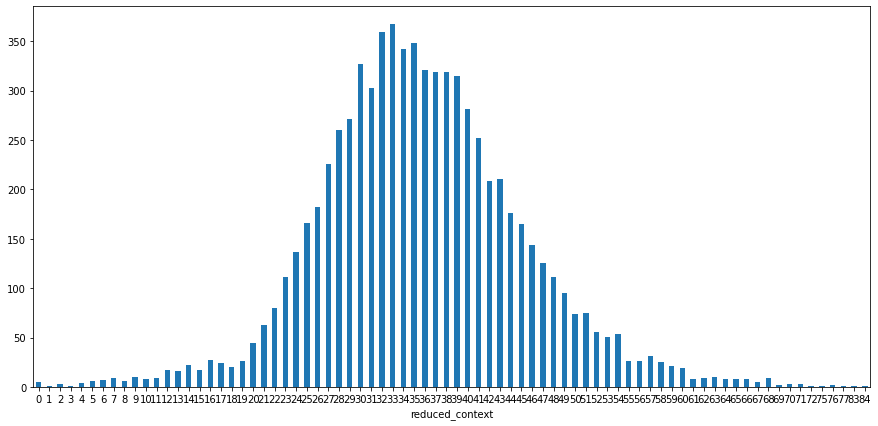

In [238]:
grouped = dev_coref_fuzzy_joint_df.groupby(dev_coref_fuzzy_joint_df['reduced_context'].map(lambda x: list(flatten(x)) ).str.len())
num_of_context_sentences = grouped.size()  # count of each  

# distribution of number of context sentences
plot = num_of_context_sentences.plot(kind = 'bar', figsize=(15, 7))
plt.xticks(rotation=0)                                    # show label text horizontally 
plt.show() 

In [240]:
dev_coref_fuzzy_joint_df['reduced_context_joint'] = dev_coref_fuzzy_joint_df['reduced_context'].map(lambda x: " ".join(list(flatten(x)) ))
dev_coref_fuzzy_joint_df['reduced_context_joint'] = dev_coref_fuzzy_joint_df['reduced_context_joint'].map(_normalize_text)  

dev_coref_fuzzy_joint_df['num_reduced_context_words'] = dev_coref_fuzzy_joint_df.reduced_context_joint.str.split(' ').str.len()

dev_coref_fuzzy_joint_df['reduced_context_word_ratio'] = dev_coref_fuzzy_joint_df.apply(lambda row: row['num_reduced_context_words'] / row['num_context_words'] , axis = 1)
dev_coref_fuzzy_joint_df['reduced_context_word_ratio'].describe()

count    7405.000000
mean        0.692418
std         0.159117
min         0.000934
25%         0.594326
50%         0.709220
75%         0.811065
max         1.000000
Name: reduced_context_word_ratio, dtype: float64

In [241]:
dev_coref_fuzzy_joint_df['reduced_context_sent_ratio'] = dev_coref_fuzzy_joint_df.apply(lambda row:  len(list(flatten(row['reduced_context']))) / len(list(flatten(row['context']))), axis = 1)

dev_coref_fuzzy_joint_df['reduced_context_sent_ratio'].describe()

count    7405.000000
mean        0.704258
std         0.145733
min         0.000000
25%         0.617647
50%         0.718750
75%         0.809524
max         1.000000
Name: reduced_context_sent_ratio, dtype: float64

#### Examples

##### Example 1

In [ ]:
dev_coref_fuzzy_joint_df.loc[dev_coref_fuzzy_joint_df['introduced_phrases'].str.len() == 8]

In [ ]:
example = dev_coref_fuzzy_joint_df.loc[dev_coref_fuzzy_joint_df._id == '5ae533535542993aec5ec173'].iloc[0]

In [ ]:
example.question

In [ ]:
question_phrases = example.question_phrases
question_phrases

In [ ]:
example.answer

In [ ]:
example.paras_phrases

In [ ]:
example.common_phrases

In [ ]:
example.question_only_phrase

In [ ]:
example.Steiner_tree

In [ ]:
Steiner_tree = json_graph.node_link_graph(example.Steiner_tree)
vis_graph(Steiner_tree, Steiner_tree.nodes(), question_phrases)

In [ ]:
example.introduced_phrases

In [ ]:
example.extended_phrases

In [ ]:
example.reduced_context_word_ratio

In [ ]:
example.reduced_context_sent_ratio

In [ ]:
example.supporting_facts

In [ ]:
example.supporting_facts_reduced_context

In [ ]:
list(enumerate(example.context))

In [ ]:
list(enumerate(example.paras_phrases[5]))

In [ ]:
example.context

In [ ]:
example.reduced_context

##### Example 2

In [ ]:
example = dev_coref_fuzzy_joint_df.loc[dev_coref_fuzzy_joint_df._id == '5a85ea095542994775f606a8'].iloc[0]

In [ ]:
example.question

In [ ]:
question_phrases = example.question_phrases
question_phrases

In [ ]:
example.answer

In [ ]:
example.paras_phrases

In [ ]:
example.common_phrases

In [206]:
example.question_only_phrase

[]

In [207]:
example.Steiner_tree

{'directed': False,
 'multigraph': False,
 'graph': {},
 'nodes': [{'score': 0.14454392296888502, 'id': 'nicolas cage'},
  {'score': 0.09743917970344701, 'id': 'weissman'},
  {'score': 0.306186217847897, 'id': 'film'},
  {'score': 0.26856060862700504, 'id': 'screenwriter'},
  {'score': 0.12579526735194901, 'id': 'téa leoni'},
  {'score': 0.14552184393439602, 'id': 'credit'},
  {'score': 0.066679331454725, 'id': 'cage'},
  {'score': 0.08812941054404201, 'id': 'leoni'}],
 'links': [{'src': [[9, 1]], 'source': 'nicolas cage', 'target': 'téa leoni'},
  {'src': [[9, 1]], 'source': 'nicolas cage', 'target': 'leoni'},
  {'src': [[1, 4]], 'source': 'nicolas cage', 'target': 'film'},
  {'src': [[5, 2]], 'source': 'nicolas cage', 'target': 'cage'},
  {'src': [[9, 1]], 'source': 'nicolas cage', 'target': 'weissman'},
  {'src': [[9, 1]], 'source': 'weissman', 'target': 'téa leoni'},
  {'src': [[9, 1]], 'source': 'weissman', 'target': 'leoni'},
  {'src': [[9, 1]], 'source': 'weissman', 'target': 'f

nodes to draw ['nicolas cage', 'weissman', 'film', 'screenwriter', 'téa leoni', 'credit', 'cage', 'leoni']


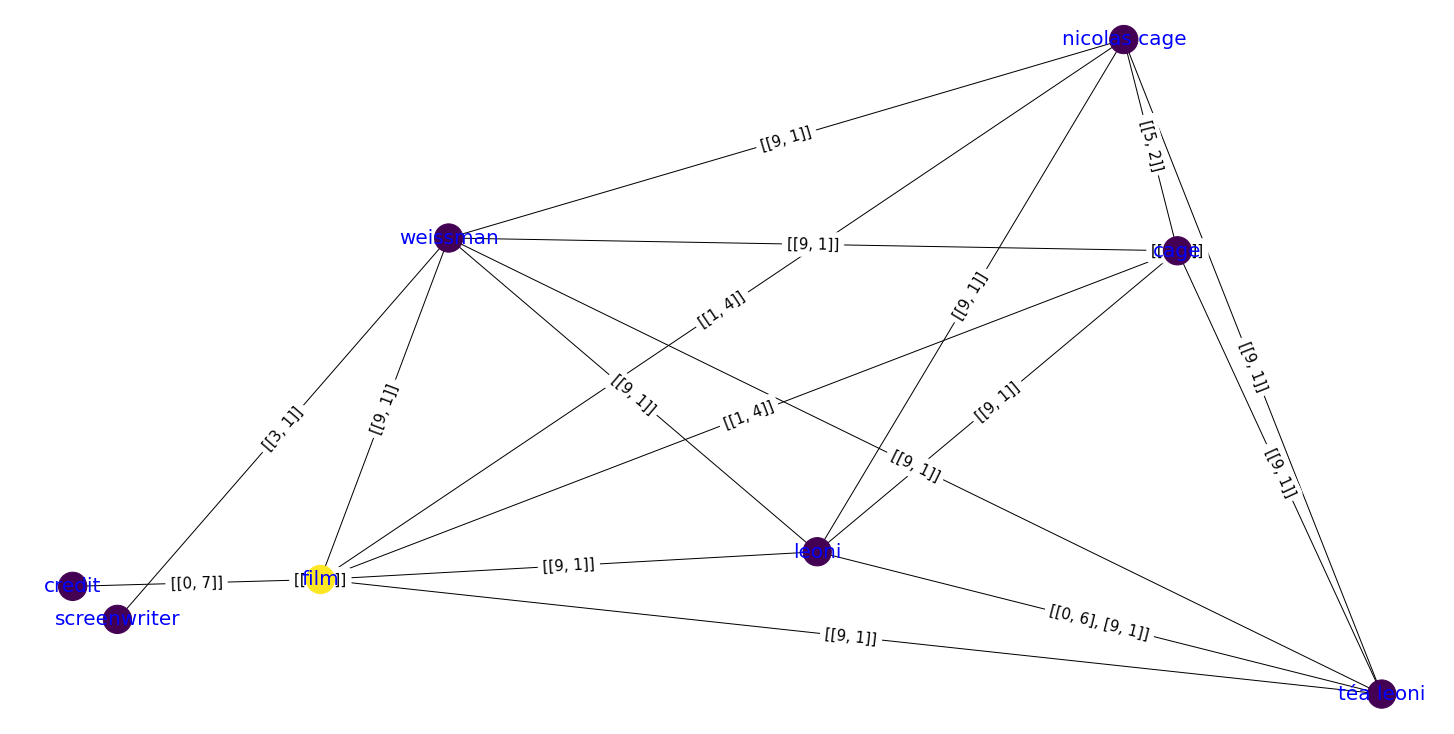

(nicolas cage, téa leoni, {'src': [[9, 1]]})
(nicolas cage, leoni, {'src': [[9, 1]]})
(nicolas cage, film, {'src': [[1, 4]]})
(nicolas cage, cage, {'src': [[5, 2]]})
(nicolas cage, weissman, {'src': [[9, 1]]})
(weissman, nicolas cage, {'src': [[9, 1]]})
(weissman, téa leoni, {'src': [[9, 1]]})
(weissman, leoni, {'src': [[9, 1]]})
(weissman, film, {'src': [[9, 1]]})
(weissman, cage, {'src': [[9, 1]]})
(weissman, screenwriter, {'src': [[3, 1]]})
(film, nicolas cage, {'src': [[1, 4]]})
(film, weissman, {'src': [[9, 1]]})
(film, téa leoni, {'src': [[9, 1]]})
(film, leoni, {'src': [[9, 1]]})
(film, credit, {'src': [[0, 7]]})
(film, film, {'src': [[7, 0]]})
(film, cage, {'src': [[1, 4]]})
(screenwriter, weissman, {'src': [[3, 1]]})
(téa leoni, nicolas cage, {'src': [[9, 1]]})
(téa leoni, weissman, {'src': [[9, 1]]})
(téa leoni, film, {'src': [[9, 1]]})
(téa leoni, leoni, {'src': [[0, 6], [9, 1]]})
(téa leoni, cage, {'src': [[9, 1]]})
(credit, film, {'src': [[0, 7]]})
(cage, nicolas cage, {'s

In [208]:
Steiner_tree = json_graph.node_link_graph(example.Steiner_tree)
vis_graph(Steiner_tree, Steiner_tree.nodes(), question_phrases)

In [209]:
example.introduced_phrases

{'weissman'}

In [210]:
example.extended_phrases

['nicolas cage',
 'weissman',
 'film',
 'screenwriter',
 'téa leoni',
 'credit',
 'cage',
 'leoni']

In [211]:
example.reduced_context_word_ratio

0.6725067385444744

In [212]:
example.reduced_context_sent_ratio

0.68

In [213]:
example.supporting_facts

[['David Weissman', 0], ['David Weissman', 1], ['The Family Man', 0]]

In [214]:
example.supporting_facts_reduced_context

[['David Weissman', 0], ['David Weissman', 1], ['The Family Man', 0]]

In [215]:
list(enumerate(example.context))

[(0,
  ['Ungod',
   ['Ungod is the debut album released in 1994 on Columbia Records by the American industrial rock band Stabbing Westward.',
    ' The album was recorded in six weeks of 1993 in Chiswick, England, and released on February 15, 1994.',
    ' With adequate album sales and touring with the likes of Depeche Mode a second album was warranted, "Wither Blister Burn & Peel".',
    ' The guitar line in the chorus of the song "Ungod" was later used in Filter\'s song "Hey Man, Nice Shot."',
    ' Stuart Zechman, who was also playing guitar for Filter at the time, took the riff and showed it to Stabbing Westward who ended up using it as well.',
    ' The song "Nothing" appeared in the "Bad Boys" movie starring Will Smith, Martin Lawrence and Téa Leoni, but was not featured on the official soundtrack album.',
    ' The song also accompanied the credits of the film "Johnny Mnemonic" and was included on the film\'s soundtrack, along with the song "Lost".',
    ' "Lost", "Lies" and "Ca

In [216]:
list(enumerate(example.paras_phrases[5]))

[(0,
  [['60 second', 0.30294588717950705],
   ['second', 0.24813274397975302],
   ['2000', 0.21726008945965103],
   ['film', 0.18200064648685801],
   ['2000 film', 0.15364264248032802]]),
 (1,
  [['robert duvall', 0.13701920065241802],
   ['christopher eccleston', 0.132142731179512],
   ['giovanni ribisi', 0.12968576663386],
   ['angelina jolie', 0.128331229003168],
   ['nicolas cage', 0.12732133685864702],
   ['vinnie jones', 0.12722030109502602],
   ['60 seconds', 0.121256223760763],
   ['2000 american action heist film', 0.121108288171326],
   ['will patton', 0.10805060634100801],
   ['film', 0.107832769383497],
   ['duvall', 0.106838359190248],
   ['eccleston', 0.102373921452011],
   ['2000', 0.10199968875820901],
   ['jones', 0.10066389511301001],
   ['ribisi', 0.10016629378182301],
   ['seconds', 0.09992496508654501],
   ['jolie', 0.09899798864119401],
   ['american', 0.098493205940594],
   ['cage', 0.098234500899881],
   ['patton', 0.07171983231324801]]),
 (2,
  [['film', 0.113

In [217]:
example.context

[['Ungod',
  ['Ungod is the debut album released in 1994 on Columbia Records by the American industrial rock band Stabbing Westward.',
   ' The album was recorded in six weeks of 1993 in Chiswick, England, and released on February 15, 1994.',
   ' With adequate album sales and touring with the likes of Depeche Mode a second album was warranted, "Wither Blister Burn & Peel".',
   ' The guitar line in the chorus of the song "Ungod" was later used in Filter\'s song "Hey Man, Nice Shot."',
   ' Stuart Zechman, who was also playing guitar for Filter at the time, took the riff and showed it to Stabbing Westward who ended up using it as well.',
   ' The song "Nothing" appeared in the "Bad Boys" movie starring Will Smith, Martin Lawrence and Téa Leoni, but was not featured on the official soundtrack album.',
   ' The song also accompanied the credits of the film "Johnny Mnemonic" and was included on the film\'s soundtrack, along with the song "Lost".',
   ' "Lost", "Lies" and "Can\'t Happen He

In [218]:
example.reduced_context

[['Ungod',
  [' The song "Nothing" appeared in the "Bad Boys" movie starring Will Smith, Martin Lawrence and Téa Leoni, but was not featured on the official soundtrack album.',
   ' The song also accompanied the credits of the film "Johnny Mnemonic" and was included on the film\'s soundtrack, along with the song "Lost".',
   ' "Lost", "Lies" and "Can\'t Happen Here" were used in the film "Mortal Kombat", but Stabbing Westward refused to include it in the official soundtrack.']],
 ['Season of the Witch (2011 film)',
  ['Season of the Witch is a 2011 American historical fantasy adventure film starring Nicolas Cage and Ron Perlman and directed by Dominic Sena with extensive uncredited reshoots by Brett Ratner.',
   ' Cage and Perlman star as Teutonic Knights, who return from the Crusades to find their fatherland ruined by the Black Death.',
   ' The film draws inspiration from the 1957 film "The Seventh Seal".',
   ' It reunited Sena and Cage who had previously worked together on "Gone in

##### Example 3

In [219]:
example = dev_coref_fuzzy_joint_df.loc[dev_coref_fuzzy_joint_df.has_introduced_phrases == True].iloc[3] 

AttributeError: 'DataFrame' object has no attribute 'has_introduced_phrases'

In [ ]:
example.question

In [ ]:
question_phrases = example.question_phrases
question_phrases

In [ ]:
example.answer

In [ ]:
example.paras_phrases

In [ ]:
example.common_phrases

In [220]:
example.question_only_phrase

[]

In [221]:
example.Steiner_tree

{'directed': False,
 'multigraph': False,
 'graph': {},
 'nodes': [{'score': 0.14454392296888502, 'id': 'nicolas cage'},
  {'score': 0.09743917970344701, 'id': 'weissman'},
  {'score': 0.306186217847897, 'id': 'film'},
  {'score': 0.26856060862700504, 'id': 'screenwriter'},
  {'score': 0.12579526735194901, 'id': 'téa leoni'},
  {'score': 0.14552184393439602, 'id': 'credit'},
  {'score': 0.066679331454725, 'id': 'cage'},
  {'score': 0.08812941054404201, 'id': 'leoni'}],
 'links': [{'src': [[9, 1]], 'source': 'nicolas cage', 'target': 'téa leoni'},
  {'src': [[9, 1]], 'source': 'nicolas cage', 'target': 'leoni'},
  {'src': [[1, 4]], 'source': 'nicolas cage', 'target': 'film'},
  {'src': [[5, 2]], 'source': 'nicolas cage', 'target': 'cage'},
  {'src': [[9, 1]], 'source': 'nicolas cage', 'target': 'weissman'},
  {'src': [[9, 1]], 'source': 'weissman', 'target': 'téa leoni'},
  {'src': [[9, 1]], 'source': 'weissman', 'target': 'leoni'},
  {'src': [[9, 1]], 'source': 'weissman', 'target': 'f

nodes to draw ['nicolas cage', 'weissman', 'film', 'screenwriter', 'téa leoni', 'credit', 'cage', 'leoni']


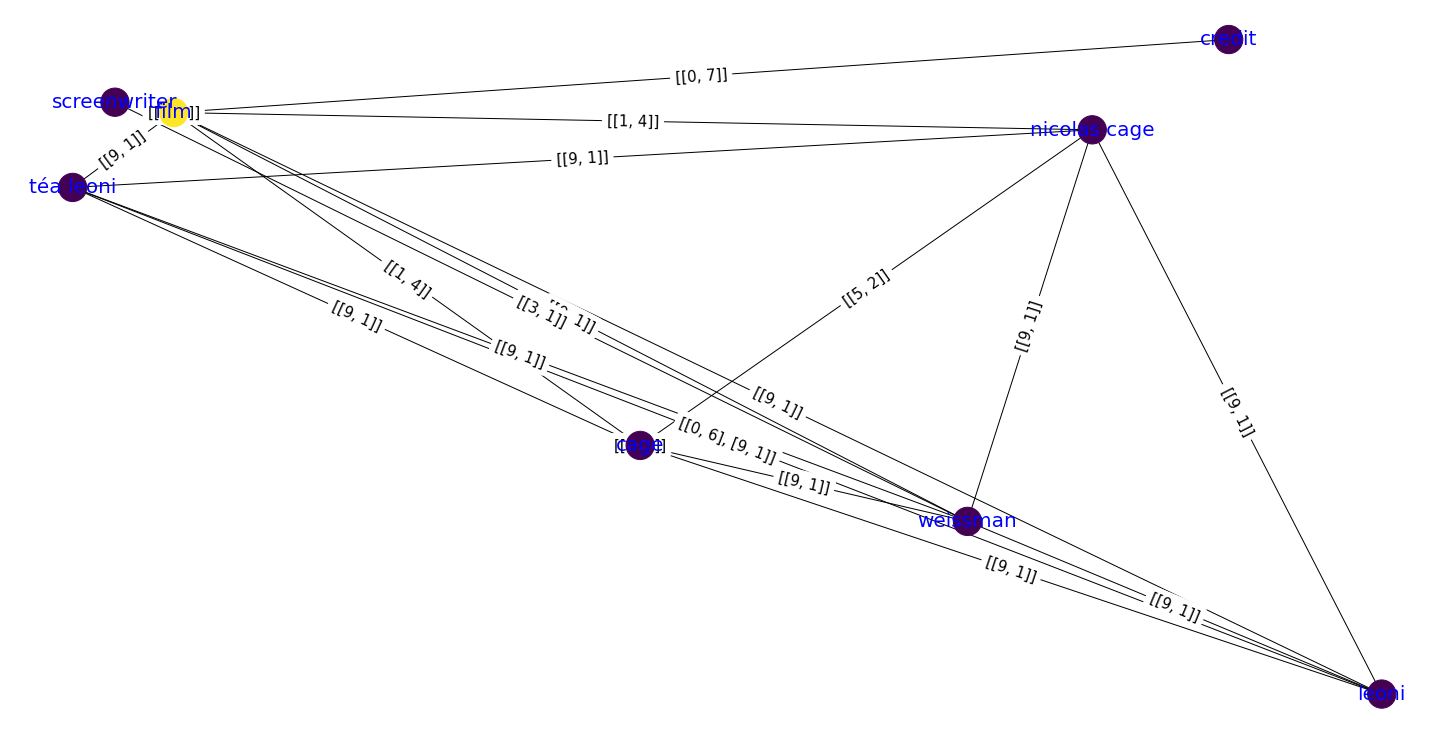

(nicolas cage, téa leoni, {'src': [[9, 1]]})
(nicolas cage, leoni, {'src': [[9, 1]]})
(nicolas cage, film, {'src': [[1, 4]]})
(nicolas cage, cage, {'src': [[5, 2]]})
(nicolas cage, weissman, {'src': [[9, 1]]})
(weissman, nicolas cage, {'src': [[9, 1]]})
(weissman, téa leoni, {'src': [[9, 1]]})
(weissman, leoni, {'src': [[9, 1]]})
(weissman, film, {'src': [[9, 1]]})
(weissman, cage, {'src': [[9, 1]]})
(weissman, screenwriter, {'src': [[3, 1]]})
(film, nicolas cage, {'src': [[1, 4]]})
(film, weissman, {'src': [[9, 1]]})
(film, téa leoni, {'src': [[9, 1]]})
(film, leoni, {'src': [[9, 1]]})
(film, credit, {'src': [[0, 7]]})
(film, film, {'src': [[7, 0]]})
(film, cage, {'src': [[1, 4]]})
(screenwriter, weissman, {'src': [[3, 1]]})
(téa leoni, nicolas cage, {'src': [[9, 1]]})
(téa leoni, weissman, {'src': [[9, 1]]})
(téa leoni, film, {'src': [[9, 1]]})
(téa leoni, leoni, {'src': [[0, 6], [9, 1]]})
(téa leoni, cage, {'src': [[9, 1]]})
(credit, film, {'src': [[0, 7]]})
(cage, nicolas cage, {'s

In [222]:
Steiner_tree = json_graph.node_link_graph(example.Steiner_tree)
vis_graph(Steiner_tree, Steiner_tree.nodes(), question_phrases)

In [223]:
example.introduced_phrases

{'weissman'}

In [224]:
example.extended_phrases

['nicolas cage',
 'weissman',
 'film',
 'screenwriter',
 'téa leoni',
 'credit',
 'cage',
 'leoni']

In [225]:
example.reduced_context_word_ratio

0.6725067385444744

In [226]:
example.reduced_context_sent_ratio

0.68

In [227]:
example.supporting_facts

[['David Weissman', 0], ['David Weissman', 1], ['The Family Man', 0]]

In [228]:
example.supporting_facts_reduced_context

[['David Weissman', 0], ['David Weissman', 1], ['The Family Man', 0]]

In [229]:
list(enumerate(example.context))

[(0,
  ['Ungod',
   ['Ungod is the debut album released in 1994 on Columbia Records by the American industrial rock band Stabbing Westward.',
    ' The album was recorded in six weeks of 1993 in Chiswick, England, and released on February 15, 1994.',
    ' With adequate album sales and touring with the likes of Depeche Mode a second album was warranted, "Wither Blister Burn & Peel".',
    ' The guitar line in the chorus of the song "Ungod" was later used in Filter\'s song "Hey Man, Nice Shot."',
    ' Stuart Zechman, who was also playing guitar for Filter at the time, took the riff and showed it to Stabbing Westward who ended up using it as well.',
    ' The song "Nothing" appeared in the "Bad Boys" movie starring Will Smith, Martin Lawrence and Téa Leoni, but was not featured on the official soundtrack album.',
    ' The song also accompanied the credits of the film "Johnny Mnemonic" and was included on the film\'s soundtrack, along with the song "Lost".',
    ' "Lost", "Lies" and "Ca

In [230]:
list(enumerate(example.paras_phrases[5]))

[(0,
  [['60 second', 0.30294588717950705],
   ['second', 0.24813274397975302],
   ['2000', 0.21726008945965103],
   ['film', 0.18200064648685801],
   ['2000 film', 0.15364264248032802]]),
 (1,
  [['robert duvall', 0.13701920065241802],
   ['christopher eccleston', 0.132142731179512],
   ['giovanni ribisi', 0.12968576663386],
   ['angelina jolie', 0.128331229003168],
   ['nicolas cage', 0.12732133685864702],
   ['vinnie jones', 0.12722030109502602],
   ['60 seconds', 0.121256223760763],
   ['2000 american action heist film', 0.121108288171326],
   ['will patton', 0.10805060634100801],
   ['film', 0.107832769383497],
   ['duvall', 0.106838359190248],
   ['eccleston', 0.102373921452011],
   ['2000', 0.10199968875820901],
   ['jones', 0.10066389511301001],
   ['ribisi', 0.10016629378182301],
   ['seconds', 0.09992496508654501],
   ['jolie', 0.09899798864119401],
   ['american', 0.098493205940594],
   ['cage', 0.098234500899881],
   ['patton', 0.07171983231324801]]),
 (2,
  [['film', 0.113

In [231]:
example.context

[['Ungod',
  ['Ungod is the debut album released in 1994 on Columbia Records by the American industrial rock band Stabbing Westward.',
   ' The album was recorded in six weeks of 1993 in Chiswick, England, and released on February 15, 1994.',
   ' With adequate album sales and touring with the likes of Depeche Mode a second album was warranted, "Wither Blister Burn & Peel".',
   ' The guitar line in the chorus of the song "Ungod" was later used in Filter\'s song "Hey Man, Nice Shot."',
   ' Stuart Zechman, who was also playing guitar for Filter at the time, took the riff and showed it to Stabbing Westward who ended up using it as well.',
   ' The song "Nothing" appeared in the "Bad Boys" movie starring Will Smith, Martin Lawrence and Téa Leoni, but was not featured on the official soundtrack album.',
   ' The song also accompanied the credits of the film "Johnny Mnemonic" and was included on the film\'s soundtrack, along with the song "Lost".',
   ' "Lost", "Lies" and "Can\'t Happen He

In [232]:
example.reduced_context

[['Ungod',
  [' The song "Nothing" appeared in the "Bad Boys" movie starring Will Smith, Martin Lawrence and Téa Leoni, but was not featured on the official soundtrack album.',
   ' The song also accompanied the credits of the film "Johnny Mnemonic" and was included on the film\'s soundtrack, along with the song "Lost".',
   ' "Lost", "Lies" and "Can\'t Happen Here" were used in the film "Mortal Kombat", but Stabbing Westward refused to include it in the official soundtrack.']],
 ['Season of the Witch (2011 film)',
  ['Season of the Witch is a 2011 American historical fantasy adventure film starring Nicolas Cage and Ron Perlman and directed by Dominic Sena with extensive uncredited reshoots by Brett Ratner.',
   ' Cage and Perlman star as Teutonic Knights, who return from the Crusades to find their fatherland ruined by the Black Death.',
   ' The film draws inspiration from the 1957 film "The Seventh Seal".',
   ' It reunited Sena and Cage who had previously worked together on "Gone in

#### answer

In [242]:
dev_coref_fuzzy_joint_df['normalized_answer_in_reduced_context'] = dev_coref_fuzzy_joint_df.apply(lambda row:  findWord(row['answer'], row['reduced_context_joint']) == True , axis = 1)

In [243]:
dev_coref_fuzzy_joint_df.normalized_answer_in_reduced_context.value_counts()

True     6569
False     836
Name: normalized_answer_in_reduced_context, dtype: int64

In [244]:
# dev_coref_fuzzy_joint_df.loc[(dev_coref_fuzzy_joint_df.reduced_context.str.len() > 0) & ((dev_coref_fuzzy_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_coref_fuzzy_joint_df['answer'] == 'yes') | (dev_coref_fuzzy_joint_df['answer'] == 'no')) ].shape[0]

##### Outliers

In [245]:
dev_coref_fuzzy_outliers = dev_coref_fuzzy_joint_df.loc[( dev_coref_fuzzy_joint_df.normalized_answer_in_context == True) &(dev_coref_fuzzy_joint_df.normalized_answer_in_reduced_context == False) & (dev_coref_fuzzy_joint_df['answer'] != 'yes') & (dev_coref_fuzzy_joint_df['answer'] != 'no') & (dev_coref_fuzzy_joint_df['answer'] != '')]

dev_coref_fuzzy_outliers.shape[0]

617

###### Outlier 1

In [172]:
print(dev_coref_fuzzy_outliers.iloc[1]._id)
dev_coref_fuzzy_outliers.iloc[1].question

5a722b8655429971e9dc9329


"Who was the writer of These Boots Are Made for Walkin' and who died in 2007?"

In [173]:
question_phrases = dev_coref_fuzzy_outliers.iloc[1].question_phrases
question_phrases

['boot', 'walkin', 'writer', '2007', 'boot make walkin']

The pharse extraction is not perfect, *'hedgehog'* should be extract

In [174]:
dev_coref_fuzzy_outliers.iloc[1].paras_phrases

[[[['nancy sinatra', 0.433012701892219], ['sinatra', 0.33333333333333304]],
  [['nancy sandra sinatra', 0.21498584908474103],
   ['sinatra', 0.16585289300174902],
   ['singer', 0.149071198499985],
   ['actress', 0.149071198499985],
   ['american', 0.149071198499985],
   ['june 8 1940', 0.137136883379324],
   ['american singer', 0.114285714285714]],
  [['nancy sandra sinatra', 0.20289786353278302],
   ['frank sinatra', 0.17980007720211502],
   ['sinatra', 0.157737179538074],
   ['nancy', 0.13578942165347502],
   ['1966 signature', 0.12578653727285],
   ['june 8 1940', 0.11049229779925601],
   ['nancy barbato frank sinatra', 0.10416975057703001],
   ['signature', 0.096830521539881],
   ['boot', 0.094917984817405],
   ['walkin', 0.094917984817405],
   ['june 8 1940 1966', 0.093194682581356],
   ['daughter', 0.08817602111879101],
   ['barbato', 0.08381988109461601],
   ['eld daughter', 0.06330202352271501],
   ['boot make walkin', 0.05398017267542601]]],
 [[['kon kan', 0.433012701892219], 

In [175]:
dev_coref_fuzzy_outliers.iloc[1].common_phrases

['boot', 'walkin', 'boot make walkin']

In [176]:
dev_coref_fuzzy_outliers.iloc[1].Steiner_tree_phrase

['boot', 'walkin', 'boot make walkin']

In [177]:
dev_coref_fuzzy_outliers.iloc[1].Steiner_tree

{'directed': False,
 'multigraph': False,
 'graph': {},
 'nodes': [{'score': 0.255550625999975, 'id': 'boot'},
  {'score': 0.08643987409140301, 'id': 'walkin'},
  {'score': 0.06601641744217, 'id': 'boot make walkin'}],
 'links': [{'src': [[0, 2], [1, 2], [4, 2], [5, 1], [7, 0], [8, 0], [8, 1]],
   'source': 'boot',
   'target': 'walkin'},
  {'src': [[1, 2], [8, 1]], 'source': 'boot', 'target': 'boot make walkin'},
  {'src': [[2, 7]], 'source': 'boot', 'target': 'boot'},
  {'src': [[1, 2], [8, 1]], 'source': 'walkin', 'target': 'boot make walkin'}]}

nodes to draw ['boot', 'walkin', 'boot make walkin']


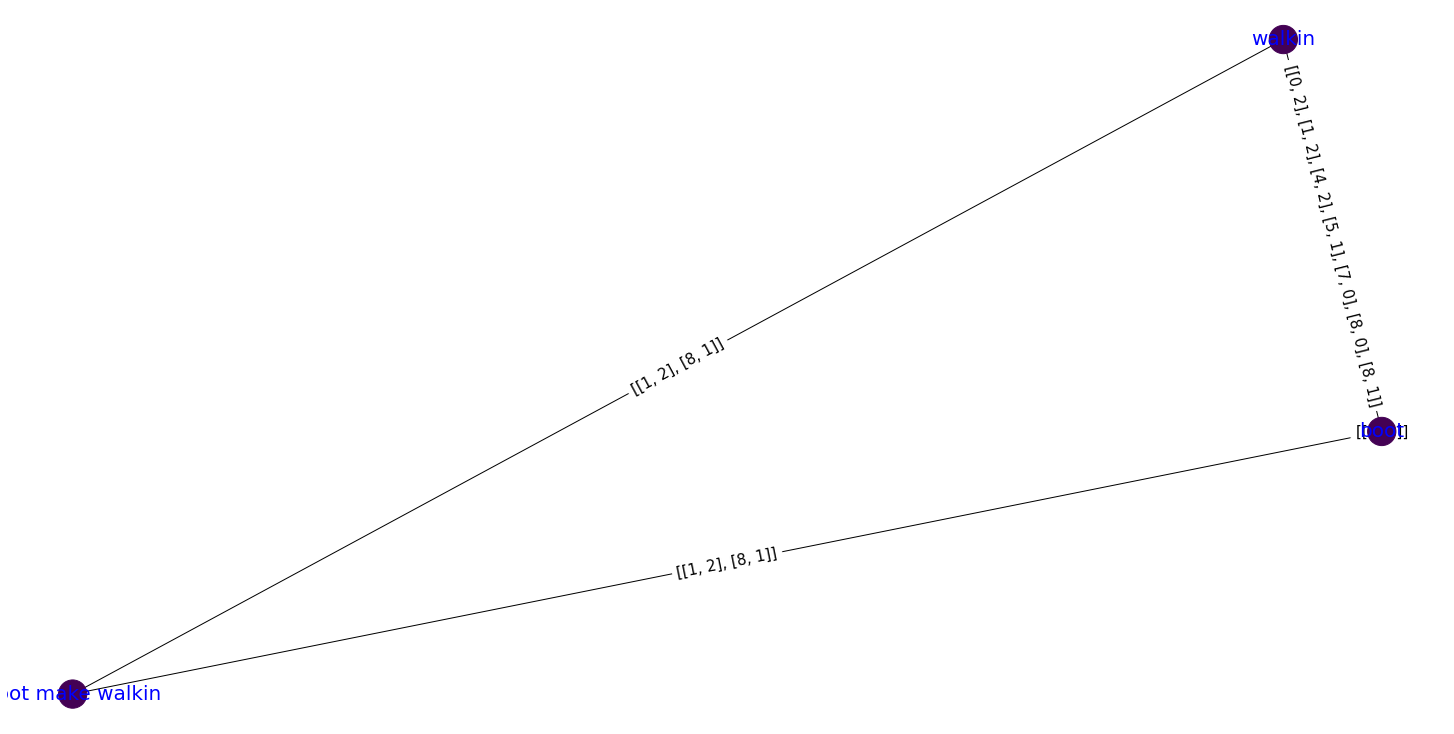

(boot, walkin, {'src': [[0, 2], [1, 2], [4, 2], [5, 1], [7, 0], [8, 0], [8, 1]]})
(boot, boot make walkin, {'src': [[1, 2], [8, 1]]})
(boot, boot, {'src': [[2, 7]]})
(walkin, boot, {'src': [[0, 2], [1, 2], [4, 2], [5, 1], [7, 0], [8, 0], [8, 1]]})
(walkin, boot make walkin, {'src': [[1, 2], [8, 1]]})
(boot make walkin, boot, {'src': [[1, 2], [8, 1]]})
(boot make walkin, walkin, {'src': [[1, 2], [8, 1]]})


In [178]:
Steiner_tree = json_graph.node_link_graph(dev_coref_fuzzy_outliers.iloc[1].Steiner_tree)
vis_graph(Steiner_tree, Steiner_tree.nodes(), question_phrases)

###### Outlier 2

In [179]:
print(dev_coref_fuzzy_outliers.iloc[2]._id)
dev_coref_fuzzy_outliers.iloc[2].question

5a77724455429972597f153e


'What race track in the midwest hosts a 500 mile race eavery May?'

In [180]:
question_phrases = dev_coref_fuzzy_outliers.iloc[2].question_phrases
question_phrases

['500 mile', 'race', 'midwest', 'host', 'midwest host']

In [181]:
dev_coref_fuzzy_outliers.iloc[2].Steiner_tree_phrase

['500 mile', 'race']

In [182]:
dev_coref_fuzzy_outliers.iloc[2].common_phrases

['500 mile', 'race']

In [183]:
dev_coref_fuzzy_outliers.iloc[2].question_only_phrase

['midwest host', 'midwest', 'host']

In [184]:
dev_coref_fuzzy_outliers.iloc[2].Steiner_tree

{'directed': False,
 'multigraph': False,
 'graph': {},
 'nodes': [{'score': 0.110773292934029, 'id': '500 mile'},
  {'score': 0.09750212369095, 'id': 'race'}],
 'links': [{'src': [[1, 4]], 'source': '500 mile', 'target': 'race'},
  {'src': [[1, 5]], 'source': '500 mile', 'target': '500 mile'},
  {'src': [[4, 3]], 'source': 'race', 'target': 'race'}]}

nodes to draw ['500 mile', 'race']


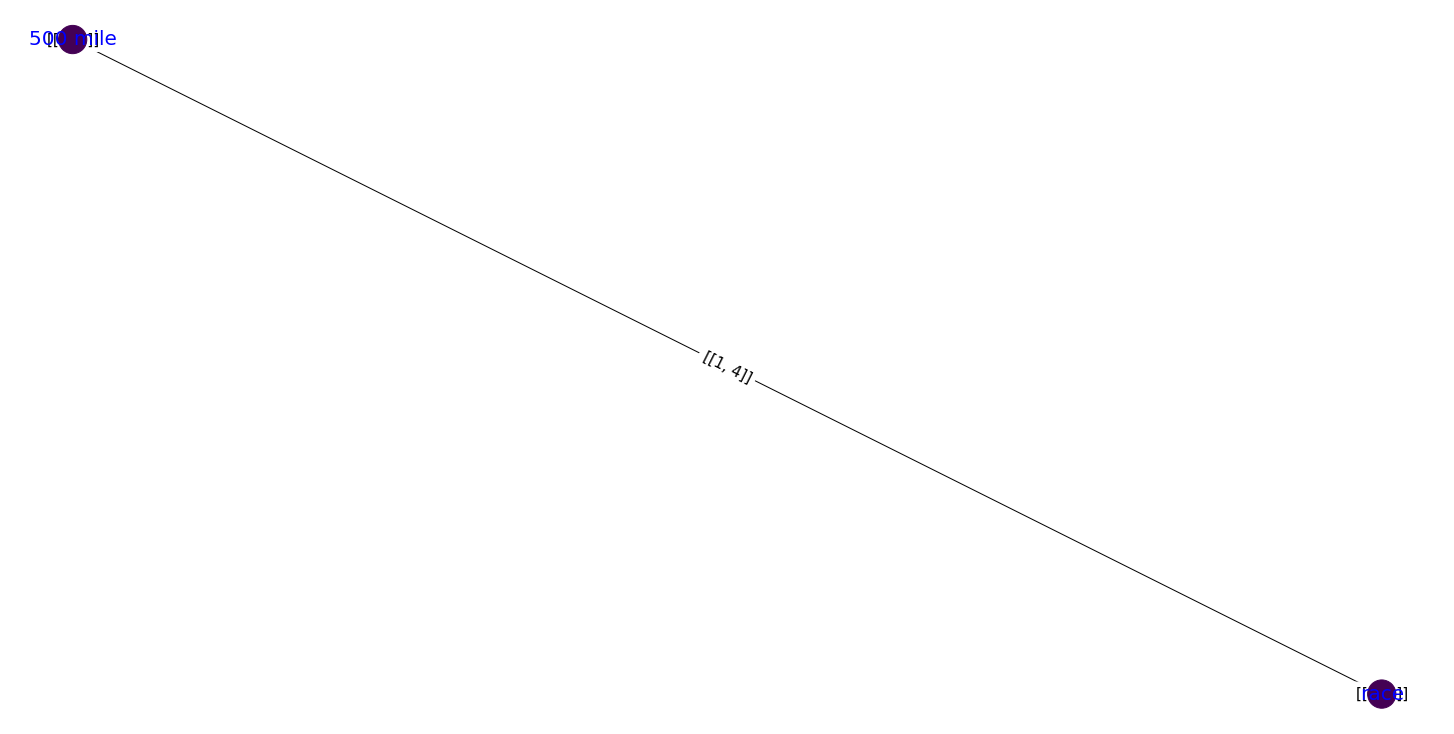

(500 mile, race, {'src': [[1, 4]]})
(500 mile, 500 mile, {'src': [[1, 5]]})
(race, 500 mile, {'src': [[1, 4]]})
(race, race, {'src': [[4, 3]]})


In [185]:
Steiner_tree = json_graph.node_link_graph(dev_coref_fuzzy_outliers.iloc[2].Steiner_tree)
vis_graph(Steiner_tree, Steiner_tree.nodes(), question_phrases)

In [186]:
dev_coref_fuzzy_outliers.iloc[2].supporting_facts_reduced_context

[]

In [187]:
dev_coref_fuzzy_outliers.iloc[2].supporting_facts

[['1957 Indianapolis 500', 0], ['Indianapolis Motor Speedway', 0]]

###### Outlier 3

In [188]:
print(dev_coref_fuzzy_outliers.iloc[3]._id)
dev_coref_fuzzy_outliers.iloc[3].question

5a87c13f5542996e4f30890c


'In what city did the "Prince of tenors" star in a film based on an opera by Giacomo Puccini?'

In [189]:
question_phrases = dev_coref_fuzzy_outliers.iloc[3].question_phrases
question_phrases

['giacomo puccini', 'opera', 'tenor', 'film', 'puccini', 'city']

The pharse extraction is not perfect, *'These Boots Are Made for Walkin'* should be extract

In [190]:
dev_coref_fuzzy_outliers.iloc[3].paras_phrases

[[[['ron bottcher', 0.433012701892219], ['bottcher', 0.33333333333333304]],
  [['opera', 0.151263916304226],
   ['12 april', 0.14188115214017802],
   ['new york city opera', 0.130861786822865],
   ['baritone', 0.12406649690547501],
   ['ron bottcher', 0.12307627345973801],
   ['april 1991', 0.12307627345973801],
   ['11 may 1940', 0.10770978379017501],
   ['bottcher', 0.10234480213449],
   ['april', 0.10234480213449],
   ['american operatic baritone', 0.10194498976878501],
   ['american', 0.09100023809075801],
   ['metropolitan opera', 0.09036921983802401],
   ['nyco', 0.08957831822048601],
   ['1960', 0.070059536488301]],
  [['12 april', 0.150397375613496],
   ['music degree', 0.14730575108891],
   ['ron bottcher', 0.137586203703326],
   ['11 may', 0.129824164234164],
   ['april 1991', 0.129824164234164],
   ['idaho', 0.12873552610163802],
   ['degree', 0.123224020508456],
   ['sandpoint', 0.11150435942422701],
   ['may', 0.108147614087175],
   ['april', 0.108147614087175],
   ['bottc

In [191]:
dev_coref_fuzzy_outliers.iloc[3].Steiner_tree_phrase

['puccini', 'giacomo puccini', 'film', 'tenor', 'italian', 'city', 'opera']

In [192]:
dev_coref_fuzzy_outliers.iloc[3].common_phrases

['film', 'city', 'opera', 'giacomo puccini', 'puccini', 'tenor']

In [193]:
dev_coref_fuzzy_outliers.iloc[3].question_only_phrase

[]

In [194]:
dev_coref_fuzzy_outliers.iloc[3].Steiner_tree

{'directed': False,
 'multigraph': False,
 'graph': {},
 'nodes': [{'score': 0.353553390593273, 'id': 'film'},
  {'score': 0.11816775327622, 'id': 'italian'},
  {'score': 0.11203502747061501, 'id': 'city'},
  {'score': 0.114222864099114, 'id': 'opera'},
  {'score': 0.433012701892219, 'id': 'puccini'},
  {'score': 0.18124864116636802, 'id': 'giacomo puccini'},
  {'score': 0.076134712796064, 'id': 'tenor'}],
 'links': [{'src': [[1, 1]], 'source': 'film', 'target': 'opera'},
  {'src': [[1, 1]], 'source': 'film', 'target': 'puccini'},
  {'src': [[6, 0]], 'source': 'film', 'target': 'film'},
  {'src': [[1, 1], [6, 1]], 'source': 'film', 'target': 'italian'},
  {'src': [[8, 1]], 'source': 'italian', 'target': 'opera'},
  {'src': [[9, 1]], 'source': 'italian', 'target': 'giacomo puccini'},
  {'src': [[8, 1]], 'source': 'italian', 'target': 'puccini'},
  {'src': [[3, 1]], 'source': 'italian', 'target': 'tenor'},
  {'src': [[3, 4]], 'source': 'city', 'target': 'opera'},
  {'src': [[9, 2]], 'sou

nodes to draw ['film', 'italian', 'city', 'opera', 'puccini', 'giacomo puccini', 'tenor']


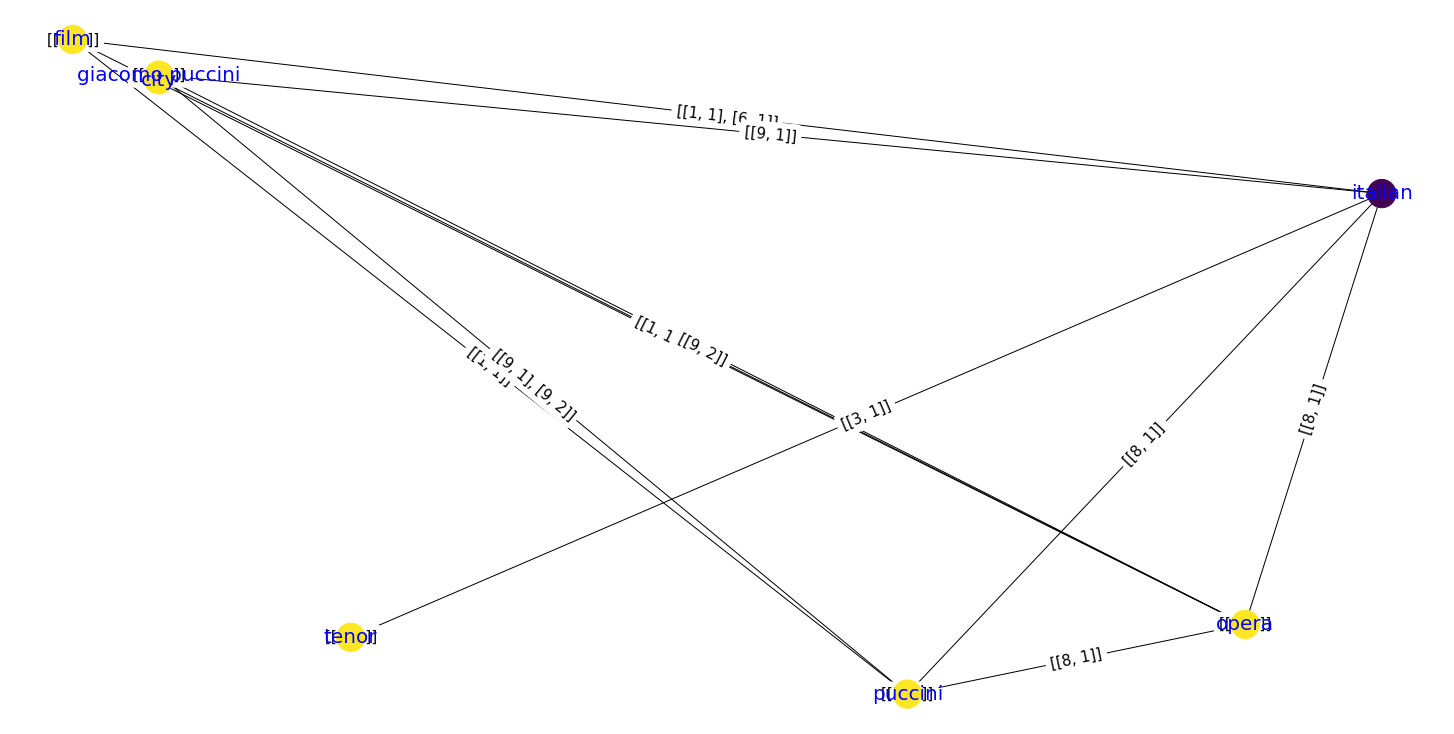

(film, opera, {'src': [[1, 1]]})
(film, puccini, {'src': [[1, 1]]})
(film, film, {'src': [[6, 0]]})
(film, italian, {'src': [[1, 1], [6, 1]]})
(italian, film, {'src': [[1, 1], [6, 1]]})
(italian, opera, {'src': [[8, 1]]})
(italian, giacomo puccini, {'src': [[9, 1]]})
(italian, puccini, {'src': [[8, 1]]})
(italian, tenor, {'src': [[3, 1]]})
(city, opera, {'src': [[3, 4]]})
(opera, film, {'src': [[1, 1]]})
(opera, italian, {'src': [[8, 1]]})
(opera, city, {'src': [[3, 4]]})
(opera, giacomo puccini, {'src': [[9, 2]]})
(opera, puccini, {'src': [[8, 1]]})
(opera, opera, {'src': [[2, 4]]})
(puccini, film, {'src': [[1, 1]]})
(puccini, italian, {'src': [[8, 1]]})
(puccini, opera, {'src': [[8, 1]]})
(puccini, giacomo puccini, {'src': [[9, 1], [9, 2]]})
(puccini, puccini, {'src': [[7, 1]]})
(giacomo puccini, italian, {'src': [[9, 1]]})
(giacomo puccini, opera, {'src': [[9, 2]]})
(giacomo puccini, puccini, {'src': [[9, 1], [9, 2]]})
(giacomo puccini, giacomo puccini, {'src': [[5, 3]]})
(tenor, it

In [195]:
Steiner_tree = json_graph.node_link_graph(dev_coref_fuzzy_outliers.iloc[3].Steiner_tree)
vis_graph(Steiner_tree, Steiner_tree.nodes(), question_phrases)

In [196]:
dev_coref_fuzzy_outliers.iloc[3].supporting_facts_reduced_context

[['Franco Corelli', 2]]

In [197]:
dev_coref_fuzzy_outliers.iloc[3].supporting_facts

[['Tosca (1956 film)', 2], ['Franco Corelli', 2]]

#### supporting facts

In [246]:
# Distribution of number of supporting facts in reduced_context
dev_coref_fuzzy_joint_df['num_of_sp_in_reduced_context'] = dev_coref_fuzzy_joint_df['supporting_facts_reduced_context'].map(lambda x: len(x))
grouped = dev_coref_fuzzy_joint_df.groupby(['num_of_sp_in_reduced_context'])
num_of_sp_in_reduced_context_counts = grouped.size()  # count of each 
num_of_sp_in_reduced_context_counts

num_of_sp_in_reduced_context
0      50
1     658
2    4765
3    1501
4     372
5      46
6       8
7       5
dtype: int64

In [247]:
# for questions whose answer in reduced_context, the ratio of supporting facts remained in the reduced context
dev_coref_fuzzy_joint_df.loc[(dev_coref_fuzzy_joint_df.reduced_context.str.len() > 0) & ((dev_coref_fuzzy_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_coref_fuzzy_joint_df['answer'] == 'yes') | (dev_coref_fuzzy_joint_df['answer'] == 'no'))].apply(lambda row: len(row['supporting_facts_reduced_context']) / len(row['supporting_facts'])  , axis=1).head(10)

0     0.5
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
dtype: float64

In [201]:
# ratio of supporting facts remained in the reduced context 
dev_coref_fuzzy_joint_df['sp_in_reduced_context_ratio'] = dev_coref_fuzzy_joint_df.apply(lambda row: len(row['supporting_facts_reduced_context']) / len(row['supporting_facts'])  , axis=1)

#dev_joint_df['sp_in_reduced_context'].map(lambda x: sum(x) / len(x)) 
dev_coref_fuzzy_joint_df['sp_in_reduced_context_ratio'].describe()

count    7405.000000
mean        0.899228
std         0.203988
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: sp_in_reduced_context_ratio, dtype: float64

In [202]:
# reduced_context contains the answer, even though does not contain any supporting fact
dev_coref_fuzzy_joint_df.loc[(dev_coref_fuzzy_joint_df.num_of_sp_in_reduced_context == 0) & (dev_coref_fuzzy_joint_df.normalized_answer_in_reduced_context == True)].shape[0]

7

In [203]:
# map sp from id to text
dev_coref_fuzzy_joint_df['sp_text_reduced_context'] = dev_coref_fuzzy_joint_df.apply(lambda row: [_normalize_text(dict(row['reduced_context'])[sp_t][sp_idx]) for (sp_t, sp_idx) in row['supporting_facts_reduced_context'] if(sp_idx < len(dict(row['reduced_context'])[sp_t])) ], axis = 1)

dev_coref_fuzzy_joint_df['sp_text_reduced_context']  

0       [scott derrickson born july 16 1966 is america...
1       [shirley temple black april 23 1928 – february...
2       [horkbajir chronicles is second companion book...
3       [laleli mosque turkish laleli camii or tulip m...
4       [adriana trigiani is italian american bestsell...
                              ...                        
7400    [coke kahani urdu کوک کہانی‎ is 2012 pakistani...
7401    [canfields diet chocolate fudge soda is zeroca...
7402    [billy is large scenthound originating from ce...
7403    [dig is american alternative rock band from lo...
7404    [analog devices inc also known as adi or analo...
Name: sp_text_reduced_context, Length: 7405, dtype: object

In [204]:
dev_coref_fuzzy_joint_df['normalized_answer_in_reduced_sp_text'] = dev_coref_fuzzy_joint_df.apply(lambda row: any([ findWord(row['answer'], f) == True for f in row['sp_text_reduced_context']]), axis = 1)
dev_coref_fuzzy_joint_df['normalized_answer_in_reduced_sp_text']

0       False
1        True
2        True
3       False
4        True
        ...  
7400     True
7401     True
7402    False
7403    False
7404     True
Name: normalized_answer_in_reduced_sp_text, Length: 7405, dtype: bool

In [205]:
dev_coref_fuzzy_joint_df.loc[(dev_coref_fuzzy_joint_df['answer'] != 'yes') & (dev_coref_fuzzy_joint_df['answer'] != 'no') & (dev_coref_fuzzy_joint_df['answer'] != '')].normalized_answer_in_reduced_sp_text.value_counts()

True     6072
False     873
Name: normalized_answer_in_reduced_sp_text, dtype: int64

In [206]:
# reduced_context contain the answer, but the sp in reduced context does not contain the answer
dev_coref_fuzzy_joint_df.loc[(dev_coref_fuzzy_joint_df.normalized_answer_in_reduced_context == True) & (dev_coref_fuzzy_joint_df.normalized_answer_in_reduced_sp_text == False) ].shape[0]

286

#### Reduced Question 
To train longformer on context vs reduced_context, compare run time and performance  
just over the questions has answer in the reduced_context
Thus save file contains only the questions has answer in the reduced_context

In [194]:
dev_coref_fuzzy_joint_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7405 entries, 0 to 7404
Data columns (total 23 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   _id                                   7405 non-null   object 
 1   question                              7405 non-null   object 
 2   answer                                7405 non-null   object 
 3   level                                 7405 non-null   object 
 4   type                                  7405 non-null   object 
 5   context                               7405 non-null   object 
 6   supporting_facts                      7405 non-null   object 
 7   reduced_context                       7405 non-null   object 
 8   supporting_facts_reduced_context      7405 non-null   object 
 9   question_phrases                      7405 non-null   object 
 10  paras_phrases                         7405 non-null   object 
 11  common_phrases   

In [195]:
hotpot_reduced_dev_coref_fuzzy_df = dev_coref_fuzzy_joint_df.loc[(dev_coref_fuzzy_joint_df.reduced_context.str.len() > 0) & ((dev_coref_fuzzy_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_coref_fuzzy_joint_df['answer'] == 'yes') | (dev_coref_fuzzy_joint_df['answer'] == 'no')) , ['supporting_facts', 'context', 'answer', '_id', 'question']]
hotpot_reduced_dev_coref_fuzzy_df.shape[0]

6428

In [170]:
dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no'))]['reduced_context'].map(lambda x: list(flatten(x)) ).str.len().describe()  # statistic of number of context sentences, including tilte

count    5075.000000
mean       20.241379
std         8.513192
min         1.000000
25%        15.000000
50%        20.000000
75%        26.000000
max        71.000000
Name: reduced_context, dtype: float64

In [171]:
dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no'))]['reduced_context_joint'].str.len().describe()  # statistic of number of words in reduced_context

count    5075.000000
mean     1845.822069
std       964.777206
min        10.000000
25%      1157.000000
50%      1731.000000
75%      2435.000000
max      7489.000000
Name: reduced_context_joint, dtype: float64

In [172]:
dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no'))]['context'].map(lambda x: list(flatten(x)) ).str.len().describe()  # statistic of number of context sentences, including tilte

count    5075.000000
mean       50.923941
std        11.397092
min         4.000000
25%        44.000000
50%        50.000000
75%        57.000000
max       144.000000
Name: context, dtype: float64

In [173]:
dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no'))]['context'].map(lambda x: " ".join(list(flatten(x))) ).str.len().describe() # statistic of number of words in the context

count     5075.000000
mean      5676.258522
std       1569.157603
min        324.000000
25%       4633.500000
50%       5580.000000
75%       6572.000000
max      15413.000000
Name: context, dtype: float64

In [ ]:
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))]['context'].map(lambda x: list(flatten(x)) ).str.len().describe()  # statistic of number of context sentences, including tilte

##### Save

In [174]:
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))]['context'].map(lambda x: " ".join(list(flatten(x))) ).str.len().describe() # statistic of number of words in the context#hotpot_reduced_dev_df.to_json("/xdisk/msurdeanu/fanluo/hotpotQA/Data/reduced_questions/context/hotpot_reduced_dev_distractor.json", orient="records") 

count    66872.000000
mean      5604.017451
std       1555.974212
min        197.000000
25%       4581.000000
50%       5496.000000
75%       6499.000000
max      17163.000000
Name: context, dtype: float64

In [175]:
# save file contains only the questions with reduced_context has answer in the reduced_context
hotpot_dev_reduced_context_df = dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no')) , ['supporting_facts_reduced_context', 'reduced_context', 'answer', '_id', 'question']] 

hotpot_dev_reduced_context_df.rename(columns={'supporting_facts_reduced_context': 'supporting_facts', "reduced_context": "context"}, inplace=True)
hotpot_dev_reduced_context_df.shape[0]

5075

In [176]:
hotpot_dev_reduced_context_detail_df = dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no')) , ['supporting_facts_reduced_context', 'reduced_context', 'answer', '_id', 'question', 'level', 'type', 'question_phrases', 'paras_phrases', 'common_phrases', 'path_phrases', 'extended_phrases', 'kept_para_sent', 'num_of_sp_in_reduced_context', 'sp_in_reduced_context_ratio']] 

hotpot_dev_reduced_context_detail_df.rename(columns={'supporting_facts_reduced_context': 'supporting_facts', "reduced_context": "context"}, inplace=True)
hotpot_dev_reduced_context_detail_df.shape[0]

5075

In [177]:
hotpot_dev_reduced_context_detail_df.iloc[1]

supporting_facts                [[The Hork-Bajir Chronicles, 0], [The Hork-Baj...
context                         [[Victoria Hanley, [ Her first three books, "T...
answer                                                                  animorphs
_id                                                      5a85ea095542994775f606a8
question                        What science fantasy young adult series, told ...
level                                                                        hard
type                                                                       bridge
question_phrases                [[science fantasy young adult series, 0.192038...
paras_phrases                   [[[['andre norton award', 0.4], ['andre norton...
common_phrases                       [first person, companion book, first, story]
path_phrases                    [first person, companion book, book, first, st...
extended_phrases                [first person, companion book, book, first, st...
kept_para_sent  

In [178]:
#hotpot_dev_reduced_context_df.to_json("/xdisk/msurdeanu/fanluo/hotpotQA/Data/reduced_questions/reduced_context/hotpot_reduced_dev_distractor_reduced_context.json", orient="records") 

#hotpot_dev_reduced_context_detail_df.to_json("/xdisk/msurdeanu/fanluo/hotpotQA/Data/reduced_questions/reduced_context/hotpot_reduced_dev_distractor_reduced_context_detail.json", orient="records") 

## Ranking

#### Sentences Similarity

##### sklearn

###### TF-IDF 

##### glove embedding

##### flair embedding

##### transformer embedding

#### Longformer

In [ ]:
>>> from transformers import LongformerTokenizer, LongformerForQuestionAnswering
>>> import torch

>>> tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-large-4096-finetuned-triviaqa")
>>> model = LongformerForQuestionAnswering.from_pretrained("allenai/longformer-large-4096-finetuned-triviaqa")

In [ ]:
#!python -m pip install flair
from typing import List
from torch.utils.data import Dataset
import torch
from flair.data import Sentence, Corpus
from flair.embeddings import DocumentRNNEmbeddings, BertEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
import time
import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix

In [ ]:
import nltk
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties


In [179]:
proposal: (10~12 pages)
    - intro and motivation
       - reasoning system without logic, approx instead, roubst with graph-based method
    - related works 
        -  qa 
        - KG based
        - multi-hop reasoning   
        - graph-based
        
    - pre results (analysis)
    - plan for the dissertation
       - refer to mithun's proposal under github's paper
        - 3 works
        

SyntaxError: invalid syntax (<ipython-input-179-26c7b2ff52f1>, line 1)